In [1]:
pip install plotly

In [2]:
pip install cufflinks

In [3]:
pip install plotly_express

In [4]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 14.4 MB/s 
     |████████████████████████████████| 15.4 MB 83.8 MB/s 
     |████████████████████████████████| 6.3 MB 27.5 MB/s 


In [5]:
pip install mpl-scatter-density

     |████████████████████████████████| 655 kB 11.6 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 


In [6]:
import numpy as np
import pandas as pd
import json
from pathlib import Path
from google.cloud import bigquery
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import os
import math
from sklearn.cluster import KMeans
import seaborn as sns
%config InlineBackend.figure_format='retina'
from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from descartes import PolygonPatch
from sklearn.ensemble import RandomForestClassifier
import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import plotly_express as px
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
import pathlib
from google.colab import drive
drive.mount('/content/drive')
#for using google drive

Mounted at /content/drive


In [ ]:
fullCOVIDtable = pd.read_csv('/content/drive/MyDrive/covid-19/fullCOVIDtable.csv', sep=';')#check point
fullCOVIDtable
#importing covid stat 2020 dataset

id  SCHOOL  WORK  ...  YOYELEC  CONTINENT        DATE
0            1     0.0   0.0  ...      NaN   Americas  2020-01-02
1            2     0.0   0.0  ...      NaN   Americas  2020-01-03
2            3     0.0   0.0  ...      NaN   Americas  2020-01-04
3            4     0.0   0.0  ...      NaN   Americas  2020-01-05
4            5     0.0   0.0  ...      NaN   Americas  2020-01-06
...        ...     ...   ...  ...      ...        ...         ...
157757  158442     NaN   NaN  ...      NaN        NaN  2020-12-30
157758  158443     NaN   NaN  ...      NaN        NaN  2020-12-30
157759  158444     NaN   NaN  ...      NaN        NaN  2020-12-30
157760  158445     NaN   NaN  ...      NaN        NaN  2020-12-30
157761  158446     NaN   NaN  ...      NaN        NaN  2020-12-30

[157762 rows x 41 columns]

In [ ]:
%load_ext google.cloud.bigquery
#for using google big query api
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/covid-19/optimum-phalanx-313513-3fd99581a511.json"
PROJECT_ID = 'optimum-phalanx-313513'
client = bigquery.Client(project=PROJECT_ID)
#***การจะใช้ BigQuery API ได้ต้องสมัครบริการ Google Cloud Platform ก่อน และจะต้องสร้าง Credential สำหรับใช้งาน BigQuery API ด้วยการ Setting up authentication ก่อน 
#***ซึ่งมีขั้นตอนตามเว็บ https://cloud.google.com/bigquery/docs/reference/libraries
#***ซึ่งเมื่อทำถูกต้องตามขั้นตอนจะต้องได้ไฟล์ Credential .json แล้วให้ upload ไฟล์ Credential นี้ตาม path ใน code หรือตาม path ที่ต้องการ
#***ถ้าไม่ต้องการใช้ BigQuery API ให้ข้ามไปรันโค้ดที่บรรทัดที่ปรากฎคำในคอมเม้นต์ที่บรรทัดแรกว่า ***Hello COVID*** ได้เลย เพราะผู้วิจัยได้จัดเก็บไฟล์ทุกอย่างไว้ให้หมดแล้ว
#***For using BigQuery API we must register Google cloud platform account first. And we must create credential file in order to use BigQuery API by setting up attentication.
#***To create the credential, follow the instruction in this website https://cloud.google.com/bigquery/docs/reference/libraries
#***After create the credential file that is a .json file. Upload that credential file to the GOOGLE_APPLICATION_CREDENTIALS path above or the path you need.
#***If you don't need to retrive the weather data from BigQuery API by yourself, I have already provided the weather data from BigQuery API in this git
#***so you can just skip the Google cloud step and can run the code in the block that you see the word ***Hello COVID***.

In [ ]:
table1_stations = bigquery.TableReference.from_string(
    "bigquery-public-data.noaa_gsod.stations"
)

dataframe_stations = client.list_rows(
    table1_stations,
    selected_fields=[
        bigquery.SchemaField("usaf", "STRING"), #station number, world metherorological org
        bigquery.SchemaField("wban", "STRING"), #wban number, weather bureau army
        bigquery.SchemaField("country", "STRING"),
        bigquery.SchemaField("lat", "FLOAT"),
        bigquery.SchemaField("lon", "FLOAT"),
    ],
).to_dataframe()

dataframe_stations
#retrieving weather station's position around the world

usaf   wban country     lat     lon
0      007018  99999    None   0.000   0.000
1      007026  99999      AF   0.000   0.000
2      007070  99999      AF   0.000   0.000
3      008268  99999      AF  32.950  65.567
4      008307  99999      AF   0.000   0.000
...       ...    ...     ...     ...     ...
29585  A06884  00416      US  38.667 -78.501
29586  A07086  00468      US  41.516 -82.869
29587  A51255  00445      US  32.464 -87.954
29588  A51256  00451      US  36.699 -93.402
29589  723629  53998      US  30.069 -93.804

[29590 rows x 5 columns]

In [ ]:
table1_gsod2020 = bigquery.TableReference.from_string(
    "bigquery-public-data.noaa_gsod.gsod2020"
)

dataframe_gsod2020= client.list_rows(table1_gsod2020,
    selected_fields=[
        bigquery.SchemaField("stn", "STRING"),
        bigquery.SchemaField("wban", "STRING"),
        bigquery.SchemaField("year", "INTEGER"),
        bigquery.SchemaField("mo", "INTEGER"),
        bigquery.SchemaField("da", "INTEGER"),
        bigquery.SchemaField("temp", "FLOAT"), #average temp
        bigquery.SchemaField("dewp", "FLOAT"), #average dew point temp
        bigquery.SchemaField("slp", "FLOAT"), #average pressure from sea level
        bigquery.SchemaField("wdsp", "FLOAT"), #average windspeed
        bigquery.SchemaField("prcp", "FLOAT"), #rain volume
        bigquery.SchemaField("sndp", "FLOAT"), #snow
    ],).to_dataframe()

dataframe_gsod2020
#retreive weather factor information year 2020
#4 millions records

stn   wban  year  mo  da  temp    dewp     slp  wdsp  prcp   sndp
0        701945  46405  2020   2  16 -35.5  9999.9  1027.4   3.3  0.00  999.9
1        701945  46405  2020  12   6 -27.0  9999.9  1014.6   2.9  0.00  999.9
2        702220  26501  2020   1  10 -44.3  9999.9  1027.3   0.6  0.00  999.9
3        724347  53904  2020   1  14  38.1  9999.9  1020.9   3.2  0.00  999.9
4        817540  99999  2020   6   7  77.9  9999.9  1014.3   0.4  0.00  999.9
...         ...    ...   ...  ..  ..   ...     ...     ...   ...   ...    ...
4107416  999999  40710  2020   5  25  82.1    76.3  1011.8   8.7  0.13  999.9
4107417  999999  40710  2020   5  26  79.5    75.7  1013.0   6.4  0.71  999.9
4107418  999999  40710  2020   6  29  81.8    75.9  1009.1   3.1  0.94  999.9
4107419  999999  40710  2020  11  13  84.1    76.3  1011.1   7.3  0.06  999.9
4107420  999999  40710  2020  12   7  82.3    75.2  1010.3   9.2  0.24  999.9

[4107421 rows x 11 columns]

In [ ]:
stations_df= dataframe_stations
twenty_twenty_df= dataframe_gsod2020

In [ ]:
stations_df['STN'] = stations_df['usaf'] + '-' + stations_df['wban']
twenty_twenty_df['STN'] = twenty_twenty_df['stn'] + '-' + twenty_twenty_df['wban']
cols_1= list(twenty_twenty_df.columns)
cols_2= list(stations_df.columns)
weather_df = twenty_twenty_df[cols_1].join(stations_df[cols_2].set_index('STN'), on='STN',  how='left', lsuffix='_left', rsuffix='_right')

weather_df['temp'] = weather_df['temp'].apply(lambda x: np.nan if x==9999.9 else x)#อันไหนไม่มีค่าใส่ 9999.9
weather_df['slp'] = weather_df['slp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['dewp'] = weather_df['dewp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['wdsp'] = weather_df['wdsp'].apply(lambda x: np.nan if x==999.9 else x)
weather_df['prcp'] = weather_df['prcp'].apply(lambda x: np.nan if x==999.9 else x)
weather_df['sndp'] = weather_df['sndp'].apply(lambda x: np.nan if x==999.9 else x)

# convert to celcius
temp = (weather_df['temp'] - 32) / 1.8
#temp = weather_df['temp']
dewp = (weather_df['dewp'] - 32) / 1.8
#dewp = weather_df['dewp']


weather_df['temp'] = (weather_df['temp'] - 32) / 1.8
weather_df['dewp'] = (weather_df['dewp'] - 32) / 1.8


# calculate rh
weather_df['rh'] = (np.exp((18.678*dewp)/(257.14+dewp))/np.exp((18.678*temp)/(257.14+temp)))

# calculate ah
# (ah = mass / volume = pressure / (constant * temperature))
weather_df['ah'] = ((np.exp((18.678*dewp)/(257.14+dewp))) * 6.1121 * 100) / (461.5 * temp)


weather_df['month']= weather_df['mo']
weather_df['day']= weather_df['da']
weather_df['Date']=pd.to_datetime(weather_df[['year','month','day']])
weather_df['Date2']= weather_df['Date']
weather_df['Date2']= weather_df['Date2'].astype('str')
mo2 = weather_df['Date2'].apply(lambda x: x[5:7])
da2 = weather_df['Date2'].apply(lambda x: x[8:10])
weather_df['day_from_jan_first'] = (da2.apply(int)
                               + 31*(mo2=='02') 
                               + 60*(mo2=='03')
                               + 91*(mo2=='04')
                               + 121*(mo2=='05')
                               + 152*(mo2=='06')
                               + 182*(mo2=='07')
                               + 213*(mo2=='08')
                               + 244*(mo2=='09')
                               + 274*(mo2=='10')
                               + 305*(mo2=='11')
                               + 335*(mo2=='12')
                              )
weather_df.to_csv (r'allWhetherGoogleStations.csv', index = False, header=True)
!cp allWhetherGoogleStations.csv "drive/My Drive/covid-19"
allWhetherGoogleStations=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations.csv')#check point
allWhetherGoogleStations
#merging 2 google api dataframes. Changing column name. creating two new columns whose names are day and month.
#creating new column which represent number of days from new year 2020 to the date of the that row for merging with the first dataframe.

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0        701945      46405  2020  ...  2020-02-16  2020-02-16                  47
1        701945      46405  2020  ...  2020-12-06  2020-12-06                 341
2        702220      26501  2020  ...  2020-01-10  2020-01-10                  10
3        724347      53904  2020  ...  2020-01-14  2020-01-14                  14
4        817540      99999  2020  ...  2020-06-07  2020-06-07                 159
...         ...        ...   ...  ...         ...         ...                 ...
4107416  999999      40710  2020  ...  2020-05-25  2020-05-25                 146
4107417  999999      40710  2020  ...  2020-05-26  2020-05-26                 147
4107418  999999      40710  2020  ...  2020-06-29  2020-06-29                 181
4107419  999999      40710  2020  ...  2020-11-13  2020-11-13                 318
4107420  999999      40710  2020  ...  2020-12-07  2020-12-07                 342

[4107421 rows x 24 columns]

In [ ]:
#***Hello COVID***
fullCOVIDtable = pd.read_csv('/content/drive/MyDrive/covid-19/fullCOVIDtable.csv', sep=';')#check point
fullCOVIDtable=fullCOVIDtable.drop(columns='id')
fullCOVIDtable=fullCOVIDtable.drop(columns='SCHOOL')
fullCOVIDtable=fullCOVIDtable.drop(columns='WORK')
fullCOVIDtable=fullCOVIDtable.drop(columns='EVENTS')
fullCOVIDtable=fullCOVIDtable.drop(columns='GATHERINGS')
fullCOVIDtable=fullCOVIDtable.drop(columns='TRANSPORTATION')
fullCOVIDtable=fullCOVIDtable.drop(columns='ATHOME')
fullCOVIDtable=fullCOVIDtable.drop(columns='NATIONAL')
fullCOVIDtable=fullCOVIDtable.drop(columns='INTERNATIONAL')
fullCOVIDtable=fullCOVIDtable.drop(columns='INFORMATION')
fullCOVIDtable=fullCOVIDtable.drop(columns='TESTING')
fullCOVIDtable=fullCOVIDtable.drop(columns='TRACING')
fullCOVIDtable=fullCOVIDtable.drop(columns='OLD')
fullCOVIDtable=fullCOVIDtable.drop(columns='YOUNG')
fullCOVIDtable=fullCOVIDtable.drop(columns='URBAN')
#fullCOVIDtable=fullCOVIDtable.drop(columns='DENSITY')
#fullCOVIDtable=fullCOVIDtable.drop(columns='POPULATION')
fullCOVIDtable=fullCOVIDtable.drop(columns='PHYSICIANS')
fullCOVIDtable=fullCOVIDtable.drop(columns='BEDS')
fullCOVIDtable=fullCOVIDtable.drop(columns='REFF')
fullCOVIDtable=fullCOVIDtable.drop(columns='INFECTED')
fullCOVIDtable=fullCOVIDtable.drop(columns='INFECTEDINCREASE')
fullCOVIDtable=fullCOVIDtable.drop(columns='MORTALITY')
fullCOVIDtable=fullCOVIDtable.drop(columns='FATALITYINCREASE')
fullCOVIDtable=fullCOVIDtable.drop(columns='FLIGHTEVOLUTION')
fullCOVIDtable=fullCOVIDtable.drop(columns='19FLIGHTS')
fullCOVIDtable=fullCOVIDtable.drop(columns='20FLIGHTS')
fullCOVIDtable=fullCOVIDtable.drop(columns='19MWHDemand')
fullCOVIDtable=fullCOVIDtable.drop(columns='20MWHDemand')
fullCOVIDtable=fullCOVIDtable.drop(columns='YOYELEC')
fullCOVIDtable=fullCOVIDtable.drop(columns='New Deaths')
fullCOVIDtable=fullCOVIDtable.drop(columns='Deaths')
#fullCOVIDtable=fullCOVIDtable.drop(columns='COUNTRY')
fullCOVIDtable=fullCOVIDtable.drop(columns='DAY')
fullCOVIDtable=fullCOVIDtable.drop(columns='CONTINENT')
fullCOVIDtable=fullCOVIDtable.drop(columns='DATE')
fullCOVIDtable=fullCOVIDtable.drop(columns='Cases')

fullCOVIDtable=fullCOVIDtable.dropna(how='all')
fullCOVIDtable=fullCOVIDtable.dropna(subset=['New Cases'])
fullCOVIDtable=fullCOVIDtable.dropna(subset=['POPULATION'])
#drop the columns which have the redundant features compare to another column.
#drop the column which have the unnecessary features. Finally, the features we need are weather factor feature, daily new cases feature and country poulation feature. 
#drop the rows which have NaN in New Cases and POPULATION columns.
fullCOVIDtable

COUNTRY  DENSITY  POPULATION  ...  TEMPERATURE  HUMIDITY       WIND
71           Aruba    624.0    106766.0  ...    27.611111      68.7  26.232307
72           Aruba    624.0    106766.0  ...    27.611111      70.3  21.404275
73           Aruba    624.0    106766.0  ...    27.777778      69.9  20.921472
74           Aruba    624.0    106766.0  ...    27.333333      70.5  23.335488
75           Aruba    624.0    106766.0  ...    27.500000      65.0  22.369882
...            ...      ...         ...  ...          ...       ...        ...
143002  US-Wyoming      NaN    578759.0  ...    -0.333333      56.7  22.208947
143003  US-Wyoming      NaN    578759.0  ...    -4.555556      89.3  20.599603
143004  US-Wyoming      NaN    578759.0  ...    -5.444444      81.2  19.794931
143005  US-Wyoming      NaN    578759.0  ...    -4.833333      46.9  16.898112
143006  US-Wyoming      NaN    578759.0  ...     0.444444      52.3  15.127834

[117260 rows x 7 columns]

In [ ]:
tempdff=fullCOVIDtable

In [ ]:
tempdff['New Cases'] = tempdff['New Cases']/tempdff['POPULATION']
tempdff
#standardize the new cases column

COUNTRY  DENSITY  POPULATION  ...  TEMPERATURE  HUMIDITY       WIND
71           Aruba    624.0    106766.0  ...    27.611111      68.7  26.232307
72           Aruba    624.0    106766.0  ...    27.611111      70.3  21.404275
73           Aruba    624.0    106766.0  ...    27.777778      69.9  20.921472
74           Aruba    624.0    106766.0  ...    27.333333      70.5  23.335488
75           Aruba    624.0    106766.0  ...    27.500000      65.0  22.369882
...            ...      ...         ...  ...          ...       ...        ...
143002  US-Wyoming      NaN    578759.0  ...    -0.333333      56.7  22.208947
143003  US-Wyoming      NaN    578759.0  ...    -4.555556      89.3  20.599603
143004  US-Wyoming      NaN    578759.0  ...    -5.444444      81.2  19.794931
143005  US-Wyoming      NaN    578759.0  ...    -4.833333      46.9  16.898112
143006  US-Wyoming      NaN    578759.0  ...     0.444444      52.3  15.127834

[117260 rows x 7 columns]

In [ ]:
tempdff['DENSITY']=tempdff['DENSITY'].interpolate(limit_direction='both')
tempdff['New Cases']=tempdff['New Cases'].interpolate(limit_direction='both')
tempdff['TEMPERATURE']=tempdff['TEMPERATURE'].interpolate(limit_direction='both')
tempdff['HUMIDITY']=tempdff['HUMIDITY'].interpolate(limit_direction='both')
tempdff['WIND']=tempdff['WIND'].interpolate(limit_direction='both')
#replacing NaN with reasonable value by interpolation

In [ ]:
tempdff=tempdff.reset_index(drop=True, inplace=False)
#reset index

In [ ]:
tempdff['New Cases'] = tempdff['New Cases'].apply(lambda x: x*1000000000)
#convert all the decimal to be the interger for acurate calculation

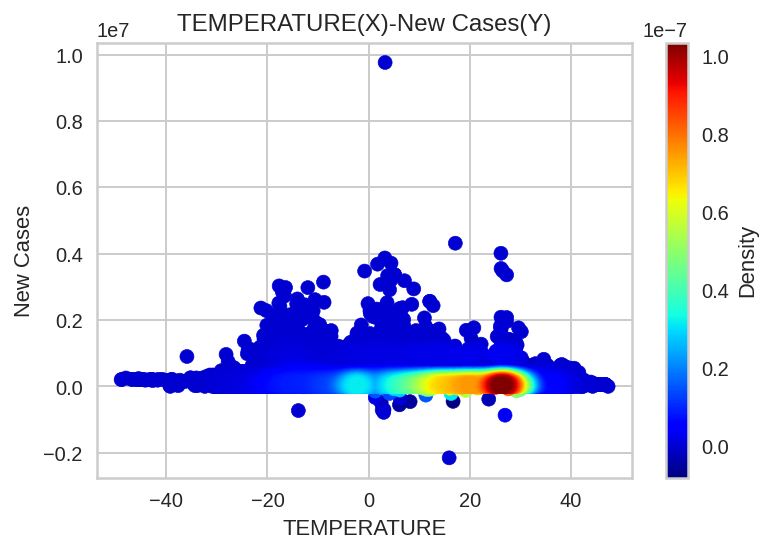

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['TEMPERATURE']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("TEMPERATURE(X)-New Cases(Y)")
    plt.xlabel("TEMPERATURE")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases

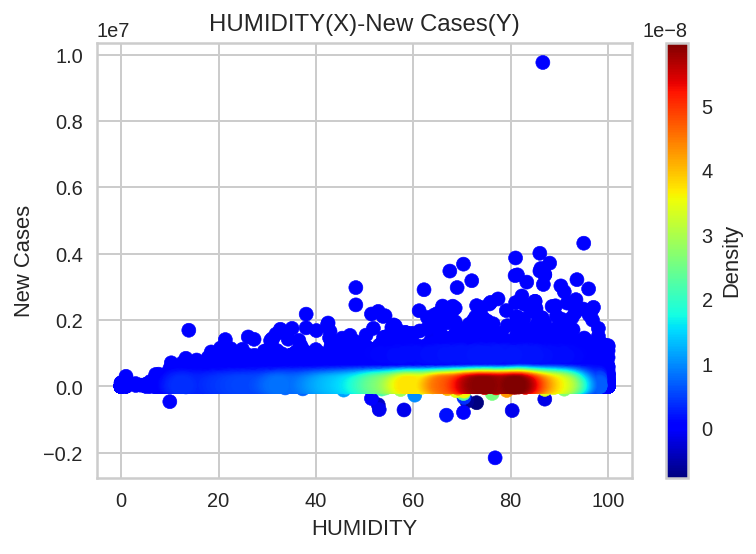

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['HUMIDITY']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("HUMIDITY(X)-New Cases(Y)")
    plt.xlabel("HUMIDITY")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases

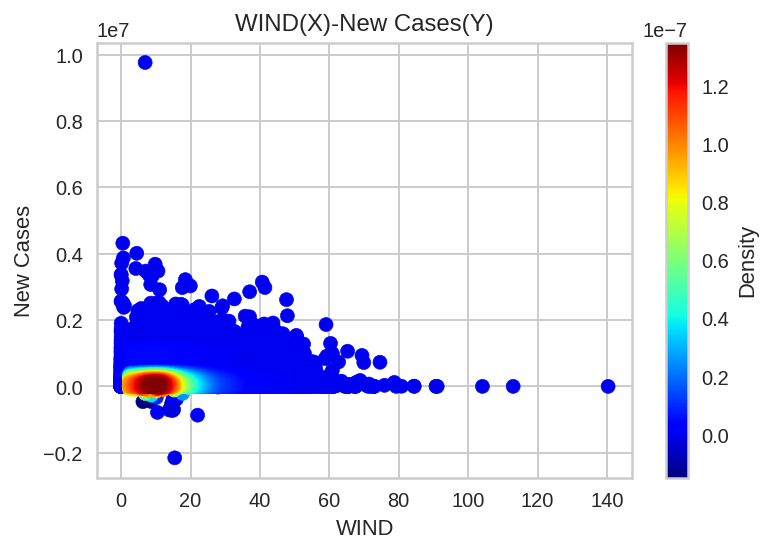

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['WIND']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("WIND(X)-New Cases(Y)")
    plt.xlabel("WIND")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases

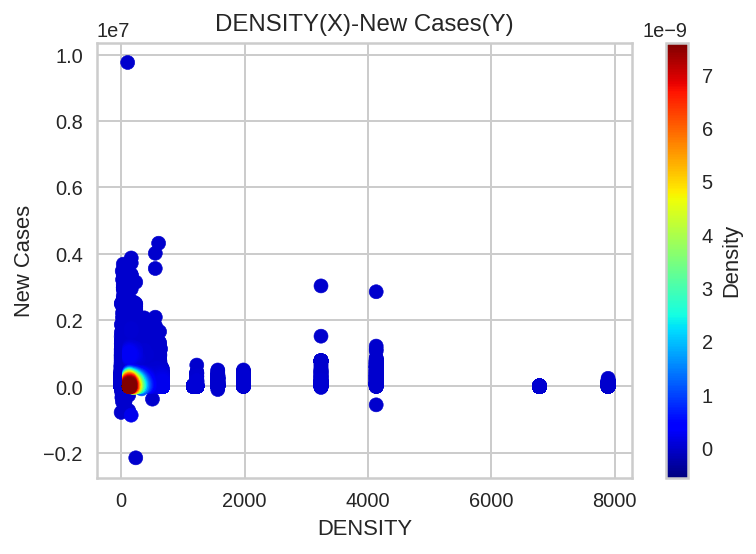

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['DENSITY']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("DENSITY(X)-New Cases(Y)")
    plt.xlabel("DENSITY")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases

In [ ]:
fullCOVIDtable = pd.read_csv('/content/drive/MyDrive/covid-19/fullCOVIDtable.csv', sep=';')#check point
fullCOVIDtable=fullCOVIDtable.drop(columns='id')
fullCOVIDtable=fullCOVIDtable.drop(columns='SCHOOL')
fullCOVIDtable=fullCOVIDtable.drop(columns='WORK')
fullCOVIDtable=fullCOVIDtable.drop(columns='EVENTS')
fullCOVIDtable=fullCOVIDtable.drop(columns='GATHERINGS')
fullCOVIDtable=fullCOVIDtable.drop(columns='TRANSPORTATION')
fullCOVIDtable=fullCOVIDtable.drop(columns='ATHOME')
fullCOVIDtable=fullCOVIDtable.drop(columns='NATIONAL')
fullCOVIDtable=fullCOVIDtable.drop(columns='INTERNATIONAL')
fullCOVIDtable=fullCOVIDtable.drop(columns='INFORMATION')
fullCOVIDtable=fullCOVIDtable.drop(columns='TESTING')
fullCOVIDtable=fullCOVIDtable.drop(columns='TRACING')
fullCOVIDtable=fullCOVIDtable.drop(columns='OLD')
fullCOVIDtable=fullCOVIDtable.drop(columns='YOUNG')
fullCOVIDtable=fullCOVIDtable.drop(columns='URBAN')
#fullCOVIDtable=fullCOVIDtable.drop(columns='DENSITY')
#fullCOVIDtable=fullCOVIDtable.drop(columns='POPULATION')
fullCOVIDtable=fullCOVIDtable.drop(columns='PHYSICIANS')
fullCOVIDtable=fullCOVIDtable.drop(columns='BEDS')
fullCOVIDtable=fullCOVIDtable.drop(columns='REFF')
fullCOVIDtable=fullCOVIDtable.drop(columns='INFECTED')
fullCOVIDtable=fullCOVIDtable.drop(columns='INFECTEDINCREASE')
fullCOVIDtable=fullCOVIDtable.drop(columns='MORTALITY')
fullCOVIDtable=fullCOVIDtable.drop(columns='FATALITYINCREASE')
fullCOVIDtable=fullCOVIDtable.drop(columns='FLIGHTEVOLUTION')
fullCOVIDtable=fullCOVIDtable.drop(columns='19FLIGHTS')
fullCOVIDtable=fullCOVIDtable.drop(columns='20FLIGHTS')
fullCOVIDtable=fullCOVIDtable.drop(columns='19MWHDemand')
fullCOVIDtable=fullCOVIDtable.drop(columns='20MWHDemand')
fullCOVIDtable=fullCOVIDtable.drop(columns='YOYELEC')
fullCOVIDtable=fullCOVIDtable.drop(columns='New Deaths')
fullCOVIDtable=fullCOVIDtable.drop(columns='Deaths')
#fullCOVIDtable=fullCOVIDtable.drop(columns='COUNTRY')
fullCOVIDtable=fullCOVIDtable.drop(columns='DAY')
fullCOVIDtable=fullCOVIDtable.drop(columns='CONTINENT')
#fullCOVIDtable=fullCOVIDtable.drop(columns='DATE')
fullCOVIDtable=fullCOVIDtable.drop(columns='Cases')

fullCOVIDtable=fullCOVIDtable.dropna(how='all')
fullCOVIDtable=fullCOVIDtable.dropna(subset=['New Cases'])
fullCOVIDtable=fullCOVIDtable.dropna(subset=['POPULATION'])
#drop the columns which have the redundant features compare to another column.
#drop the column which have the unnecessary features. Finally, the features we need are weather factor feature, daily new cases feature and country poulation feature. 
#drop the rows which have NaN in New Cases and POPULATION columns.
fullCOVIDtable

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND        DATE
71           Aruba    624.0    106766.0  ...      68.7  26.232307  2020-03-13
72           Aruba    624.0    106766.0  ...      70.3  21.404275  2020-03-14
73           Aruba    624.0    106766.0  ...      69.9  20.921472  2020-03-15
74           Aruba    624.0    106766.0  ...      70.5  23.335488  2020-03-16
75           Aruba    624.0    106766.0  ...      65.0  22.369882  2020-03-17
...            ...      ...         ...  ...       ...        ...         ...
143002  US-Wyoming      NaN    578759.0  ...      56.7  22.208947  2020-12-27
143003  US-Wyoming      NaN    578759.0  ...      89.3  20.599603  2020-12-28
143004  US-Wyoming      NaN    578759.0  ...      81.2  19.794931  2020-12-29
143005  US-Wyoming      NaN    578759.0  ...      46.9  16.898112  2020-12-30
143006  US-Wyoming      NaN    578759.0  ...      52.3  15.127834  2020-12-31

[117260 rows x 8 columns]

In [ ]:
fullCOVIDtable['month'] = pd.DatetimeIndex(fullCOVIDtable['DATE']).month
fullCOVIDtable=fullCOVIDtable.drop(columns='DATE')
fullCOVIDtable

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  month
71           Aruba    624.0    106766.0  ...      68.7  26.232307      3
72           Aruba    624.0    106766.0  ...      70.3  21.404275      3
73           Aruba    624.0    106766.0  ...      69.9  20.921472      3
74           Aruba    624.0    106766.0  ...      70.5  23.335488      3
75           Aruba    624.0    106766.0  ...      65.0  22.369882      3
...            ...      ...         ...  ...       ...        ...    ...
143002  US-Wyoming      NaN    578759.0  ...      56.7  22.208947     12
143003  US-Wyoming      NaN    578759.0  ...      89.3  20.599603     12
143004  US-Wyoming      NaN    578759.0  ...      81.2  19.794931     12
143005  US-Wyoming      NaN    578759.0  ...      46.9  16.898112     12
143006  US-Wyoming      NaN    578759.0  ...      52.3  15.127834     12

[117260 rows x 8 columns]

In [ ]:
tempdffff=fullCOVIDtable.loc[(fullCOVIDtable['New Cases'] > 0)]
#Only the rows which have the new cases value higer than 0 will use to do the data mining.

In [ ]:
tempdffff['New Cases'] = tempdffff['New Cases']/tempdffff['POPULATION']
tempdffff

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  month
75           Aruba    624.0    106766.0  ...      65.0  22.369882      3
76           Aruba    624.0    106766.0  ...      67.0  22.852685      3
78           Aruba    624.0    106766.0  ...      69.5  27.358848      3
80           Aruba    624.0    106766.0  ...      69.8  26.393242      3
82           Aruba    624.0    106766.0  ...      69.0  30.738470      3
...            ...      ...         ...  ...       ...        ...    ...
143002  US-Wyoming      NaN    578759.0  ...      56.7  22.208947     12
143003  US-Wyoming      NaN    578759.0  ...      89.3  20.599603     12
143004  US-Wyoming      NaN    578759.0  ...      81.2  19.794931     12
143005  US-Wyoming      NaN    578759.0  ...      46.9  16.898112     12
143006  US-Wyoming      NaN    578759.0  ...      52.3  15.127834     12

[91709 rows x 8 columns]

In [ ]:
tempdff=tempdffff

In [ ]:
tempdff['DENSITY']=tempdff['DENSITY'].interpolate(limit_direction='both')
tempdff['New Cases']=tempdff['New Cases'].interpolate(limit_direction='both')
tempdff['TEMPERATURE']=tempdff['TEMPERATURE'].interpolate(limit_direction='both')
tempdff['HUMIDITY']=tempdff['HUMIDITY'].interpolate(limit_direction='both')
tempdff['WIND']=tempdff['WIND'].interpolate(limit_direction='both')
#replacing NaN with reasonable value by interpolation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
tempdff=tempdff.reset_index(drop=True, inplace=False)
#reset index

In [ ]:
tempdff['New Cases'] = tempdff['New Cases'].apply(lambda x: x*1000000000)
#convert all the decimal to be the interger for acurate calculation

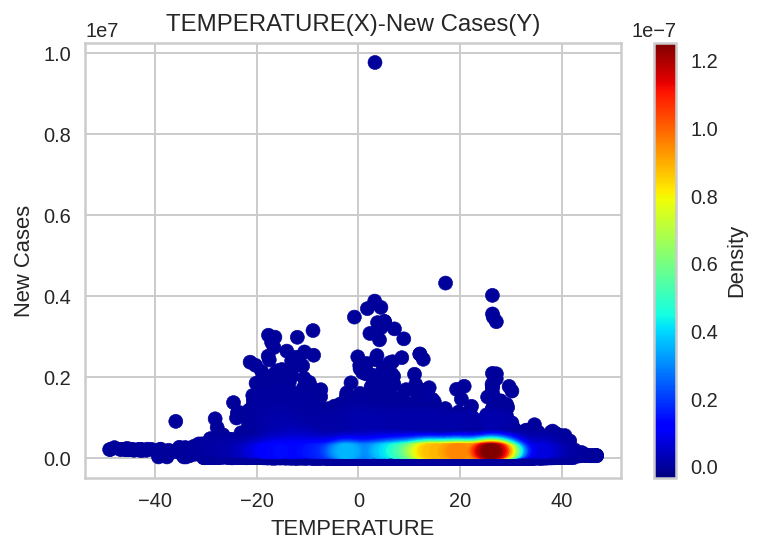

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['TEMPERATURE']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("TEMPERATURE(X)-New Cases(Y)")
    plt.xlabel("TEMPERATURE")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases.
#There are some outliers we need to get rid off.

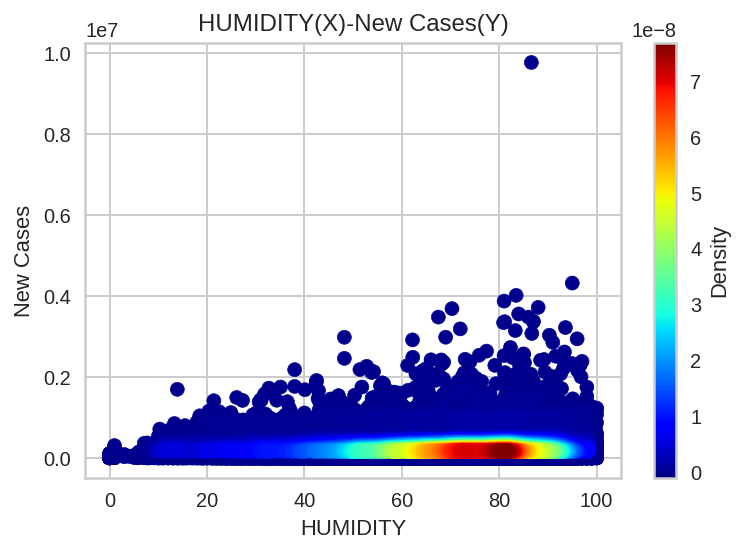

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['HUMIDITY']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("HUMIDITY(X)-New Cases(Y)")
    plt.xlabel("HUMIDITY")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases.
#There are some outliers we need to get rid off.

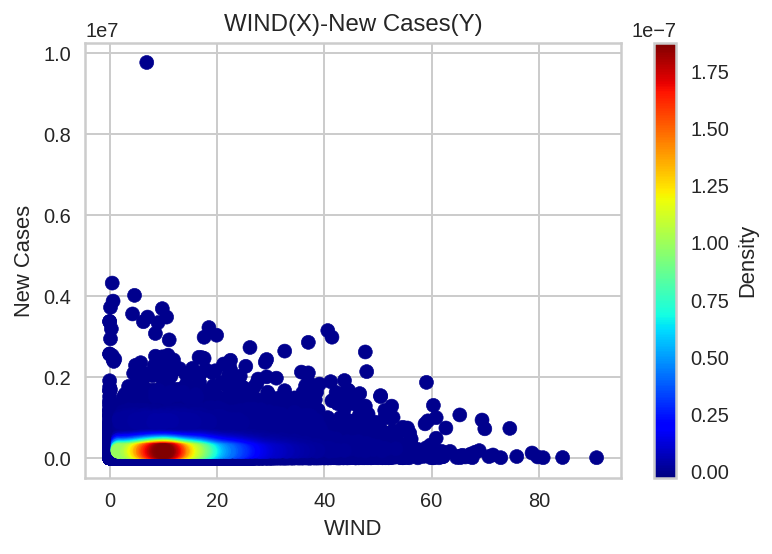

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['WIND']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("WIND(X)-New Cases(Y)")
    plt.xlabel("WIND")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases.
#There are some outliers we need to get rid off.

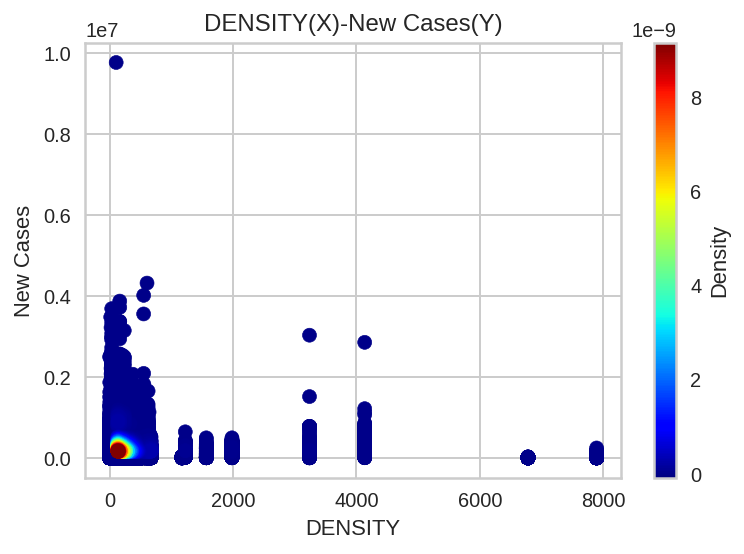

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['DENSITY']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("DENSITY(X)-New Cases(Y)")
    plt.xlabel("DENSITY")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases.
#There are some outliers we need to get rid off.

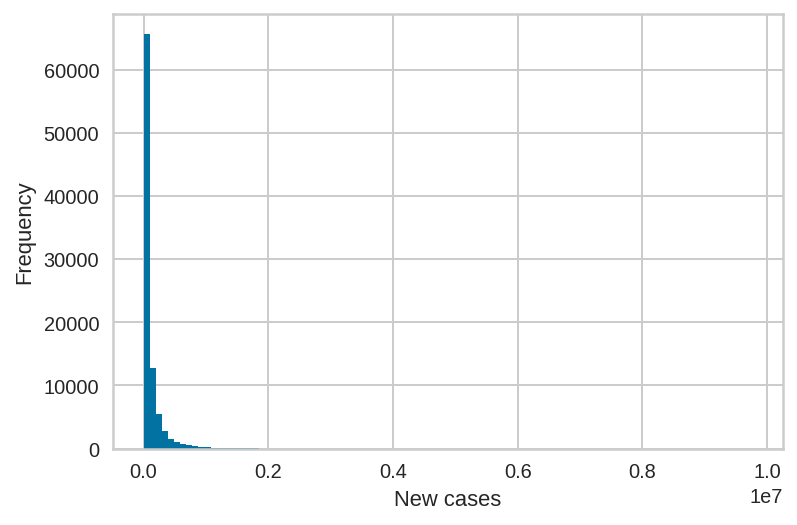

In [ ]:
%matplotlib inline

np.random.seed(42)
x = tempdff['New Cases']

plt.hist(x, density=False, bins=100)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('New cases');
#create the histogram

In [ ]:
freq = tempdff['New Cases'].value_counts()
fyyyyz=freq.iloc[0:20]
fyyyyz
#print the top 20 of new cases values most occurring in the covid-19 stat dataset.

27.104520       73
41.987213       69
9.587440        68
194.931774      68
3479.822251     66
12.434996       61
378.917055      59
77.290361       57
43.442094       55
19791.790365    55
28.001705       55
1918.042063     52
10.273419       51
28.762319       49
207.372808      48
1282.062788     48
1295.988139     46
23758.612497    45
305.036891      45
414.745617      43
Name: New Cases, dtype: int64

In [ ]:
cols = ['New Cases'] # one or more

Q1 = tempdff[cols].quantile(0)
Q3 = tempdff[cols].quantile(0.95)
IQR = Q3 - Q1

tempdff = tempdff[~((tempdff[cols] < (Q1 - 1.5 * IQR)) |(tempdff[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
#drop the records which have the new cases value that are 5% of the maximum value.

In [ ]:
tempdff=tempdff.reset_index(drop=True, inplace=False)
#reset index

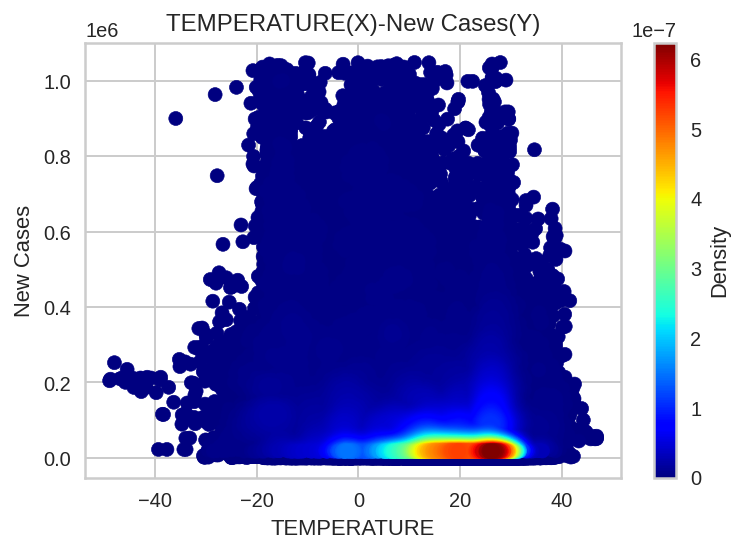

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['TEMPERATURE']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("TEMPERATURE(X)-New Cases(Y)")
    plt.xlabel("TEMPERATURE")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases after dropping all the outliers.

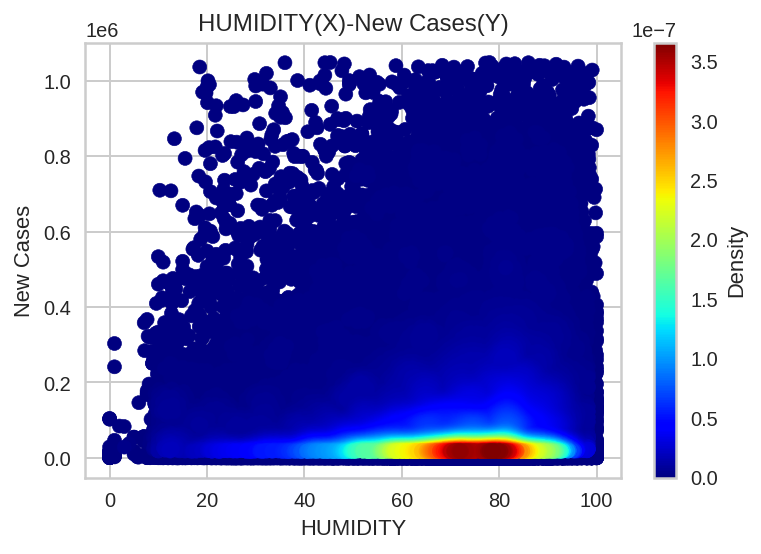

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['HUMIDITY']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("HUMIDITY(X)-New Cases(Y)")
    plt.xlabel("HUMIDITY")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases after dropping all the outliers.

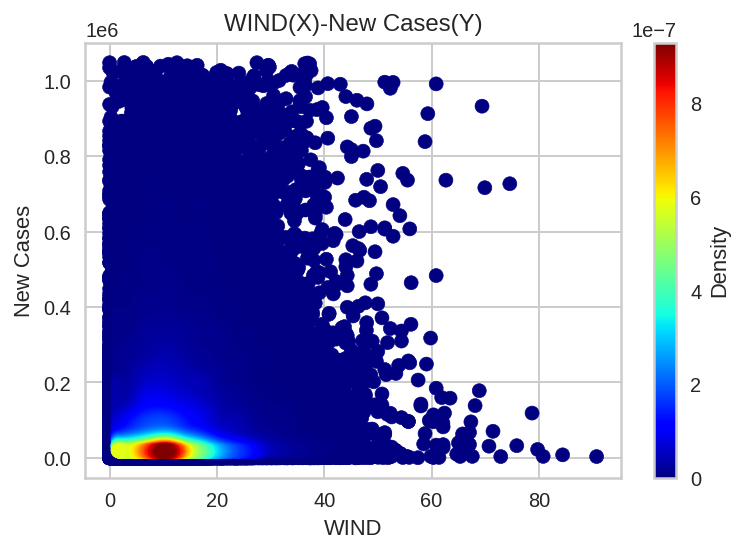

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['WIND']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("WIND(X)-New Cases(Y)")
    plt.xlabel("WIND")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases after dropping all the outliers.

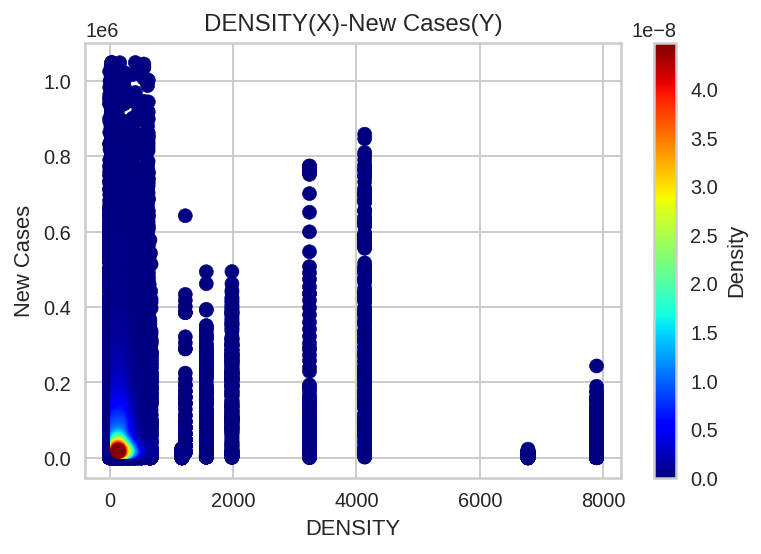

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=plt.cm.jet), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :

    x = tempdff['DENSITY']
    y = tempdff['New Cases']
    density_scatter( x, y, bins = [30,30], cmap=plt.cm.jet)

    plt.title("DENSITY(X)-New Cases(Y)")
    plt.xlabel("DENSITY")
    plt.ylabel("New Cases")
    plt.show
#create the scatter plot of the data relationship between weather facter and new cases after dropping all the outliers.

In [ ]:
tempdff.to_csv (r'tempdff.csv', index = False, header=True)
!cp tempdff.csv "drive/My Drive/covid-19"
tempdff=pd.read_csv('/content/drive/MyDrive/covid-19/tempdff.csv')#check point

In [ ]:
tempdff.to_csv (r'temptempdff.csv', index = False, header=True)
!cp temptempdff.csv "drive/My Drive/covid-19"
tempdff=pd.read_csv('/content/drive/MyDrive/covid-19/temptempdff.csv')#check point

In [ ]:
tempdff=pd.read_csv('/content/drive/MyDrive/covid-19/tempdff.csv')#check point
tempdff

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  month
0           Aruba    624.0    106766.0  ...      65.0  22.369882      3
1           Aruba    624.0    106766.0  ...      67.0  22.852685      3
2           Aruba    624.0    106766.0  ...      69.5  27.358848      3
3           Aruba    624.0    106766.0  ...      69.8  26.393242      3
4           Aruba    624.0    106766.0  ...      69.0  30.738470      3
...           ...      ...         ...  ...       ...        ...    ...
91164  US-Wyoming     34.0    578759.0  ...      56.7  22.208947     12
91165  US-Wyoming     34.0    578759.0  ...      89.3  20.599603     12
91166  US-Wyoming     34.0    578759.0  ...      81.2  19.794931     12
91167  US-Wyoming     34.0    578759.0  ...      46.9  16.898112     12
91168  US-Wyoming     34.0    578759.0  ...      52.3  15.127834     12

[91169 rows x 8 columns]

In [ ]:
tempdfyyyy=tempdff

In [ ]:
tempdfyyyy['Flag']='GOOD'

i=0
while i<len(tempdfyyyy):
  if i==(len(tempdfyyyy)-1):
    break
  elif i == 0:
    #tempdfyyyy['Flag'][i] = 'GOOD'
    if tempdfyyyy['New Cases'][i]<=1000:
        if ((tempdfyyyy['New Cases'][i+1] - tempdfyyyy['New Cases'][i])>1000):
          tempdfyyyy['Flag'][i+1] = 'BAD'
        else:
          tempdfyyyy['Flag'][i+1] = 'GOOD'
    else:
      if ((tempdfyyyy['New Cases'][i+1] - tempdfyyyy['New Cases'][i])>=0):
        tempdfyyyy['Flag'][i+1] = 'BAD'
      else:
        tempdfyyyy['Flag'][i+1] = 'GOOD'
  else:
      if tempdfyyyy['New Cases'][i]>=10000 and tempdfyyyy['New Cases'][i+1]>=10000:
        tempdfyyyy['Flag'][i+1] = 'BAD'
      else:
        if tempdfyyyy['New Cases'][i]<=1000:
          if ((tempdfyyyy['New Cases'][i+1] - tempdfyyyy['New Cases'][i])>=1000):
            tempdfyyyy['Flag'][i+1] = 'BAD'
          else:
            tempdfyyyy['Flag'][i+1] = 'GOOD'
        else:
          if ((tempdfyyyy['New Cases'][i+1] - tempdfyyyy['New Cases'][i])>=0):
            tempdfyyyy['Flag'][i+1] = 'BAD'
          else:
            tempdfyyyy['Flag'][i+1] = 'GOOD'
  i = i + 1

tempdfyyyy.to_csv (r'binodfmonth.csv', index = False, header=True)
!cp binodfmonth.csv "drive/My Drive/covid-19"

tempdfyyyy
#Create the label for new cases feature in order to do the binary classification

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is tryi

COUNTRY  DENSITY  POPULATION  ...       WIND  month  Flag
0           Aruba    624.0    106766.0  ...  22.369882      3  GOOD
1           Aruba    624.0    106766.0  ...  22.852685      3   BAD
2           Aruba    624.0    106766.0  ...  27.358848      3   BAD
3           Aruba    624.0    106766.0  ...  26.393242      3   BAD
4           Aruba    624.0    106766.0  ...  30.738470      3   BAD
...           ...      ...         ...  ...        ...    ...   ...
91164  US-Wyoming     34.0    578759.0  ...  22.208947     12   BAD
91165  US-Wyoming     34.0    578759.0  ...  20.599603     12   BAD
91166  US-Wyoming     34.0    578759.0  ...  19.794931     12   BAD
91167  US-Wyoming     34.0    578759.0  ...  16.898112     12   BAD
91168  US-Wyoming     34.0    578759.0  ...  15.127834     12   BAD

[91169 rows x 9 columns]

In [ ]:
dddff=pd.read_csv('/content/drive/MyDrive/covid-19/temptempdff.csv')#check point
#tempdfyyyy=dddff.iloc[0:10]
tempdfyyyy=dddff
tempdfyyyy

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  month
0           Aruba    624.0    106766.0  ...      65.0  22.369882      3
1           Aruba    624.0    106766.0  ...      67.0  22.852685      3
2           Aruba    624.0    106766.0  ...      69.5  27.358848      3
3           Aruba    624.0    106766.0  ...      69.8  26.393242      3
4           Aruba    624.0    106766.0  ...      69.0  30.738470      3
...           ...      ...         ...  ...       ...        ...    ...
91164  US-Wyoming     34.0    578759.0  ...      56.7  22.208947     12
91165  US-Wyoming     34.0    578759.0  ...      89.3  20.599603     12
91166  US-Wyoming     34.0    578759.0  ...      81.2  19.794931     12
91167  US-Wyoming     34.0    578759.0  ...      46.9  16.898112     12
91168  US-Wyoming     34.0    578759.0  ...      52.3  15.127834     12

[91169 rows x 8 columns]

In [ ]:
quarter=pd.read_csv('/content/drive/MyDrive/covid-19/binodfmonth.csv')
quarter

COUNTRY  DENSITY  POPULATION  ...       WIND  month  Flag
0           Aruba    624.0    106766.0  ...  22.369882      3  GOOD
1           Aruba    624.0    106766.0  ...  22.852685      3   BAD
2           Aruba    624.0    106766.0  ...  27.358848      3   BAD
3           Aruba    624.0    106766.0  ...  26.393242      3   BAD
4           Aruba    624.0    106766.0  ...  30.738470      3   BAD
...           ...      ...         ...  ...        ...    ...   ...
91164  US-Wyoming     34.0    578759.0  ...  22.208947     12   BAD
91165  US-Wyoming     34.0    578759.0  ...  20.599603     12   BAD
91166  US-Wyoming     34.0    578759.0  ...  19.794931     12   BAD
91167  US-Wyoming     34.0    578759.0  ...  16.898112     12   BAD
91168  US-Wyoming     34.0    578759.0  ...  15.127834     12   BAD

[91169 rows x 9 columns]

In [ ]:
dfforplot=pd.read_csv('/content/drive/MyDrive/covid-19/binodfmonth.csv')
dfforplot=dfforplot.drop(columns='month')
dfforplot.to_csv (r'binodf.csv', index = False, header=True)
!cp binodf.csv "drive/My Drive/covid-19"
dfforplot

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  Flag
0           Aruba    624.0    106766.0  ...      65.0  22.369882  GOOD
1           Aruba    624.0    106766.0  ...      67.0  22.852685   BAD
2           Aruba    624.0    106766.0  ...      69.5  27.358848   BAD
3           Aruba    624.0    106766.0  ...      69.8  26.393242   BAD
4           Aruba    624.0    106766.0  ...      69.0  30.738470   BAD
...           ...      ...         ...  ...       ...        ...   ...
91164  US-Wyoming     34.0    578759.0  ...      56.7  22.208947   BAD
91165  US-Wyoming     34.0    578759.0  ...      89.3  20.599603   BAD
91166  US-Wyoming     34.0    578759.0  ...      81.2  19.794931   BAD
91167  US-Wyoming     34.0    578759.0  ...      46.9  16.898112   BAD
91168  US-Wyoming     34.0    578759.0  ...      52.3  15.127834   BAD

[91169 rows x 8 columns]

In [8]:
dfforplot=pd.read_csv('/content/drive/MyDrive/covid-19/binodf.csv')
dfforplot

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  Flag
0           Aruba    624.0    106766.0  ...      65.0  22.369882  GOOD
1           Aruba    624.0    106766.0  ...      67.0  22.852685   BAD
2           Aruba    624.0    106766.0  ...      69.5  27.358848   BAD
3           Aruba    624.0    106766.0  ...      69.8  26.393242   BAD
4           Aruba    624.0    106766.0  ...      69.0  30.738470   BAD
...           ...      ...         ...  ...       ...        ...   ...
91164  US-Wyoming     34.0    578759.0  ...      56.7  22.208947   BAD
91165  US-Wyoming     34.0    578759.0  ...      89.3  20.599603   BAD
91166  US-Wyoming     34.0    578759.0  ...      81.2  19.794931   BAD
91167  US-Wyoming     34.0    578759.0  ...      46.9  16.898112   BAD
91168  US-Wyoming     34.0    578759.0  ...      52.3  15.127834   BAD

[91169 rows x 8 columns]

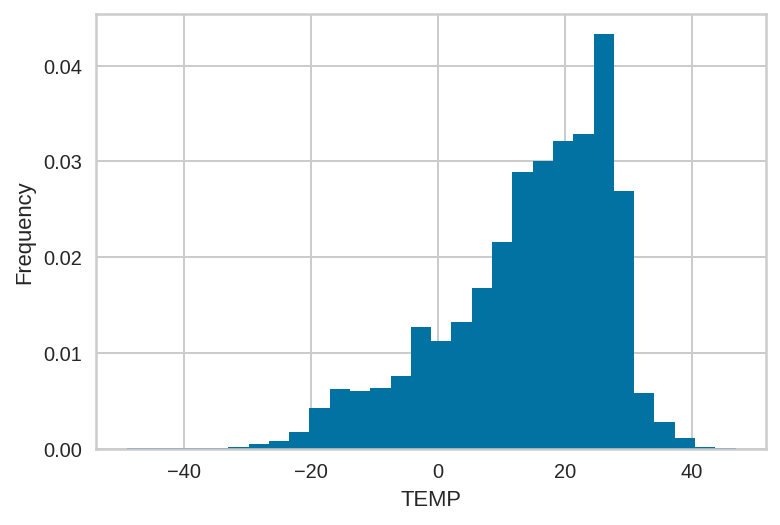

In [ ]:
%matplotlib inline
np.random.seed(42)
x = dfforplot['TEMPERATURE']
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('TEMP');
#create the histogram of weather factor

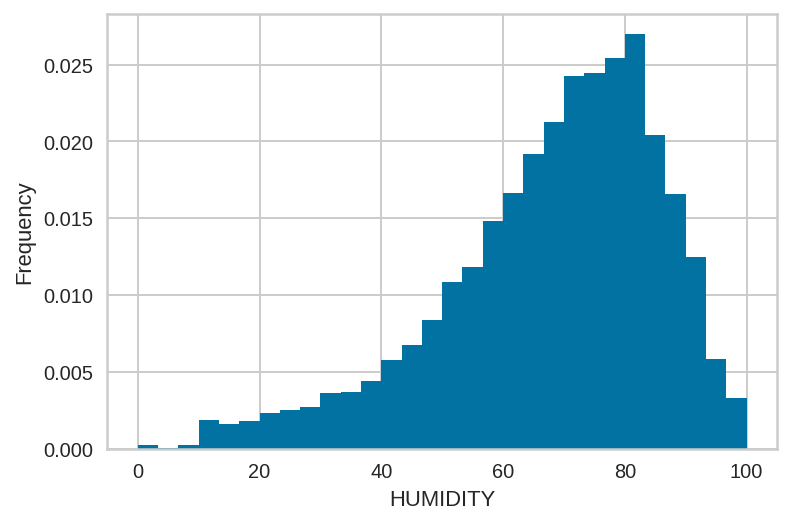

In [ ]:
%matplotlib inline
np.random.seed(42)
x = dfforplot['HUMIDITY']
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('HUMIDITY');
#create the histogram of weather factor

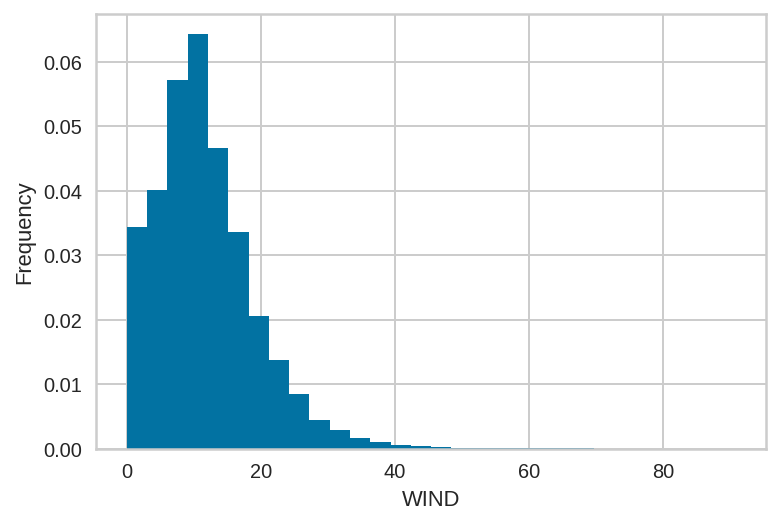

In [ ]:
%matplotlib inline
np.random.seed(42)
x = dfforplot['WIND']
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('WIND');
#create the histogram of weather factor

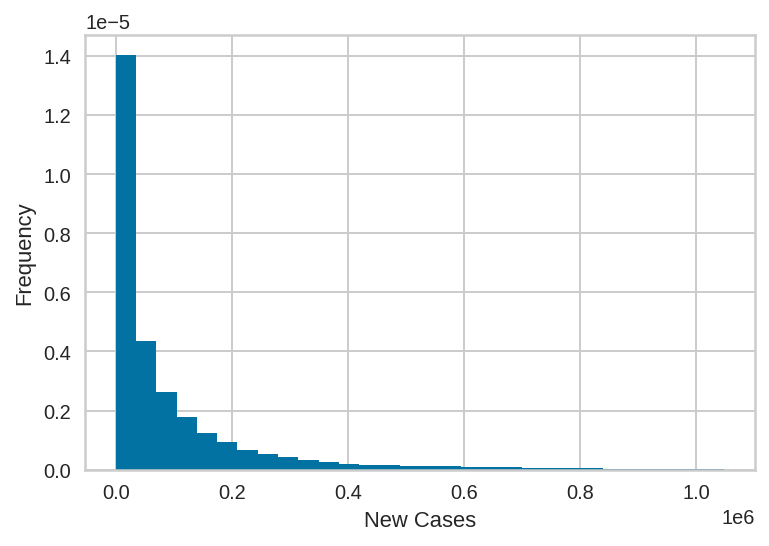

In [ ]:
%matplotlib inline
np.random.seed(42)
x = dfforplot['New Cases']
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('New Cases');
#create the histogram of weather factor

In [ ]:
dfforplot.var()
#print the variance of all the features.

DENSITY        4.920115e+05
POPULATION     1.554608e+16
New Cases      2.176402e+10
TEMPERATURE    1.720756e+02
HUMIDITY       3.248329e+02
WIND           5.672051e+01
dtype: float64

In [ ]:
px.scatter_3d(dfforplot, x="TEMPERATURE", y="HUMIDITY", z="WIND", 
              color="Flag", color_discrete_map = {"Joly": "blue", "Bergeron": "violet", "Coderre":"pink"})
#create scatter plot to represent the relationship between all the weather factors with flag labels.
#The relationship is very complicated. it is non linear and also non polynomial.
#Using random forest classifier will not rely on the relationship of the features. 
#Random forest classifier that is the algorithm based on decision tree will use the feature condition to predict the label...
#which is suitable to analyse the relationship between weather factors and new daily covid-19 cases.

Output hidden; open in https://colab.research.google.com to view.

In [10]:
px.scatter_3d(dfforplot, x="TEMPERATURE", y="HUMIDITY", z="New Cases", 
              color="Flag", color_discrete_map = {"Joly": "blue", "Bergeron": "violet", "Coderre":"pink"})
#create scatter plot to represent the relationship between all the weather factors with new cases.
#The relationship is very complicated. it is non linear and also non polynomial.
#Using random forest classifier will not rely on the relationship of the features. 
#Random forest classifier that is the algorithm based on decision tree will use the feature condition to predict the label...
#which is suitable to analyse the relationship between weather factors and new daily covid-19 cases.

Output hidden; open in https://colab.research.google.com to view.

In [11]:
px.scatter_3d(dfforplot, x="TEMPERATURE", y="WIND", z="New Cases", 
              color="Flag", color_discrete_map = {"Joly": "blue", "Bergeron": "violet", "Coderre":"pink"})
#create scatter plot to represent the relationship between all the weather factors with new cases.
#The relationship is very complicated. it is non linear and also non polynomial.
#Using random forest classifier will not rely on the relationship of the features. 
#Random forest classifier that is the algorithm based on decision tree will use the feature condition to predict the label...
#which is suitable to analyse the relationship between weather factors and new daily covid-19 cases.

Output hidden; open in https://colab.research.google.com to view.

In [66]:
dfforplot=pd.read_csv('/content/drive/MyDrive/covid-19/binodf.csv')
dfforplot

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  Flag
0           Aruba    624.0    106766.0  ...      65.0  22.369882  GOOD
1           Aruba    624.0    106766.0  ...      67.0  22.852685   BAD
2           Aruba    624.0    106766.0  ...      69.5  27.358848   BAD
3           Aruba    624.0    106766.0  ...      69.8  26.393242   BAD
4           Aruba    624.0    106766.0  ...      69.0  30.738470   BAD
...           ...      ...         ...  ...       ...        ...   ...
91164  US-Wyoming     34.0    578759.0  ...      56.7  22.208947   BAD
91165  US-Wyoming     34.0    578759.0  ...      89.3  20.599603   BAD
91166  US-Wyoming     34.0    578759.0  ...      81.2  19.794931   BAD
91167  US-Wyoming     34.0    578759.0  ...      46.9  16.898112   BAD
91168  US-Wyoming     34.0    578759.0  ...      52.3  15.127834   BAD

[91169 rows x 8 columns]

In [67]:
print("Global")
print("Temperature's pearson = "+str(dfforplot['New Cases'].corr(dfforplot['TEMPERATURE'],method='pearson')))
print("Temperature's spearman = "+str(dfforplot['New Cases'].corr(dfforplot['TEMPERATURE'],method='spearman')))
print("Humidity's pearson = "+str(dfforplot['New Cases'].corr(dfforplot['HUMIDITY'],method='pearson')))
print("Humidity's spearman = "+str(dfforplot['New Cases'].corr(dfforplot['HUMIDITY'],method='spearman')))
print("Wind's pearson = "+str(dfforplot['New Cases'].corr(dfforplot['WIND'],method='pearson')))
print("Wind's spearman = "+str(dfforplot['New Cases'].corr(dfforplot['WIND'],method='spearman')))
#calculate pearson and spearman coorelation coefficient.

Global
Temperature's pearson = -0.23642387017681818
Temperature's spearman = -0.19474622891663193
Humidity's pearson = 0.06203534856896508
Humidity's spearman = 0.05651712148893541
Wind's pearson = 0.11114363080768296
Wind's spearman = 0.09290682634790932


In [68]:
featureCauseOnlyWeather = ["TEMPERATURE", "HUMIDITY", "WIND"]
featureEffect = ["Flag"]
#define the cause and effect features for Random forest classifier.

In [69]:
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(dfforplot[featureCauseOnlyWeather], dfforplot[featureEffect], test_size=0.3, random_state=42)
#create train and test dataset. The proportion of our trainig data is 70% and testing data is 30%.

In [110]:
randomForestClassifierObjOnlyWeather = RandomForestClassifier(random_state=42)
randomForestClassifierObjOnlyWeather.fit (xTrain2, yTrain2)
importancesOnlyWeather = list(randomForestClassifierObjOnlyWeather.feature_importances_)
#training random forest classifier model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [111]:
print("Random forest classifier importance scores of selected features-cause Only weather")
i = 0
while i<len(featureCauseOnlyWeather):
    if i != 2:
        print(str(featureCauseOnlyWeather[i])+"\t:\t"+str(round(importancesOnlyWeather[i], 2)))
    else:
        print(str(featureCauseOnlyWeather[i])+"\t\t:\t"+str(round(importancesOnlyWeather[i], 2)))
    i = i + 1
#retrieve the weather factor feature importance score.

Random forest classifier importance scores of selected features-cause Only weather
TEMPERATURE	:	0.38
HUMIDITY	:	0.35
WIND		:	0.27


In [112]:
print("Random forest classifier mean accuracy for temperature, humidity, wind in training")
randomForestClassifierObjOnlyWeather.score(xTrain2, yTrain2)

Random forest classifier mean accuracy for temperature, humidity, wind in training


0.9971794791438152

[[9.99222457e-01 7.77542964e-04]
 [1.03221083e-02 9.89677892e-01]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



Text(0.5, 1.0, 'Random forest classifier Accuracy for temperature, humidity, wind in Training')

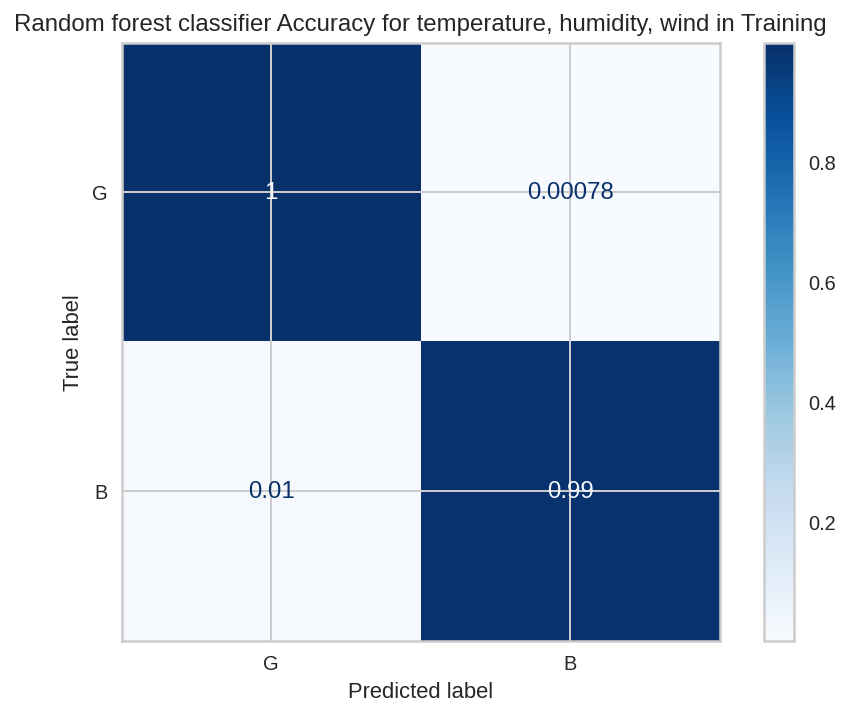

In [113]:
predictions=randomForestClassifierObjOnlyWeather.predict(xTrain2)
conf_mat = confusion_matrix(yTrain2, predictions, normalize='true')
print(conf_mat)
disp = plot_confusion_matrix(randomForestClassifierObjOnlyWeather, xTrain2, yTrain2,display_labels="GB", cmap=plt.cm.Blues, normalize='true')
plt.title("Random forest classifier Accuracy for temperature, humidity, wind in Training")

In [114]:
print("Random forest classifier mean accuracy for temperature, humidity, wind in testing")
randomForestClassifierObjOnlyWeather.score(xTest2, yTest2)

Random forest classifier mean accuracy for temperature, humidity, wind in testing


0.790830316990238

[[0.95344811 0.04655189]
 [0.79069767 0.20930233]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



Text(0.5, 1.0, 'Random forest classifier Accuracy for temperature, humidity, wind in Testing')

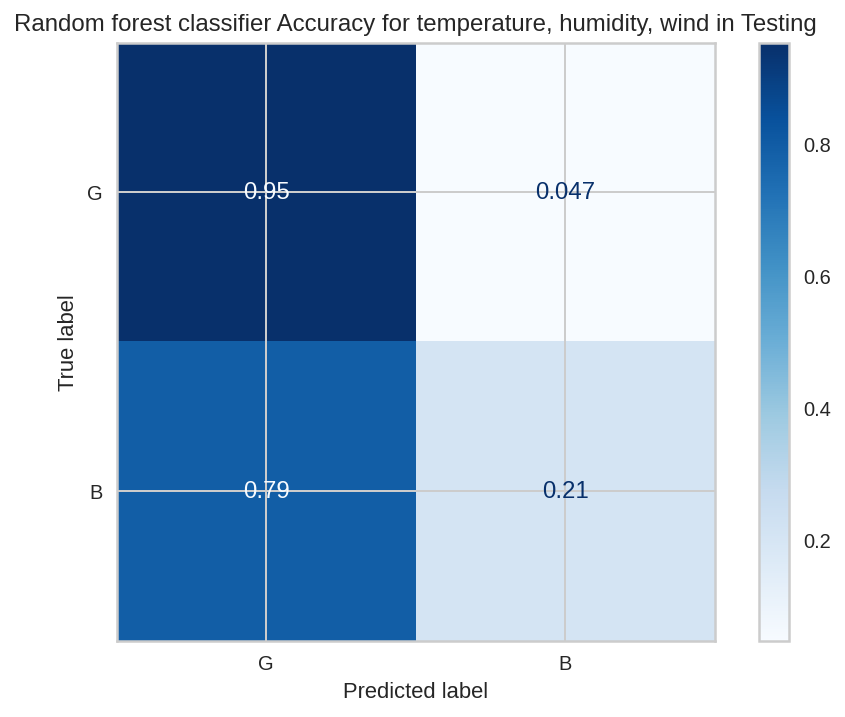

In [115]:
predictions=randomForestClassifierObjOnlyWeather.predict(xTest2)
conf_mat = confusion_matrix(yTest2, predictions, normalize='true')
print(conf_mat)
disp = plot_confusion_matrix(randomForestClassifierObjOnlyWeather, xTest2, yTest2,display_labels="GB", cmap=plt.cm.Blues, normalize='true')
plt.title("Random forest classifier Accuracy for temperature, humidity, wind in Testing")

In [30]:
tempdff=pd.read_csv('/content/drive/MyDrive/covid-19/binodf.csv')
tempdff

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  Flag
0           Aruba    624.0    106766.0  ...      65.0  22.369882  GOOD
1           Aruba    624.0    106766.0  ...      67.0  22.852685   BAD
2           Aruba    624.0    106766.0  ...      69.5  27.358848   BAD
3           Aruba    624.0    106766.0  ...      69.8  26.393242   BAD
4           Aruba    624.0    106766.0  ...      69.0  30.738470   BAD
...           ...      ...         ...  ...       ...        ...   ...
91164  US-Wyoming     34.0    578759.0  ...      56.7  22.208947   BAD
91165  US-Wyoming     34.0    578759.0  ...      89.3  20.599603   BAD
91166  US-Wyoming     34.0    578759.0  ...      81.2  19.794931   BAD
91167  US-Wyoming     34.0    578759.0  ...      46.9  16.898112   BAD
91168  US-Wyoming     34.0    578759.0  ...      52.3  15.127834   BAD

[91169 rows x 8 columns]

In [31]:
fullCOVIDtable=tempdff
fullCOVIDtable

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  Flag
0           Aruba    624.0    106766.0  ...      65.0  22.369882  GOOD
1           Aruba    624.0    106766.0  ...      67.0  22.852685   BAD
2           Aruba    624.0    106766.0  ...      69.5  27.358848   BAD
3           Aruba    624.0    106766.0  ...      69.8  26.393242   BAD
4           Aruba    624.0    106766.0  ...      69.0  30.738470   BAD
...           ...      ...         ...  ...       ...        ...   ...
91164  US-Wyoming     34.0    578759.0  ...      56.7  22.208947   BAD
91165  US-Wyoming     34.0    578759.0  ...      89.3  20.599603   BAD
91166  US-Wyoming     34.0    578759.0  ...      81.2  19.794931   BAD
91167  US-Wyoming     34.0    578759.0  ...      46.9  16.898112   BAD
91168  US-Wyoming     34.0    578759.0  ...      52.3  15.127834   BAD

[91169 rows x 8 columns]

In [32]:
featureCauseOnlyWeather = ["TEMPERATURE", "HUMIDITY", "WIND"]
featureEffect = ["New Cases"]
#define the cause and effect features for Random forest classifier.

In [33]:
xTrain3, xTest3, yTrain3, yTest3 = train_test_split(fullCOVIDtable[featureCauseOnlyWeather], fullCOVIDtable[featureEffect], test_size=0.3, random_state=42)
#create train and test dataset. The proportion of our trainig data is 70% and testing data is 30%.

In [43]:
sCaler = MinMaxScaler()
xTrainScaled = sCaler.fit_transform(xTrain3)
xTestScaled = sCaler.transform(xTest3)
sCaler2 = StandardScaler()
yTrainScaled = sCaler2.fit_transform(yTrain3)
yTestScaled = sCaler2.transform(yTest3)

In [44]:
regressMulVarWeatherTrain = LinearRegression().fit(xTrainScaled, yTrainScaled)
#train linear regression model.

In [45]:
print("Linear regression coefficient Train")
print("Temperature, Humidity, Windspeed")
regressMulVarWeatherTrain.coef_

Linear regression coefficient Train
Temperature, Humidity, Windspeed


array([[-1.60050797,  0.18101332,  0.82231994]])

In [46]:
print("Linear regression R^2 train")
print("Score: "+str(regressMulVarWeatherTrain.score(xTrainScaled, yTrainScaled)))

Linear regression R^2 train
Score: 0.061573922842070083


In [47]:
print("Linear regression MAE train")
print("Score: "+str(mean_absolute_error(yTrainScaled, regressMulVarWeatherTrain.predict(xTrainScaled))))

Linear regression MAE train
Score: 0.6321810252312914


In [48]:
regressMulVarWeatherTest = LinearRegression().fit(xTestScaled, yTestScaled)

In [49]:
print("Linear regression coefficient Test")
print("Temperature, Humidity, Windspeed")
regressMulVarWeatherTest.coef_

Linear regression coefficient Test
Temperature, Humidity, Windspeed


array([[-1.55097405,  0.1542358 ,  0.82788078]])

In [50]:
print("Linear regression R^2 test")
print("Score: "+str(regressMulVarWeatherTest.score(xTestScaled, yTestScaled)))

Linear regression R^2 test
Score: 0.059838767065564014


In [51]:
print("Linear regression MAE test")
print("Score: "+str(mean_absolute_error(yTestScaled, regressMulVarWeatherTest.predict(xTestScaled))))

Linear regression MAE test
Score: 0.6285946974492941


In [161]:
tempdff=pd.read_csv('/content/drive/MyDrive/covid-19/binodf.csv')
fullCOVIDtable=tempdff
fullCOVIDtable

COUNTRY  DENSITY  POPULATION  ...  HUMIDITY       WIND  Flag
0           Aruba    624.0    106766.0  ...      65.0  22.369882  GOOD
1           Aruba    624.0    106766.0  ...      67.0  22.852685   BAD
2           Aruba    624.0    106766.0  ...      69.5  27.358848   BAD
3           Aruba    624.0    106766.0  ...      69.8  26.393242   BAD
4           Aruba    624.0    106766.0  ...      69.0  30.738470   BAD
...           ...      ...         ...  ...       ...        ...   ...
91164  US-Wyoming     34.0    578759.0  ...      56.7  22.208947   BAD
91165  US-Wyoming     34.0    578759.0  ...      89.3  20.599603   BAD
91166  US-Wyoming     34.0    578759.0  ...      81.2  19.794931   BAD
91167  US-Wyoming     34.0    578759.0  ...      46.9  16.898112   BAD
91168  US-Wyoming     34.0    578759.0  ...      52.3  15.127834   BAD

[91169 rows x 8 columns]

In [162]:
fullCOVIDtable=fullCOVIDtable.drop(columns='DENSITY')
fullCOVIDtable=fullCOVIDtable.drop(columns='COUNTRY')
fullCOVIDtable=fullCOVIDtable.drop(columns='POPULATION')
fullCOVIDtable=fullCOVIDtable.drop(columns='Flag')
fullCOVIDtable.to_csv (r'fullCOVIDtableOnlyNeedColumn2.csv', index = False, header=True)
!cp fullCOVIDtableOnlyNeedColumn2.csv "drive/My Drive/covid-19"
fullCOVIDtableTrain=pd.read_csv('/content/drive/MyDrive/covid-19/fullCOVIDtableOnlyNeedColumn2.csv')#check point
fullCOVIDtableTrain

New Cases  TEMPERATURE  HUMIDITY       WIND
0        9366.277654    27.500000      65.0  22.369882
1        9366.277654    27.833333      67.0  22.852685
2        9366.277654    27.888889      69.5  27.358848
3       37465.110616    27.722222      69.8  26.393242
4       28098.832962    28.166667      69.0  30.738470
...              ...          ...       ...        ...
91164   93303.084704    -0.333333      56.7  22.208947
91165  870828.790567    -4.555556      89.3  20.599603
91166  378395.843520    -5.444444      81.2  19.794931
91167  362845.329403    -4.833333      46.9  16.898112
91168  476882.432930     0.444444      52.3  15.127834

[91169 rows x 4 columns]

In [9]:
fullCOVIDtableTrain=pd.read_csv('/content/drive/MyDrive/covid-19/fullCOVIDtableOnlyNeedColumn2.csv')#check point
fullCOVIDtableTrain

New Cases  TEMPERATURE  HUMIDITY       WIND
0        9366.277654    27.500000      65.0  22.369882
1        9366.277654    27.833333      67.0  22.852685
2        9366.277654    27.888889      69.5  27.358848
3       37465.110616    27.722222      69.8  26.393242
4       28098.832962    28.166667      69.0  30.738470
...              ...          ...       ...        ...
91164   93303.084704    -0.333333      56.7  22.208947
91165  870828.790567    -4.555556      89.3  20.599603
91166  378395.843520    -5.444444      81.2  19.794931
91167  362845.329403    -4.833333      46.9  16.898112
91168  476882.432930     0.444444      52.3  15.127834

[91169 rows x 4 columns]

In [164]:
fullCOVIDtableTrainArray = fullCOVIDtableTrain.to_numpy()
#convert dataframe to array

In [165]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2 + (points[i, 2] - curr_center[2]) ** 2 + (points[i, 3] - curr_center[3]) ** 2
      
    sse.append(curr_sse)
  return sse

In [166]:
score=calculate_WSS(fullCOVIDtableTrainArray,17)
#run elbow method to find the best k value.

Text(0.5, 1.0, 'Elbow for Temperature, Humidity, Wind')

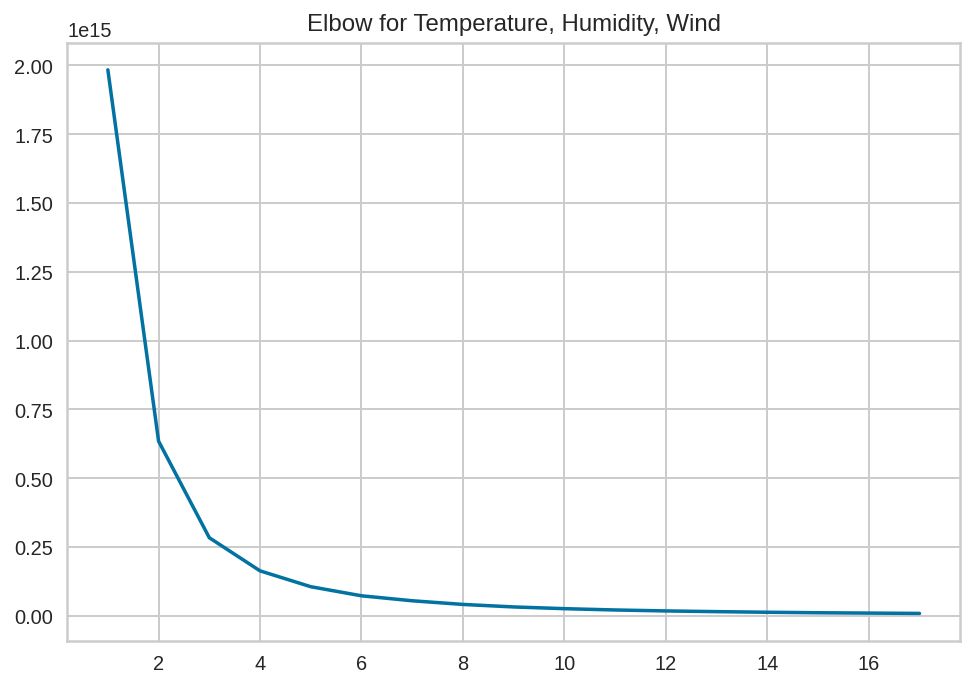

In [167]:
xAxis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
yAxis = score
plt.plot(xAxis, yAxis)
plt.show
plt.title("Elbow for Temperature, Humidity, Wind")
#plot graph of the score from elbow method to find the best k to get the best result from k means clustering.
#the graph is almost saturated at k=10 therefore our best k value for k-means clustering is 10.

In [168]:
model = KMeans(n_clusters=10)
model
#create model for K-means clustering at 10 clusters.

KMeans(n_clusters=10)

In [169]:
model.fit(fullCOVIDtableTrain, sample_weight=fullCOVIDtableTrain['New Cases'])
#runing K-means clustering at 10 clusters.

KMeans(n_clusters=10)

In [170]:
model.cluster_centers_
#Print all the centroid coordinates.

array([[ 4.60568116e+04,  1.43902876e+01,  6.66112275e+01,
         1.15368109e+01],
       [ 5.73159731e+05,  3.94857970e+00,  7.13034330e+01,
         1.40713777e+01],
       [ 2.69621060e+05,  1.06486444e+01,  7.10672245e+01,
         1.31205742e+01],
       [ 8.13435280e+05,  1.72301634e+00,  7.19943801e+01,
         1.47403231e+01],
       [ 1.89022784e+05,  1.21464480e+01,  7.02665522e+01,
         1.21925199e+01],
       [ 4.62510504e+05,  7.25310065e+00,  7.00396300e+01,
         1.36654297e+01],
       [ 6.92290834e+05,  1.66182037e+00,  7.11862218e+01,
         1.50583475e+01],
       [ 9.61922637e+05, -6.05123737e-01,  7.06372974e+01,
         1.71554161e+01],
       [ 3.57795783e+05,  9.34870262e+00,  7.06415162e+01,
         1.29055530e+01],
       [ 1.15112292e+05,  1.21702211e+01,  6.86550348e+01,
         1.19255974e+01]])

In [171]:
centroidResultArr = model.cluster_centers_

In [172]:
centroidResultArr_=[[] for i in range(10)]

In [173]:
i = 0
while i<len(centroidResultArr):
    j = 1
    while j<len(centroidResultArr[0]):
        centroidResultArr_[i].append(centroidResultArr[i][j])
        j = j + 1
    i = i + 1
centroidResultArr_
#create centroid array which has only weather factor values from all the centroids.

[[14.39028764351073, 66.61122750962612, 11.536810896046742],
 [3.9485796983881976, 71.30343295272982, 14.071377681316658],
 [10.648644366475567, 71.06722448974199, 13.120574197272376],
 [1.7230163382947605, 71.99438009970638, 14.740323111439288],
 [12.146448021224305, 70.2665522341574, 12.192519926509206],
 [7.253100651635239, 70.0396300328833, 13.665429719330367],
 [1.6618203723006815, 71.18622181158553, 15.0583474529095],
 [-0.6051237369606319, 70.63729738608535, 17.155416101361315],
 [9.348702616712291, 70.64151615898763, 12.905552976930835],
 [12.17022107452726, 68.65503484745328, 11.925597428823169]]

In [174]:
temparr=[]
rharr=[]
windarr=[]
i = 0
while i<len(centroidResultArr_):
    j = 0
    while j<3:
        if j == 0:
            temparr.append(centroidResultArr_[i][j])
        elif j == 1:
            rharr.append(centroidResultArr_[i][j])
        else:
            windarr.append(centroidResultArr_[i][j])
        j = j + 1
    i = i + 1
#create array for each weather factor value from all the centroids.

In [175]:
tmax_index = temparr.index(max(temparr))
tmin_index = temparr.index(min(temparr))
windmax_index = windarr.index(max(windarr))
windmin_index = windarr.index(min(windarr))
rhmax_index = rharr.index(max(rharr))
rhmin_index = rharr.index(min(rharr))
print("The Weather Value which is good for Covid-19")
print("Temperature max value:\t"+str(temparr[tmax_index])+" Celcius")
print("Temperature min value:\t"+str(temparr[tmin_index])+" Celcius")
print("Wind max value:\t\t"+str(windarr[windmax_index])+" Km/Hr")
print("Wind min value:\t\t"+str(windarr[windmin_index])+" Km/hr")
print("Rh max value:\t\t"+str(rharr[rhmax_index])+" %")
print("Rh min value:\t\t"+str(rharr[rhmin_index])+" %")

The Weather Value which is good for Covid-19
Temperature max value:	14.39028764351073 Celcius
Temperature min value:	-0.6051237369606319 Celcius
Wind max value:		17.155416101361315 Km/Hr
Wind min value:		11.536810896046742 Km/hr
Rh max value:		71.99438009970638 %
Rh min value:		66.61122750962612 %


In [176]:
centroidResultArr = model.cluster_centers_
centroidResultArr_=[[] for i in range(10)]
i = 0
while i<len(centroidResultArr):
    j = 0
    while j<len(centroidResultArr[0]):
        centroidResultArr_[i].append(centroidResultArr[i][j])
        j = j + 1
    i = i + 1
centroidResultArr_
#create centroid array which has both weather factors and new cases values from all the centroids.

[[46056.8116441425, 14.39028764351073, 66.61122750962612, 11.536810896046742],
 [573159.7312479365,
  3.9485796983881976,
  71.30343295272982,
  14.071377681316658],
 [269621.05997030775,
  10.648644366475567,
  71.06722448974199,
  13.120574197272376],
 [813435.2804392739,
  1.7230163382947605,
  71.99438009970638,
  14.740323111439288],
 [189022.78389987134,
  12.146448021224305,
  70.2665522341574,
  12.192519926509206],
 [462510.5036839348, 7.253100651635239, 70.0396300328833, 13.665429719330367],
 [692290.833556885, 1.6618203723006815, 71.18622181158553, 15.0583474529095],
 [961922.6370272668,
  -0.6051237369606319,
  70.63729738608535,
  17.155416101361315],
 [357795.78309856297,
  9.348702616712291,
  70.64151615898763,
  12.905552976930835],
 [115112.29215171248,
  12.17022107452726,
  68.65503484745328,
  11.925597428823169]]

In [177]:
centroidResult_ = pd.DataFrame(centroidResultArr_, columns=['New Cases','Temperature','Humidity','Wind'])
centroidResult_
#print all the centroid coordinates which consist of all the weather factors and new cases values.

New Cases  Temperature   Humidity       Wind
0   46056.811644    14.390288  66.611228  11.536811
1  573159.731248     3.948580  71.303433  14.071378
2  269621.059970    10.648644  71.067224  13.120574
3  813435.280439     1.723016  71.994380  14.740323
4  189022.783900    12.146448  70.266552  12.192520
5  462510.503684     7.253101  70.039630  13.665430
6  692290.833557     1.661820  71.186222  15.058347
7  961922.637027    -0.605124  70.637297  17.155416
8  357795.783099     9.348703  70.641516  12.905553
9  115112.292152    12.170221  68.655035  11.925597

In [178]:
centroidResult_.sort_values(by=['New Cases'])
#sort the previous array by new cases from minimum to maximum values.

New Cases  Temperature   Humidity       Wind
0   46056.811644    14.390288  66.611228  11.536811
9  115112.292152    12.170221  68.655035  11.925597
4  189022.783900    12.146448  70.266552  12.192520
2  269621.059970    10.648644  71.067224  13.120574
8  357795.783099     9.348703  70.641516  12.905553
5  462510.503684     7.253101  70.039630  13.665430
1  573159.731248     3.948580  71.303433  14.071378
6  692290.833557     1.661820  71.186222  15.058347
3  813435.280439     1.723016  71.994380  14.740323
7  961922.637027    -0.605124  70.637297  17.155416

In [179]:
araina = model.labels_
araicount = np.bincount(araina)
araicount
#print the number of coordinates in each clusters.

array([61568,  1068,  3793,   554,  6655,  1447,   777,   365,  2414,
       12528])

In [180]:
model = KMeans(n_clusters=10)
model
#create model for K-means clustering at 10 clusters. 2nd time.

KMeans(n_clusters=10)

In [181]:
model.fit(fullCOVIDtableTrain, sample_weight=fullCOVIDtableTrain['New Cases'])
#runing K-means clustering at 10 clusters. 2nd time.

KMeans(n_clusters=10)

In [183]:
centroidResultArr = model.cluster_centers_

In [184]:
centroidResultArr_=[[] for i in range(10)]

In [185]:
i = 0
while i<len(centroidResultArr):
    j = 1
    while j<len(centroidResultArr[0]):
        centroidResultArr_[i].append(centroidResultArr[i][j])
        j = j + 1
    i = i + 1
centroidResultArr_
#create centroid array which has only weather factor values from all the centroids. 2nd time.

[[12.146636159432102, 70.26350917544809, 12.192988506105081],
 [1.6618203723006815, 71.18622181158553, 15.0583474529095],
 [14.391656414424352, 66.60936400944941, 11.537350271740484],
 [7.253100651635239, 70.0396300328833, 13.665429719330367],
 [-0.6051237369606319, 70.63729738608535, 17.155416101361315],
 [3.9485796983881976, 71.30343295272982, 14.071377681316658],
 [9.348702616712291, 70.64151615898763, 12.905552976930835],
 [12.168597331974391, 68.65983601689055, 11.924710195115619],
 [1.7230163382947605, 71.99438009970638, 14.740323111439288],
 [10.648644366475567, 71.06722448974199, 13.120574197272376]]

In [187]:
temparr=[]
rharr=[]
windarr=[]
i = 0
while i<len(centroidResultArr_):
    j = 0
    while j<3:
        if j == 0:
            temparr.append(centroidResultArr_[i][j])
        elif j == 1:
            rharr.append(centroidResultArr_[i][j])
        else:
            windarr.append(centroidResultArr_[i][j])
        j = j + 1
    i = i + 1
#create array for each weather factor value from all the centroids. 2nd time.

In [189]:
tmax_index = temparr.index(max(temparr))
tmin_index = temparr.index(min(temparr))
windmax_index = windarr.index(max(windarr))
windmin_index = windarr.index(min(windarr))
rhmax_index = rharr.index(max(rharr))
rhmin_index = rharr.index(min(rharr))
print("The Weather Value which is good for Covid-19 2nd time")
print("Temperature max value:\t"+str(temparr[tmax_index])+" Celcius")
print("Temperature min value:\t"+str(temparr[tmin_index])+" Celcius")
print("Wind max value:\t\t"+str(windarr[windmax_index])+" Km/Hr")
print("Wind min value:\t\t"+str(windarr[windmin_index])+" Km/hr")
print("Rh max value:\t\t"+str(rharr[rhmax_index])+" %")
print("Rh min value:\t\t"+str(rharr[rhmin_index])+" %")

The Weather Value which is good for Covid-19 2nd time
Temperature max value:	14.391656414424352 Celcius
Temperature min value:	-0.6051237369606319 Celcius
Wind max value:		17.155416101361315 Km/Hr
Wind min value:		11.537350271740484 Km/hr
Rh max value:		71.99438009970638 %
Rh min value:		66.60936400944941 %


In [190]:
centroidResultArr = model.cluster_centers_
centroidResultArr_=[[] for i in range(10)]
i = 0
while i<len(centroidResultArr):
    j = 0
    while j<len(centroidResultArr[0]):
        centroidResultArr_[i].append(centroidResultArr[i][j])
        j = j + 1
    i = i + 1
centroidResultArr_
#create centroid array which has both weather factors and new cases values from all the centroids. 2nd time.

[[189027.3217494727,
  12.146636159432102,
  70.26350917544809,
  12.192988506105081],
 [692290.833556885, 1.6618203723006815, 71.18622181158553, 15.0583474529095],
 [46058.863086709425,
  14.391656414424352,
  66.60936400944941,
  11.537350271740484],
 [462510.5036839348, 7.253100651635239, 70.0396300328833, 13.665429719330367],
 [961922.6370272668,
  -0.6051237369606319,
  70.63729738608535,
  17.155416101361315],
 [573159.7312479365,
  3.9485796983881976,
  71.30343295272982,
  14.071377681316658],
 [357795.78309856297,
  9.348702616712291,
  70.64151615898763,
  12.905552976930835],
 [115118.29978975901,
  12.168597331974391,
  68.65983601689055,
  11.924710195115619],
 [813435.2804392739,
  1.7230163382947605,
  71.99438009970638,
  14.740323111439288],
 [269621.05997030775,
  10.648644366475567,
  71.06722448974199,
  13.120574197272376]]

In [191]:
centroidResult_ = pd.DataFrame(centroidResultArr_, columns=['New Cases','Temperature','Humidity','Wind'])
centroidResult_
#print all the centroid coordinates which consist of all the weather factors and new cases values. 2nd time.

New Cases  Temperature   Humidity       Wind
0  189027.321749    12.146636  70.263509  12.192989
1  692290.833557     1.661820  71.186222  15.058347
2   46058.863087    14.391656  66.609364  11.537350
3  462510.503684     7.253101  70.039630  13.665430
4  961922.637027    -0.605124  70.637297  17.155416
5  573159.731248     3.948580  71.303433  14.071378
6  357795.783099     9.348703  70.641516  12.905553
7  115118.299790    12.168597  68.659836  11.924710
8  813435.280439     1.723016  71.994380  14.740323
9  269621.059970    10.648644  71.067224  13.120574

In [192]:
centroidResult_.sort_values(by=['New Cases'])
#sort the previous array by new cases from minimum to maximum values. 2nd time.

New Cases  Temperature   Humidity       Wind
2   46058.863087    14.391656  66.609364  11.537350
7  115118.299790    12.168597  68.659836  11.924710
0  189027.321749    12.146636  70.263509  12.192989
9  269621.059970    10.648644  71.067224  13.120574
6  357795.783099     9.348703  70.641516  12.905553
3  462510.503684     7.253101  70.039630  13.665430
5  573159.731248     3.948580  71.303433  14.071378
1  692290.833557     1.661820  71.186222  15.058347
8  813435.280439     1.723016  71.994380  14.740323
4  961922.637027    -0.605124  70.637297  17.155416

In [193]:
araina = model.labels_
araicount = np.bincount(araina)
araicount
#print the number of coordinates in each clusters. 2nd time.

array([ 6655,   777, 61568,  1447,   365,  1068,  2414, 12528,   554,
        3793])

In [212]:
model = KMeans(n_clusters=10)
model
#create model for K-means clustering at 10 clusters. 3rd time.

KMeans(n_clusters=10)

In [213]:
model.fit(fullCOVIDtableTrain, sample_weight=fullCOVIDtableTrain['New Cases'])
#runing K-means clustering at 10 clusters. 3rd time.

KMeans(n_clusters=10)

In [214]:
centroidResultArr = model.cluster_centers_
centroidResultArr_=[[] for i in range(10)]
i = 0
while i<len(centroidResultArr):
    j = 1
    while j<len(centroidResultArr[0]):
        centroidResultArr_[i].append(centroidResultArr[i][j])
        j = j + 1
    i = i + 1
centroidResultArr_
#create centroid array which has only weather factor values from all the centroids. 3rd time.

[[12.170068649162708, 68.66307635444558, 11.92403398553484],
 [3.9485796983881976, 71.30343295272982, 14.071377681316658],
 [1.7230163382947605, 71.99438009970638, 14.740323111439288],
 [10.643070531043191, 71.08396702343506, 13.117701028113014],
 [1.6618203723006815, 71.18622181158553, 15.0583474529095],
 [9.348702616712291, 70.64151615898763, 12.905552976930835],
 [12.149660610506855, 70.24970673118158, 12.194964138113477],
 [14.390236739657137, 66.60731948387392, 11.538871183299742],
 [-0.6051237369606319, 70.63729738608535, 17.155416101361315],
 [7.253100651635239, 70.0396300328833, 13.665429719330367]]

In [215]:
temparr=[]
rharr=[]
windarr=[]
i = 0
while i<len(centroidResultArr_):
    j = 0
    while j<3:
        if j == 0:
            temparr.append(centroidResultArr_[i][j])
        elif j == 1:
            rharr.append(centroidResultArr_[i][j])
        else:
            windarr.append(centroidResultArr_[i][j])
        j = j + 1
    i = i + 1
#create array for each weather factor value from all the centroids. 3rd time.

In [216]:
tmax_index = temparr.index(max(temparr))
tmin_index = temparr.index(min(temparr))
windmax_index = windarr.index(max(windarr))
windmin_index = windarr.index(min(windarr))
rhmax_index = rharr.index(max(rharr))
rhmin_index = rharr.index(min(rharr))
print("The Weather Value which is good for Covid-19 3rd time")
print("Temperature max value:\t"+str(temparr[tmax_index])+" Celcius")
print("Temperature min value:\t"+str(temparr[tmin_index])+" Celcius")
print("Wind max value:\t\t"+str(windarr[windmax_index])+" Km/Hr")
print("Wind min value:\t\t"+str(windarr[windmin_index])+" Km/hr")
print("Rh max value:\t\t"+str(rharr[rhmax_index])+" %")
print("Rh min value:\t\t"+str(rharr[rhmin_index])+" %")

The Weather Value which is good for Covid-19 3rd time
Temperature max value:	14.390236739657137 Celcius
Temperature min value:	-0.6051237369606319 Celcius
Wind max value:		17.155416101361315 Km/Hr
Wind min value:		11.538871183299742 Km/hr
Rh max value:		71.99438009970638 %
Rh min value:		66.60731948387392 %


In [217]:
centroidResultArr = model.cluster_centers_
centroidResultArr_=[[] for i in range(10)]
i = 0
while i<len(centroidResultArr):
    j = 0
    while j<len(centroidResultArr[0]):
        centroidResultArr_[i].append(centroidResultArr[i][j])
        j = j + 1
    i = i + 1
centroidResultArr_
#create centroid array which has both weather factors and new cases values from all the centroids. 3rd time.

[[115134.27946515431,
  12.170068649162708,
  68.66307635444558,
  11.92403398553484],
 [573159.7312479365,
  3.9485796983881976,
  71.30343295272982,
  14.071377681316658],
 [813435.2804392739,
  1.7230163382947605,
  71.99438009970638,
  14.740323111439288],
 [269639.3328452237,
  10.643070531043191,
  71.08396702343506,
  13.117701028113014],
 [692290.833556885, 1.6618203723006815, 71.18622181158553, 15.0583474529095],
 [357795.78309856297,
  9.348702616712291,
  70.64151615898763,
  12.905552976930835],
 [189046.71025335105,
  12.149660610506855,
  70.24970673118158,
  12.194964138113477],
 [46071.17986394937,
  14.390236739657137,
  66.60731948387392,
  11.538871183299742],
 [961922.6370272668,
  -0.6051237369606319,
  70.63729738608535,
  17.155416101361315],
 [462510.5036839348, 7.253100651635239, 70.0396300328833, 13.665429719330367]]

In [218]:
centroidResult_ = pd.DataFrame(centroidResultArr_, columns=['New Cases','Temperature','Humidity','Wind'])
centroidResult_
#print all the centroid coordinates which consist of all the weather factors and new cases values. 3rd time.

New Cases  Temperature   Humidity       Wind
0  115134.279465    12.170069  68.663076  11.924034
1  573159.731248     3.948580  71.303433  14.071378
2  813435.280439     1.723016  71.994380  14.740323
3  269639.332845    10.643071  71.083967  13.117701
4  692290.833557     1.661820  71.186222  15.058347
5  357795.783099     9.348703  70.641516  12.905553
6  189046.710253    12.149661  70.249707  12.194964
7   46071.179864    14.390237  66.607319  11.538871
8  961922.637027    -0.605124  70.637297  17.155416
9  462510.503684     7.253101  70.039630  13.665430

In [219]:
centroidResult_.sort_values(by=['New Cases'])
#sort the previous array by new cases from minimum to maximum values. 3rd time.

New Cases  Temperature   Humidity       Wind
7   46071.179864    14.390237  66.607319  11.538871
0  115134.279465    12.170069  68.663076  11.924034
6  189046.710253    12.149661  70.249707  12.194964
3  269639.332845    10.643071  71.083967  13.117701
5  357795.783099     9.348703  70.641516  12.905553
9  462510.503684     7.253101  70.039630  13.665430
1  573159.731248     3.948580  71.303433  14.071378
4  692290.833557     1.661820  71.186222  15.058347
2  813435.280439     1.723016  71.994380  14.740323
8  961922.637027    -0.605124  70.637297  17.155416

In [220]:
araina = model.labels_
araicount = np.bincount(araina)
araicount
#print the number of coordinates in each clusters. 3rd time.

array([12528,  1068,   554,  3793,   777,  2414,  6653, 61570,   365,
        1447])

In [ ]:
allWhetherGoogleStations=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations.csv')#check point
allWhetherGoogleStations

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0        717160      99999  2020  ...  2020-06-24  2020-06-24                 176
1        941820      99999  2020  ...  2020-09-15  2020-09-15                 259
2        869900      99999  2020  ...  2020-03-04  2020-03-04                  64
3        942900      99999  2020  ...  2020-03-14  2020-03-14                  74
4        997701      99999  2020  ...  2020-08-31  2020-08-31                 244
...         ...        ...   ...  ...         ...         ...                 ...
4107416  999999      40710  2020  ...  2020-10-04  2020-10-04                 278
4107417  997993      99999  2020  ...  2020-02-10  2020-02-10                  41
4107418  868990      99999  2020  ...  2020-04-13  2020-04-13                 104
4107419  868990      99999  2020  ...  2020-10-06  2020-10-06                 280
4107420  868990      99999  2020  ...  2020-12-07  2020-12-07                 342

[4107421 rows x 24 columns]

In [ ]:
allWhetherGoogleStations['wdsp'].isnull().values.any()

True

In [ ]:
allWhetherGoogleStations['temp']=allWhetherGoogleStations['temp'].interpolate(limit_direction='both')
allWhetherGoogleStations['rh']=allWhetherGoogleStations['rh'].interpolate(limit_direction='both')
allWhetherGoogleStations['wdsp']=allWhetherGoogleStations['wdsp'].interpolate(limit_direction='both')
allWhetherGoogleStations.to_csv (r'allWhetherGoogleStationsInterpolate.csv', index = False, header=True)
!cp allWhetherGoogleStationsInterpolate.csv "drive/My Drive/covid-19"
allWhetherGoogleStations=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsInterpolate.csv')#check point
allWhetherGoogleStations

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0        717160      99999  2020  ...  2020-06-24  2020-06-24                 176
1        941820      99999  2020  ...  2020-09-15  2020-09-15                 259
2        869900      99999  2020  ...  2020-03-04  2020-03-04                  64
3        942900      99999  2020  ...  2020-03-14  2020-03-14                  74
4        997701      99999  2020  ...  2020-08-31  2020-08-31                 244
...         ...        ...   ...  ...         ...         ...                 ...
4107416  999999      40710  2020  ...  2020-10-04  2020-10-04                 278
4107417  997993      99999  2020  ...  2020-02-10  2020-02-10                  41
4107418  868990      99999  2020  ...  2020-04-13  2020-04-13                 104
4107419  868990      99999  2020  ...  2020-10-06  2020-10-06                 280
4107420  868990      99999  2020  ...  2020-12-07  2020-12-07                 342

[4107421 rows x 24 columns]

In [ ]:
allWhetherGoogleStations=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsInterpolate.csv')#check point
allWhetherGoogleStations

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0        717160      99999  2020  ...  2020-06-24  2020-06-24                 176
1        941820      99999  2020  ...  2020-09-15  2020-09-15                 259
2        869900      99999  2020  ...  2020-03-04  2020-03-04                  64
3        942900      99999  2020  ...  2020-03-14  2020-03-14                  74
4        997701      99999  2020  ...  2020-08-31  2020-08-31                 244
...         ...        ...   ...  ...         ...         ...                 ...
4107416  999999      40710  2020  ...  2020-10-04  2020-10-04                 278
4107417  997993      99999  2020  ...  2020-02-10  2020-02-10                  41
4107418  868990      99999  2020  ...  2020-04-13  2020-04-13                 104
4107419  868990      99999  2020  ...  2020-10-06  2020-10-06                 280
4107420  868990      99999  2020  ...  2020-12-07  2020-12-07                 342

[4107421 rows x 24 columns]

In [ ]:
allWhetherGoogleStations['rh'].isnull().values.any()

False

In [ ]:
allWhetherGoogleStations['rh'] = allWhetherGoogleStations['rh'].apply(lambda x: x*100)
allWhetherGoogleStations['temp'] = allWhetherGoogleStations['temp'].apply(lambda x: x*100)
allWhetherGoogleStations['wdsp'] = allWhetherGoogleStations['wdsp'].apply(lambda x: x*100)

In [ ]:
allWhetherGoogleStations['temp']=allWhetherGoogleStations['temp'].astype(int)
allWhetherGoogleStations['rh']=allWhetherGoogleStations['rh'].astype(int)
allWhetherGoogleStations['wdsp']=allWhetherGoogleStations['wdsp'].astype(int)
allWhetherGoogleStations

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0        717160      99999  2020  ...  2020-06-24  2020-06-24                 176
1        941820      99999  2020  ...  2020-09-15  2020-09-15                 259
2        869900      99999  2020  ...  2020-03-04  2020-03-04                  64
3        942900      99999  2020  ...  2020-03-14  2020-03-14                  74
4        997701      99999  2020  ...  2020-08-31  2020-08-31                 244
...         ...        ...   ...  ...         ...         ...                 ...
4107416  999999      40710  2020  ...  2020-10-04  2020-10-04                 278
4107417  997993      99999  2020  ...  2020-02-10  2020-02-10                  41
4107418  868990      99999  2020  ...  2020-04-13  2020-04-13                 104
4107419  868990      99999  2020  ...  2020-10-06  2020-10-06                 280
4107420  868990      99999  2020  ...  2020-12-07  2020-12-07                 342

[4107421 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




All time in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 257233.
Number of areas in map both red and blue points : 4107421.


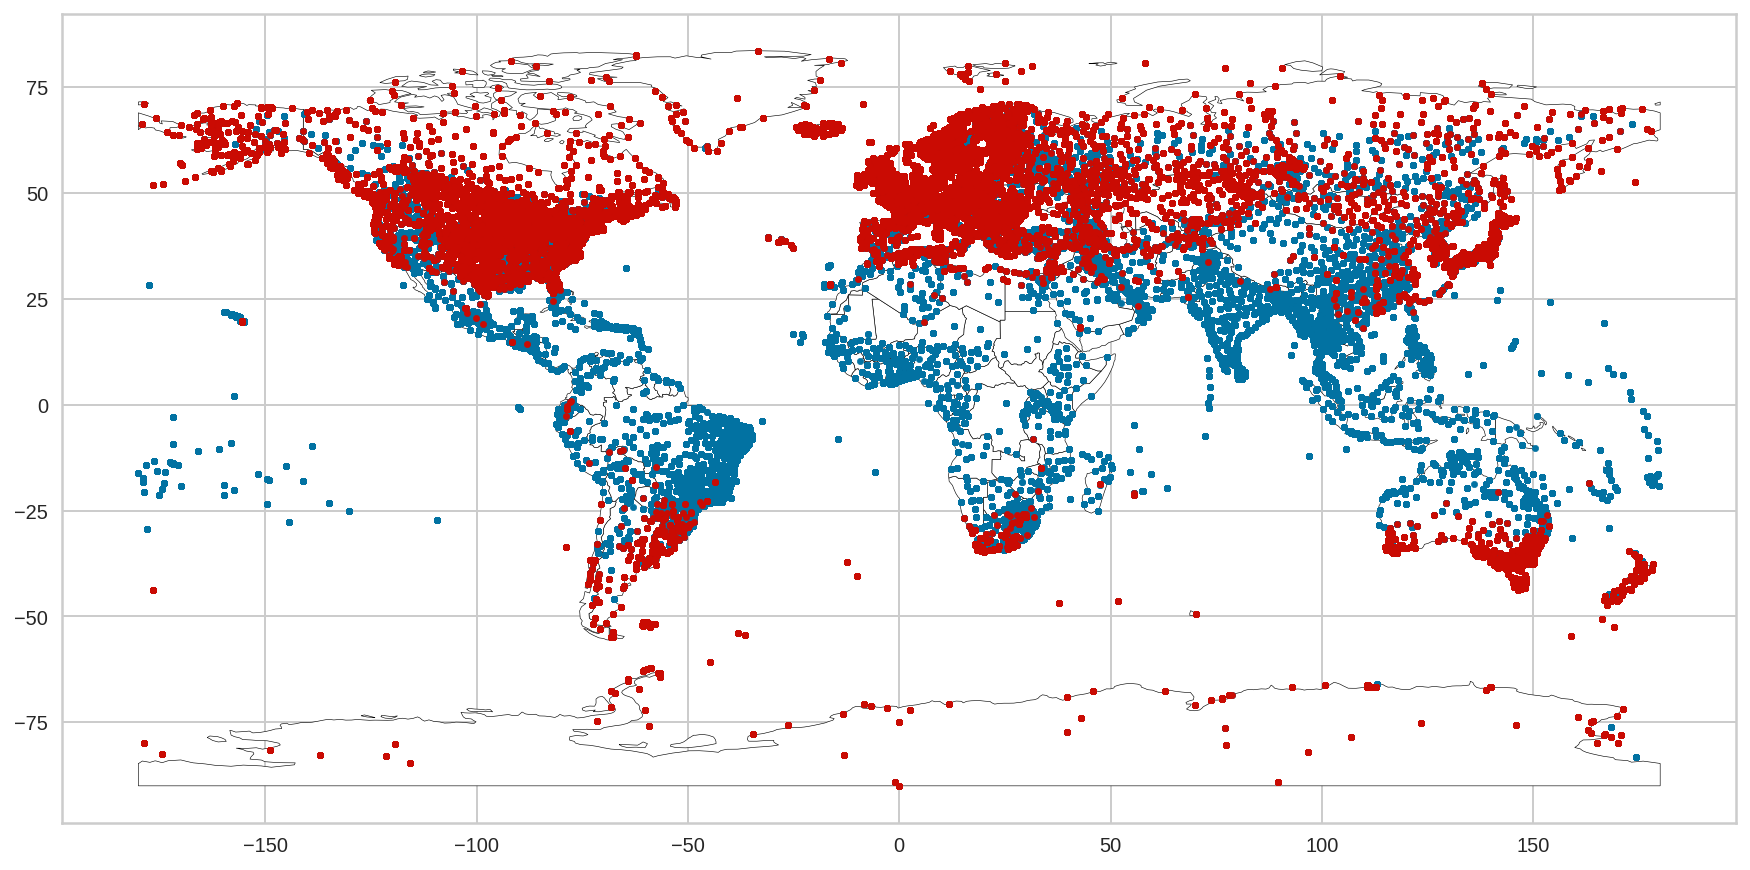

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStations[(allWhetherGoogleStations['temp']<=1400) & (allWhetherGoogleStations['rh']>=66) & (allWhetherGoogleStations['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStations['lon'], allWhetherGoogleStations['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStations, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("All time in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations.to_csv (r'allWhetherGoogleStationsIntMul100.csv', index = False, header=True)
!cp allWhetherGoogleStationsIntMul100.csv "drive/My Drive/covid-19"

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
allWhetherGoogleStationsIntMul100

stn  ...                          geometry
0        717160  ...                POINT (-71.5 46.9)
1        941820  ...            POINT (143.067 -10.05)
2        869900  ...            POINT (-50.135 -30.01)
3        942900  ...            POINT (148.45 -17.717)
4        997701  ...  POINT (-82.56999999999999 27.63)
...         ...  ...                               ...
4107416  999999  ...             POINT (171.272 7.065)
4107417  997993  ...             POINT (-70.833 43.05)
4107418  868990  ...           POINT (-51.933 -23.405)
4107419  868990  ...           POINT (-51.933 -23.405)
4107420  868990  ...           POINT (-51.933 -23.405)

[4107421 rows x 25 columns]

In [ ]:
allWhetherGoogleStationsIntMul100=allWhetherGoogleStationsIntMul100.loc[(allWhetherGoogleStationsIntMul100['month'] >= 1) & (allWhetherGoogleStationsIntMul100['month'] <= 3)]
allWhetherGoogleStationsIntMul100

stn  wban_left  ...  day_from_jan_first                 geometry
2        869900      99999  ...                  64   POINT (-50.135 -30.01)
3        942900      99999  ...                  74   POINT (148.45 -17.717)
6        997994      99999  ...                   5     POINT (-76.7 38.767)
15       994008      99999  ...                  87      POINT (-82.8 28.12)
16       994029      99999  ...                  74  POINT (-123.965 46.708)
...         ...        ...  ...                 ...                      ...
4107384  999999        481  ...                  33  POINT (-112.363 38.958)
4107405  998175      99999  ...                   1  POINT (-120.733 35.167)
4107406  998175      99999  ...                  53  POINT (-120.733 35.167)
4107409  946910      99999  ...                   7      POINT (141.467 -32)
4107417  997993      99999  ...                  41    POINT (-70.833 43.05)

[1041364 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




1st quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 99982.
Number of areas in map both red and blue points : 1041364.


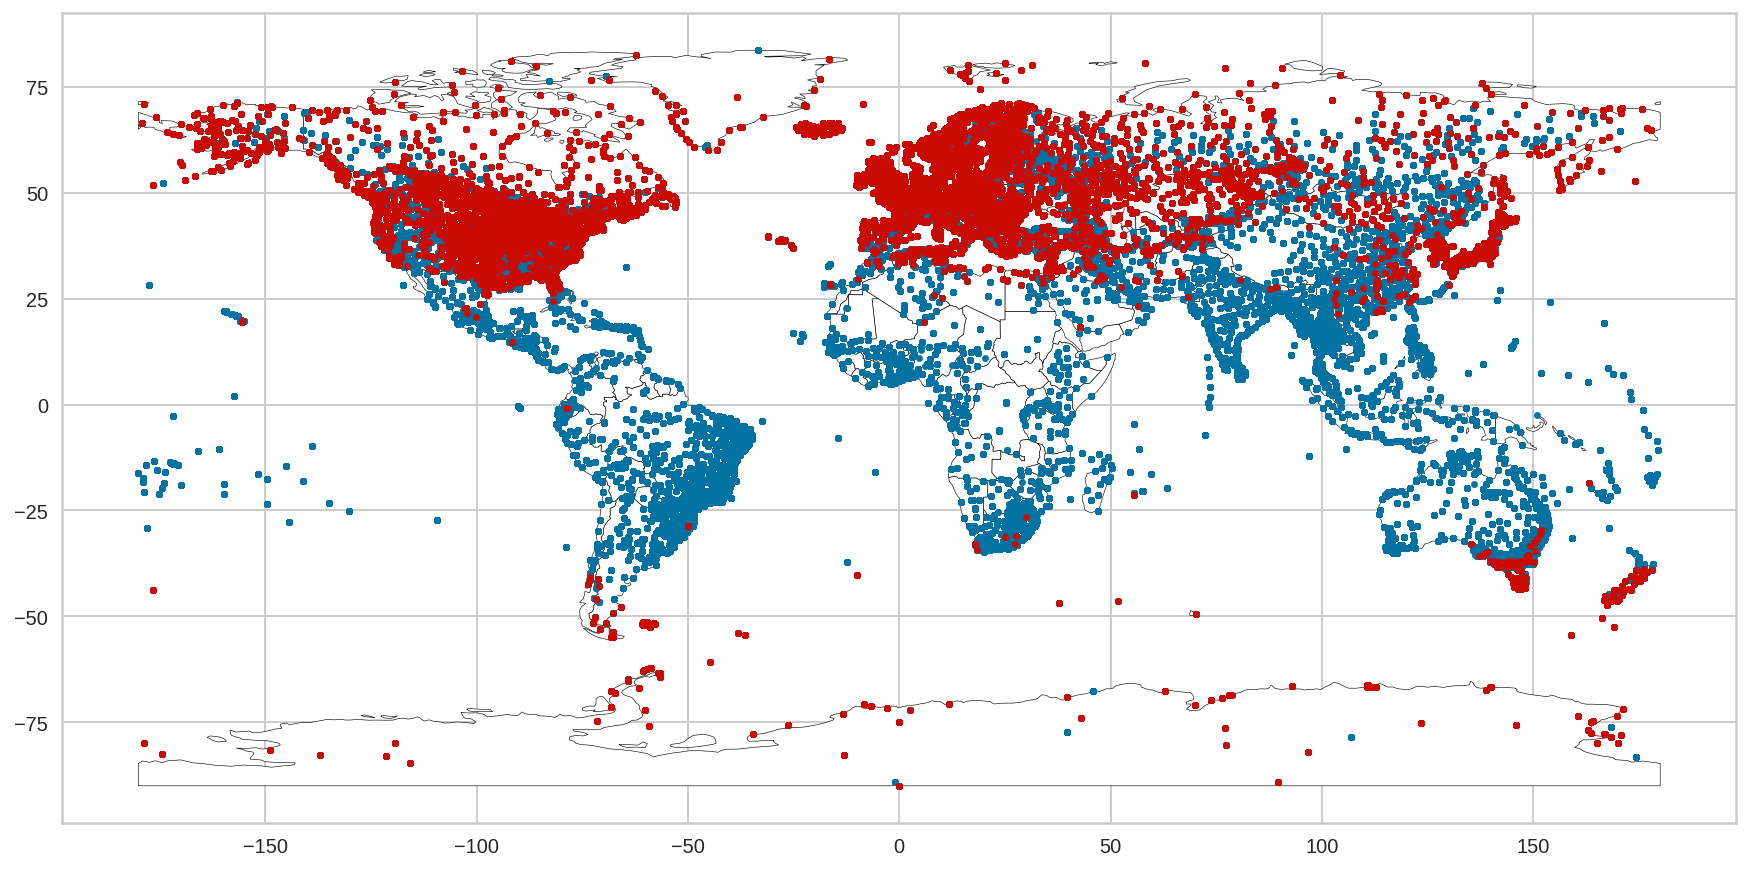

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStationsIntMul100[(allWhetherGoogleStationsIntMul100['temp']<=1400) & (allWhetherGoogleStationsIntMul100['rh']>=66) & (allWhetherGoogleStationsIntMul100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStationsIntMul100['lon'], allWhetherGoogleStationsIntMul100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStationsIntMul100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("1st quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
allWhetherGoogleStationsIntMul100

stn  ...                          geometry
0        717160  ...                POINT (-71.5 46.9)
1        941820  ...            POINT (143.067 -10.05)
2        869900  ...            POINT (-50.135 -30.01)
3        942900  ...            POINT (148.45 -17.717)
4        997701  ...  POINT (-82.56999999999999 27.63)
...         ...  ...                               ...
4107416  999999  ...             POINT (171.272 7.065)
4107417  997993  ...             POINT (-70.833 43.05)
4107418  868990  ...           POINT (-51.933 -23.405)
4107419  868990  ...           POINT (-51.933 -23.405)
4107420  868990  ...           POINT (-51.933 -23.405)

[4107421 rows x 25 columns]

In [ ]:
allWhetherGoogleStationsIntMul100=allWhetherGoogleStationsIntMul100.loc[(allWhetherGoogleStationsIntMul100['month'] >= 4) & (allWhetherGoogleStationsIntMul100['month'] <= 6)]
allWhetherGoogleStationsIntMul100

stn  wban_left  ...  day_from_jan_first                         geometry
0        717160      99999  ...                 176               POINT (-71.5 46.9)
13       866350      99999  ...                 106          POINT (-41.867 -11.333)
20       998012      99999  ...                 114  POINT (-86.48299999999998 42.1)
24       712110      99999  ...                 118            POINT (-123.3 49.483)
41        41830      99999  ...                 173           POINT (-14.533 66.383)
...         ...        ...  ...                 ...                              ...
4107410  946910      99999  ...                 168              POINT (141.467 -32)
4107411  946910      99999  ...                 178              POINT (141.467 -32)
4107414  999999      40710  ...                 133            POINT (171.272 7.065)
4107415  999999      40710  ...                 176            POINT (171.272 7.065)
4107418  868990      99999  ...                 104          POINT (-51.933 -23.405)

[1014867 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




2nd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 46849.
Number of areas in map both red and blue points : 1014867.


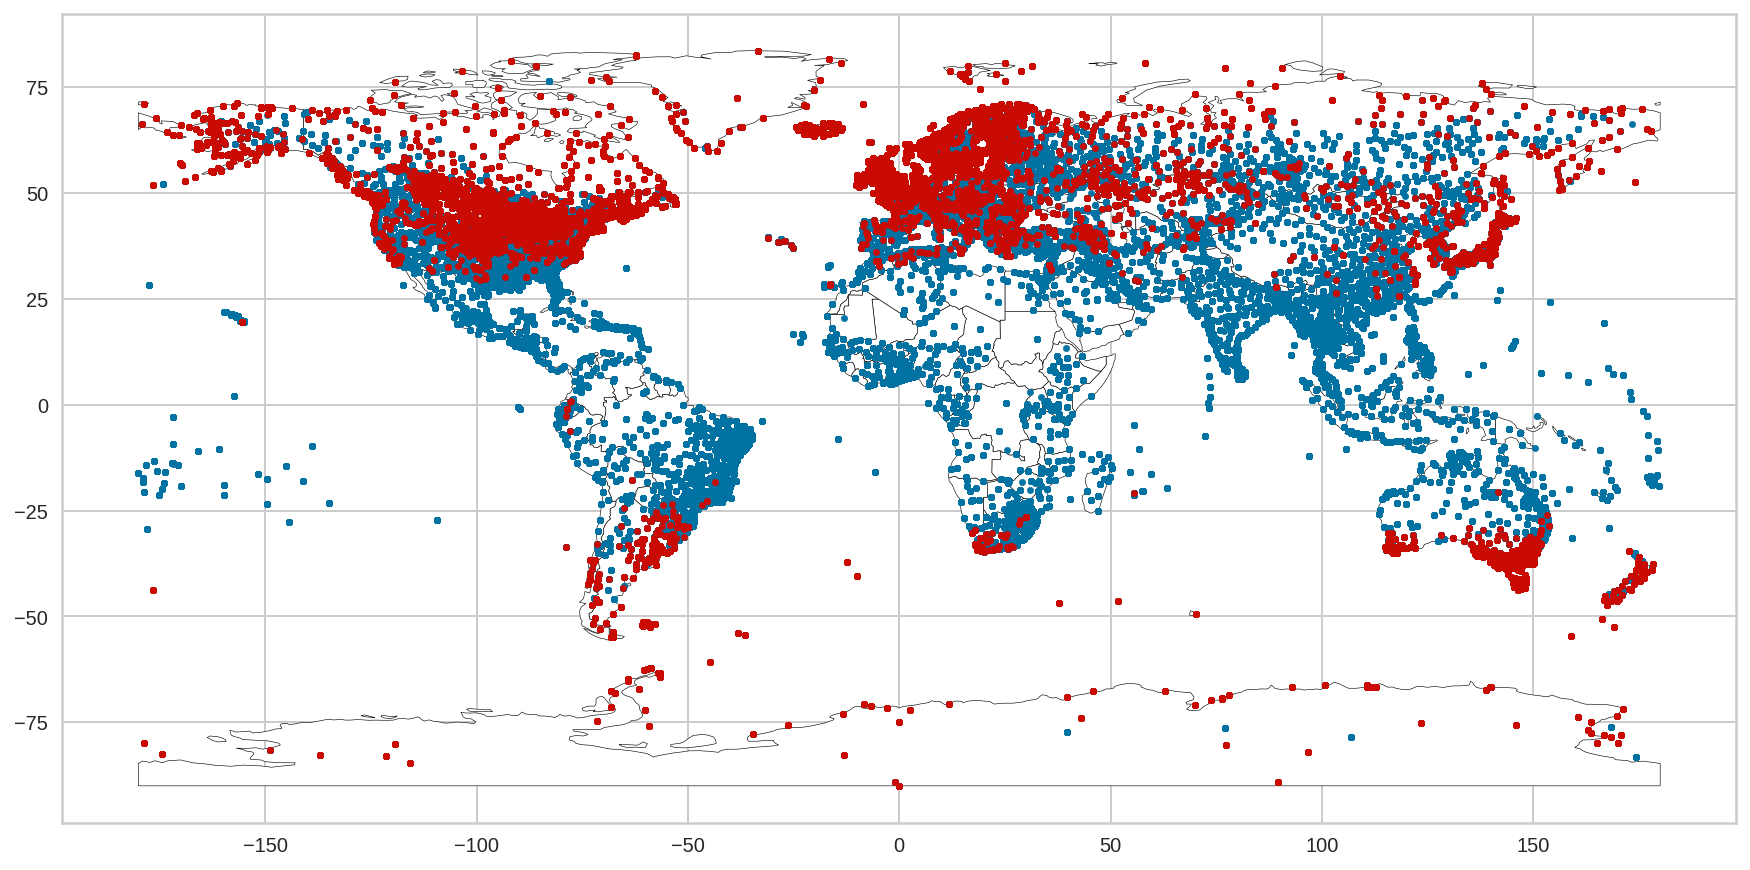

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStationsIntMul100[(allWhetherGoogleStationsIntMul100['temp']<=1400) & (allWhetherGoogleStationsIntMul100['rh']>=66) & (allWhetherGoogleStationsIntMul100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStationsIntMul100['lon'], allWhetherGoogleStationsIntMul100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStationsIntMul100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("2nd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
allWhetherGoogleStationsIntMul100

stn  ...                          geometry
0        717160  ...                POINT (-71.5 46.9)
1        941820  ...            POINT (143.067 -10.05)
2        869900  ...            POINT (-50.135 -30.01)
3        942900  ...            POINT (148.45 -17.717)
4        997701  ...  POINT (-82.56999999999999 27.63)
...         ...  ...                               ...
4107416  999999  ...             POINT (171.272 7.065)
4107417  997993  ...             POINT (-70.833 43.05)
4107418  868990  ...           POINT (-51.933 -23.405)
4107419  868990  ...           POINT (-51.933 -23.405)
4107420  868990  ...           POINT (-51.933 -23.405)

[4107421 rows x 25 columns]

In [ ]:
allWhetherGoogleStationsIntMul100=allWhetherGoogleStationsIntMul100.loc[(allWhetherGoogleStationsIntMul100['month'] >= 7) & (allWhetherGoogleStationsIntMul100['month'] <= 9)]
allWhetherGoogleStationsIntMul100

stn  ...                            geometry
1        941820  ...              POINT (143.067 -10.05)
4        997701  ...    POINT (-82.56999999999999 27.63)
5        997349  ...                 POINT (-64.75 17.7)
7        998252  ...                  POINT (-68.2 44.4)
8        998304  ...    POINT (-67.93899999999999 18.09)
...         ...  ...                                 ...
4107390  948570  ...             POINT (144.367 -38.167)
4107398  959090  ...               POINT (148.283 -36.5)
4107400  957160  ...             POINT (149.733 -34.817)
4107402  868910  ...  POINT (-41.76600000000001 -22.343)
4107413  997295  ...    POINT (-83.40000000000001 41.68)

[1021588 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




3rd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 31309.
Number of areas in map both red and blue points : 1021588.


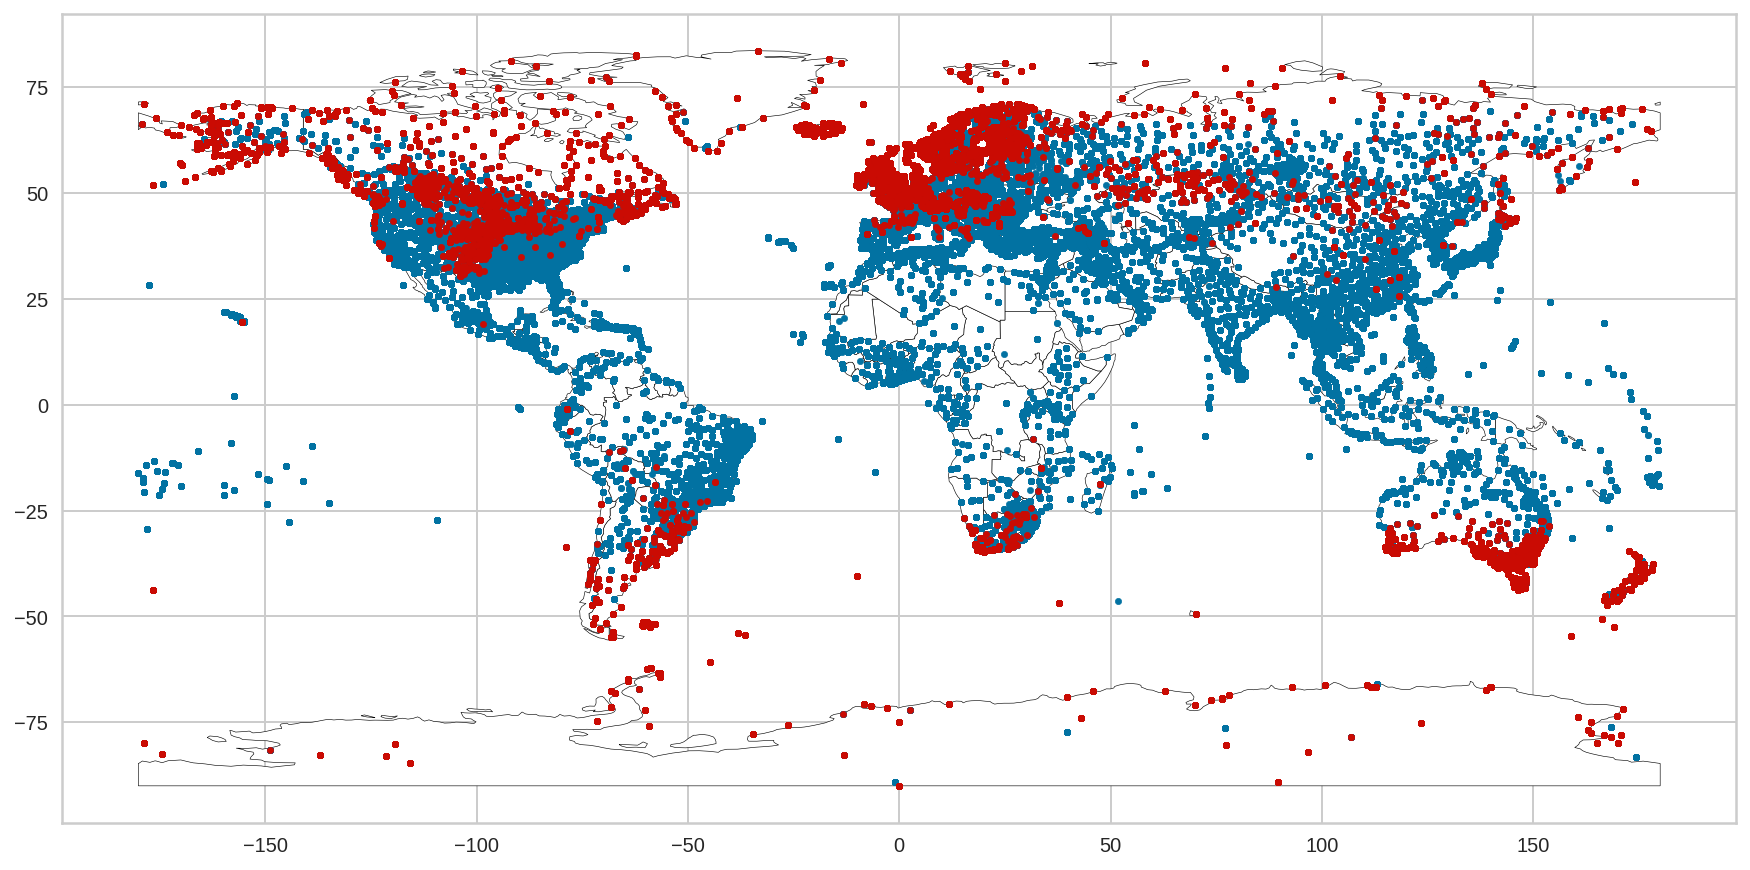

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStationsIntMul100[(allWhetherGoogleStationsIntMul100['temp']<=1400) & (allWhetherGoogleStationsIntMul100['rh']>=66) & (allWhetherGoogleStationsIntMul100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStationsIntMul100['lon'], allWhetherGoogleStationsIntMul100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStationsIntMul100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("3rd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
allWhetherGoogleStationsIntMul100

stn  ...                          geometry
0        717160  ...                POINT (-71.5 46.9)
1        941820  ...            POINT (143.067 -10.05)
2        869900  ...            POINT (-50.135 -30.01)
3        942900  ...            POINT (148.45 -17.717)
4        997701  ...  POINT (-82.56999999999999 27.63)
...         ...  ...                               ...
4107416  999999  ...             POINT (171.272 7.065)
4107417  997993  ...             POINT (-70.833 43.05)
4107418  868990  ...           POINT (-51.933 -23.405)
4107419  868990  ...           POINT (-51.933 -23.405)
4107420  868990  ...           POINT (-51.933 -23.405)

[4107421 rows x 25 columns]

In [ ]:
allWhetherGoogleStationsIntMul100=allWhetherGoogleStationsIntMul100.loc[(allWhetherGoogleStationsIntMul100['month'] >= 10) & (allWhetherGoogleStationsIntMul100['month'] <= 12)]
allWhetherGoogleStationsIntMul100

stn  ...                          geometry
10        12380  ...  POINT (9.282999999999999 62.117)
14       956350  ...           POINT (120.133 -33.933)
18       997372  ...   POINT (-75.56999999999999 39.9)
29       868460  ...           POINT (-46.383 -21.917)
32       868700  ...            POINT (-46.05 -22.867)
...         ...  ...                               ...
4107399  867770  ...            POINT (-47.933 -18.15)
4107412  946910  ...               POINT (141.467 -32)
4107416  999999  ...             POINT (171.272 7.065)
4107419  868990  ...           POINT (-51.933 -23.405)
4107420  868990  ...           POINT (-51.933 -23.405)

[1029602 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




4th quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 79093.
Number of areas in map both red and blue points : 1029602.


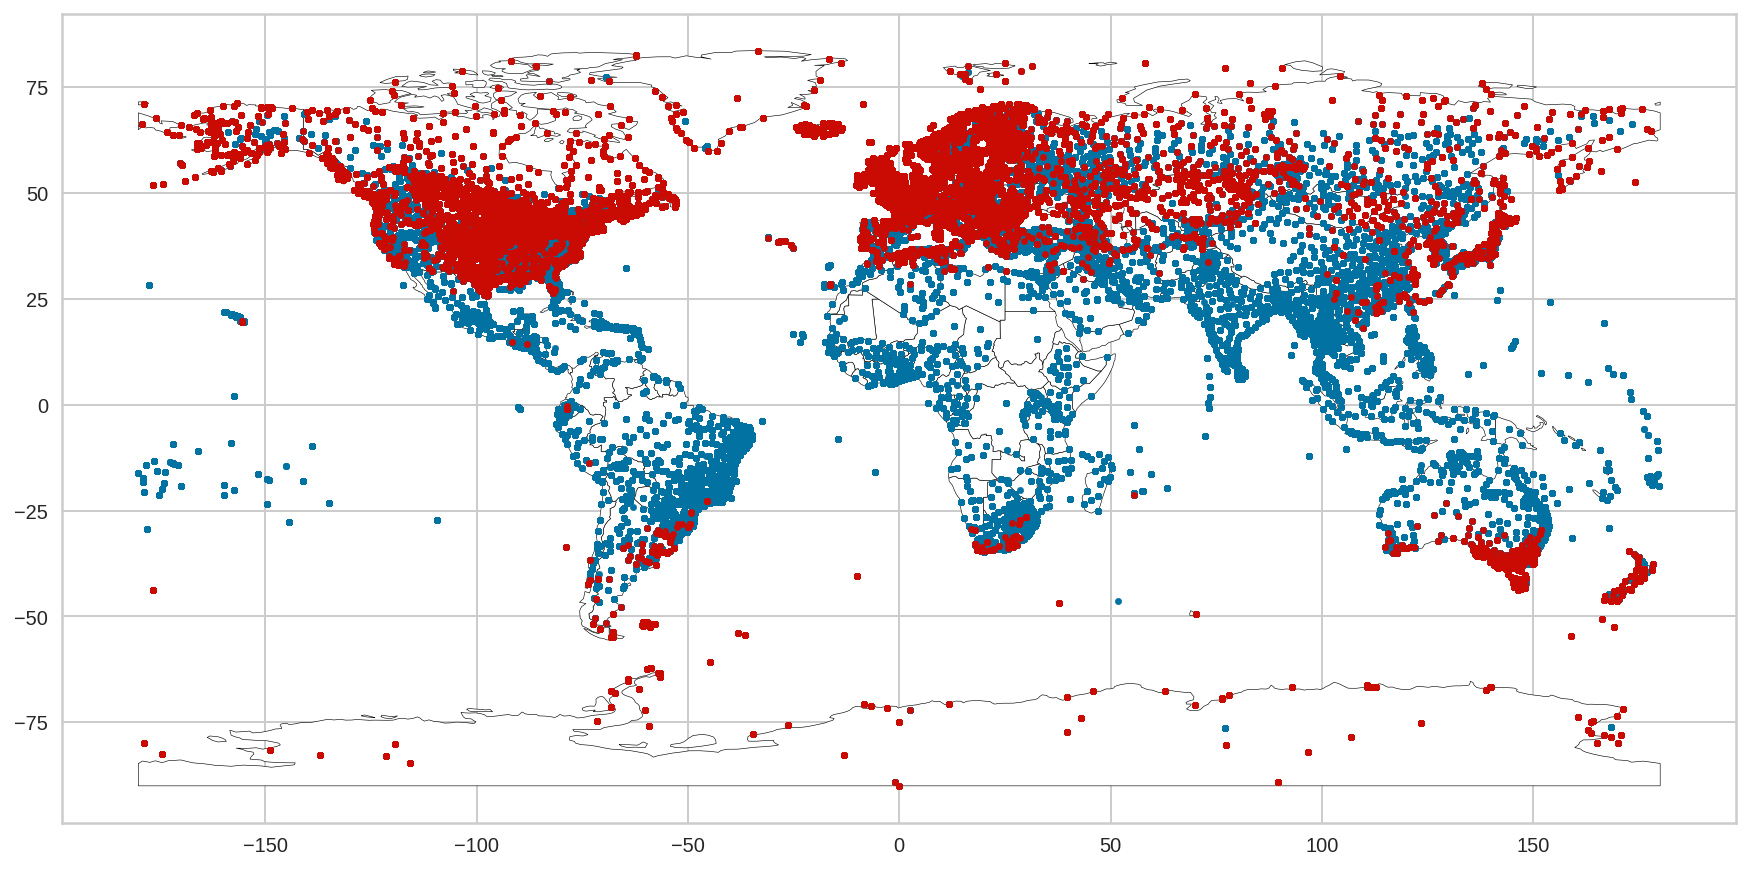

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStationsIntMul100[(allWhetherGoogleStationsIntMul100['temp']<=1400) & (allWhetherGoogleStationsIntMul100['rh']>=66) & (allWhetherGoogleStationsIntMul100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStationsIntMul100['lon'], allWhetherGoogleStationsIntMul100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStationsIntMul100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("4th quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
table1_gsod2021 = bigquery.TableReference.from_string(
    "bigquery-public-data.noaa_gsod.gsod2021"
)

dataframe_gsod2021= client.list_rows(table1_gsod2021,
    selected_fields=[
        bigquery.SchemaField("stn", "STRING"), #เลขสถานี
        bigquery.SchemaField("wban", "STRING"), #เลขสถานี
        bigquery.SchemaField("year", "INTEGER"),
        bigquery.SchemaField("mo", "INTEGER"),
        bigquery.SchemaField("da", "INTEGER"),
        bigquery.SchemaField("temp", "FLOAT"), #อุณหภูมิเฉลี่ย
        bigquery.SchemaField("dewp", "FLOAT"), #ค่า dew point temp เฉลี่ย
        bigquery.SchemaField("slp", "FLOAT"), #ค่าความดันจากระดับน้ำทะเลเฉลี่ย
        bigquery.SchemaField("wdsp", "FLOAT"), #ค่าความเร็วลมเฉลี่ย
        bigquery.SchemaField("prcp", "FLOAT"), #ค่าปริมาณน้ำฝน
        bigquery.SchemaField("sndp", "FLOAT"), #ค่าหิมะ
    ],).to_dataframe()

dataframe_gsod2021
#retrive weather factor data 2021 data from googlecloud api

stn   wban  year  mo  da  temp    dewp     slp  wdsp  prcp   sndp
0        012380  99999  2021   8  28  52.9  9999.9  1025.1   3.6  0.00  999.9
1        010360  99999  2021   2  10  13.7  9999.9  1020.9   2.9  0.00  999.9
2        014840  99999  2021   3   5  27.3  9999.9  1023.7   3.4  0.00  999.9
3        012400  99999  2021   5  29  47.2  9999.9  1028.1   8.0  0.00  999.9
4        012400  99999  2021   6   5  55.2  9999.9  1024.4   7.7  0.00  999.9
...         ...    ...   ...  ..  ..   ...     ...     ...   ...   ...    ...
3471070  938450  99999  2021   1   8  55.7    48.3  1011.0  12.8  0.02  999.9
3471071  938450  99999  2021  10  30  58.7    47.6   993.2  11.1  0.09  999.9
3471072  994720  99999  2021   4  16  37.7    35.0  1029.7   5.4  0.00  999.9
3471073  994720  99999  2021  10  10  45.4    38.0  1009.8  20.2  0.00  999.9
3471074  994720  99999  2021  11  11  28.5    27.0  1004.8  12.1  0.00  999.9

[3471075 rows x 11 columns]

In [ ]:
stations_df= dataframe_stations
twenty_twenty_df= dataframe_gsod2021

In [ ]:
stations_df['STN'] = stations_df['usaf'] + '-' + stations_df['wban']
twenty_twenty_df['STN'] = twenty_twenty_df['stn'] + '-' + twenty_twenty_df['wban']
cols_1= list(twenty_twenty_df.columns)
cols_2= list(stations_df.columns)
weather_df = twenty_twenty_df[cols_1].join(stations_df[cols_2].set_index('STN'), on='STN',  how='left', lsuffix='_left', rsuffix='_right')

weather_df['temp'] = weather_df['temp'].apply(lambda x: np.nan if x==9999.9 else x)#อันไหนไม่มีค่าใส่ 9999.9
weather_df['slp'] = weather_df['slp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['dewp'] = weather_df['dewp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['wdsp'] = weather_df['wdsp'].apply(lambda x: np.nan if x==999.9 else x)
weather_df['prcp'] = weather_df['prcp'].apply(lambda x: np.nan if x==999.9 else x)
weather_df['sndp'] = weather_df['sndp'].apply(lambda x: np.nan if x==999.9 else x)

# เปลี่ยนเป็นเซลเซียส
temp = (weather_df['temp'] - 32) / 1.8
#temp = weather_df['temp']
dewp = (weather_df['dewp'] - 32) / 1.8
#dewp = weather_df['dewp']


weather_df['temp'] = (weather_df['temp'] - 32) / 1.8
weather_df['dewp'] = (weather_df['dewp'] - 32) / 1.8


# นำข้อมูลที่มีมาหาค่าความชื้นสัมพัทธ์
weather_df['rh'] = (np.exp((18.678*dewp)/(257.14+dewp))/np.exp((18.678*temp)/(257.14+temp)))

# หาค่าความชื้นที่แท้จริงในสภาพอากาศ
# (ah = mass / volume = pressure / (constant * temperature))
weather_df['ah'] = ((np.exp((18.678*dewp)/(257.14+dewp))) * 6.1121 * 100) / (461.5 * temp)


weather_df['month']= weather_df['mo']
weather_df['day']= weather_df['da']
weather_df['Date']=pd.to_datetime(weather_df[['year','month','day']])
weather_df['Date2']= weather_df['Date']
weather_df['Date2']= weather_df['Date2'].astype('str')
mo2 = weather_df['Date2'].apply(lambda x: x[5:7])
da2 = weather_df['Date2'].apply(lambda x: x[8:10])
weather_df['day_from_jan_first'] = (da2.apply(int)
                               + 31*(mo2=='02') 
                               + 60*(mo2=='03')
                               + 91*(mo2=='04')
                               + 121*(mo2=='05')
                               + 152*(mo2=='06')
                               + 182*(mo2=='07')
                               + 213*(mo2=='08')
                               + 244*(mo2=='09')
                               + 274*(mo2=='10')
                               + 305*(mo2=='11')
                               + 335*(mo2=='12')
                              )
weather_df.to_csv (r'allWhetherGoogleStations2021.csv', index = False, header=True)
!cp allWhetherGoogleStations2021.csv "drive/My Drive/covid-19"
allWhetherGoogleStations2021=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021.csv')#check point
allWhetherGoogleStations2021
#retrive weather factor data 2021 data from googlecloud api

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021.csv')#check point
allWhetherGoogleStations2021

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021['temp']=allWhetherGoogleStations2021['temp'].interpolate(limit_direction='both')
allWhetherGoogleStations2021['rh']=allWhetherGoogleStations2021['rh'].interpolate(limit_direction='both')
allWhetherGoogleStations2021['wdsp']=allWhetherGoogleStations2021['wdsp'].interpolate(limit_direction='both')
allWhetherGoogleStations2021.to_csv (r'allWhetherGoogleStations2021Interpolate.csv', index = False, header=True)
!cp allWhetherGoogleStations2021Interpolate.csv "drive/My Drive/covid-19"
allWhetherGoogleStations2021=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021Interpolate.csv')#check point
allWhetherGoogleStations2021

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021Interpolate.csv')#check point
allWhetherGoogleStations2021

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021['rh'] = allWhetherGoogleStations2021['rh'].apply(lambda x: x*100)
allWhetherGoogleStations2021['temp'] = allWhetherGoogleStations2021['temp'].apply(lambda x: x*100)
allWhetherGoogleStations2021['wdsp'] = allWhetherGoogleStations2021['wdsp'].apply(lambda x: x*100)

In [ ]:
allWhetherGoogleStations2021['temp']=allWhetherGoogleStations2021['temp'].astype(int)
allWhetherGoogleStations2021['rh']=allWhetherGoogleStations2021['rh'].astype(int)
allWhetherGoogleStations2021['wdsp']=allWhetherGoogleStations2021['wdsp'].astype(int)
allWhetherGoogleStations2021interpolate100=allWhetherGoogleStations2021
allWhetherGoogleStations2021interpolate100.to_csv (r'allWhetherGoogleStations2021interpolate100.csv', index = False, header=True)
!cp allWhetherGoogleStations2021interpolate100.csv "drive/My Drive/covid-19"
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




All time in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 181729.
Number of areas in map both red and blue points : 3437697.


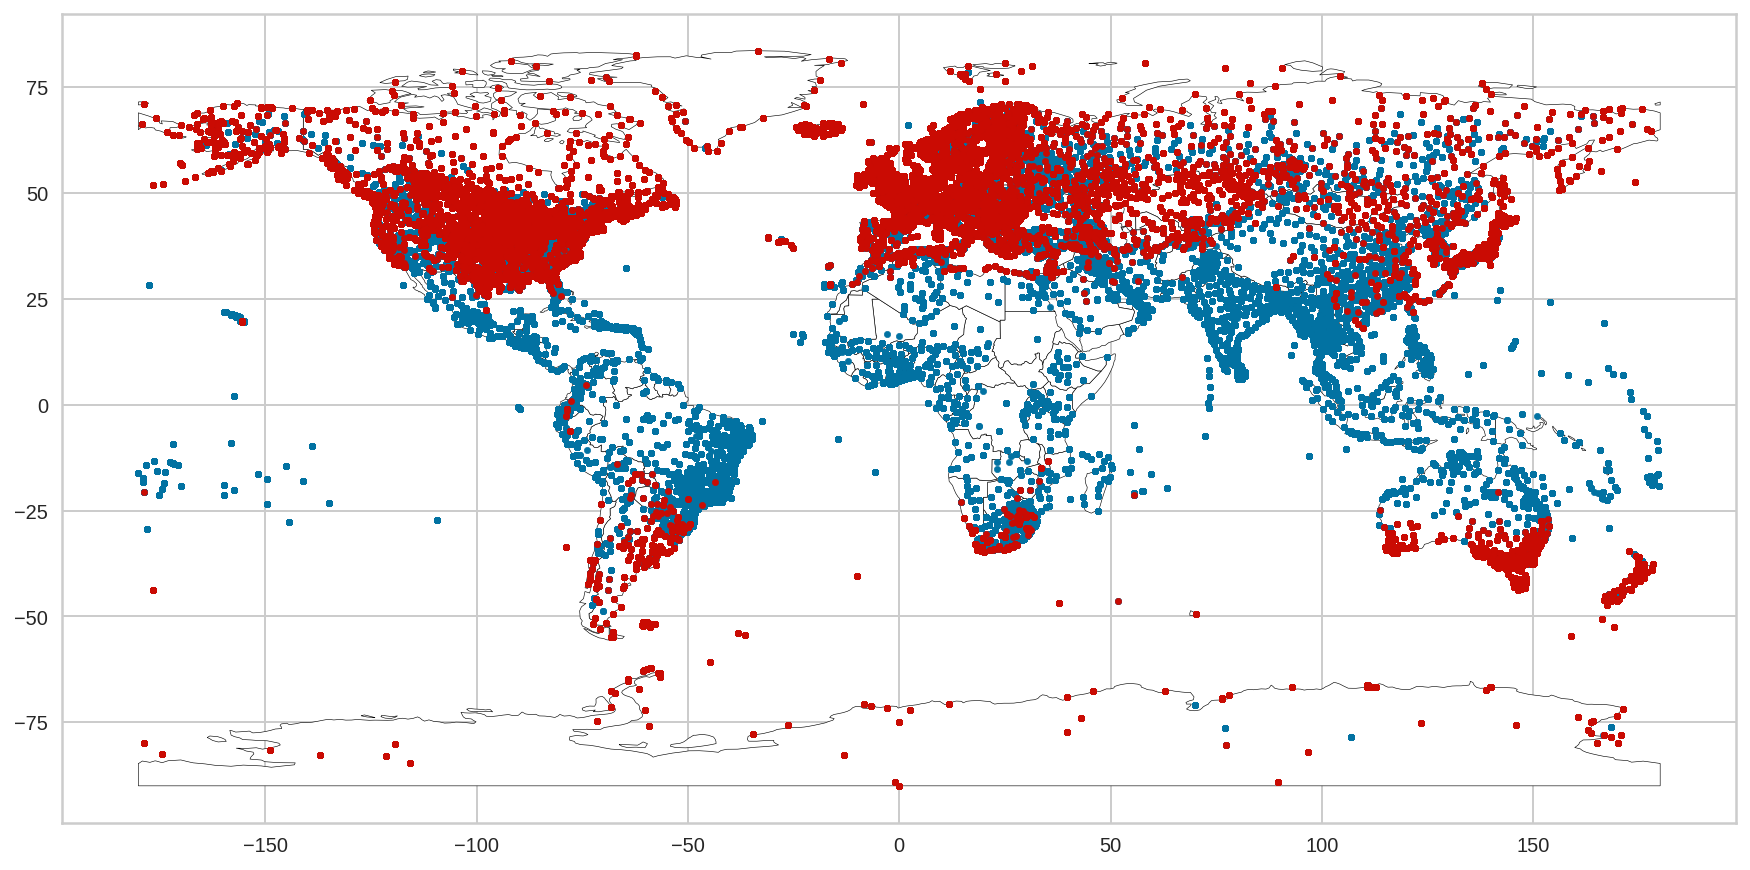

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStations2021interpolate100[(allWhetherGoogleStations2021interpolate100['temp']<=1400) & (allWhetherGoogleStations2021interpolate100['rh']>=66) & (allWhetherGoogleStations2021interpolate100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStations2021interpolate100['lon'], allWhetherGoogleStations2021interpolate100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStations2021interpolate100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("All time in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021interpolate100=allWhetherGoogleStations2021interpolate100.loc[(allWhetherGoogleStations2021interpolate100['month'] >= 1) & (allWhetherGoogleStations2021interpolate100['month'] <= 3)]
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
9        898680      99999  2021  ...  2021-02-04  2021-02-04                  35
14       994029      99999  2021  ...  2021-01-08  2021-01-08                   8
15       997279      99999  2021  ...  2021-03-19  2021-03-19                  79
16       997386      99999  2021  ...  2021-03-19  2021-03-19                  79
18       998243      99999  2021  ...  2021-02-13  2021-02-13                  44
...         ...        ...   ...  ...         ...         ...                 ...
3437672  875480      99999  2021  ...  2021-03-12  2021-03-12                  72
3437673  948700      99999  2021  ...  2021-03-06  2021-03-06                  66
3437680  999999      13752  2021  ...  2021-01-30  2021-01-30                  30
3437682  865800      99999  2021  ...  2021-03-22  2021-03-22                  82
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2

[973539 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




1st quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 78005.
Number of areas in map both red and blue points : 973539.


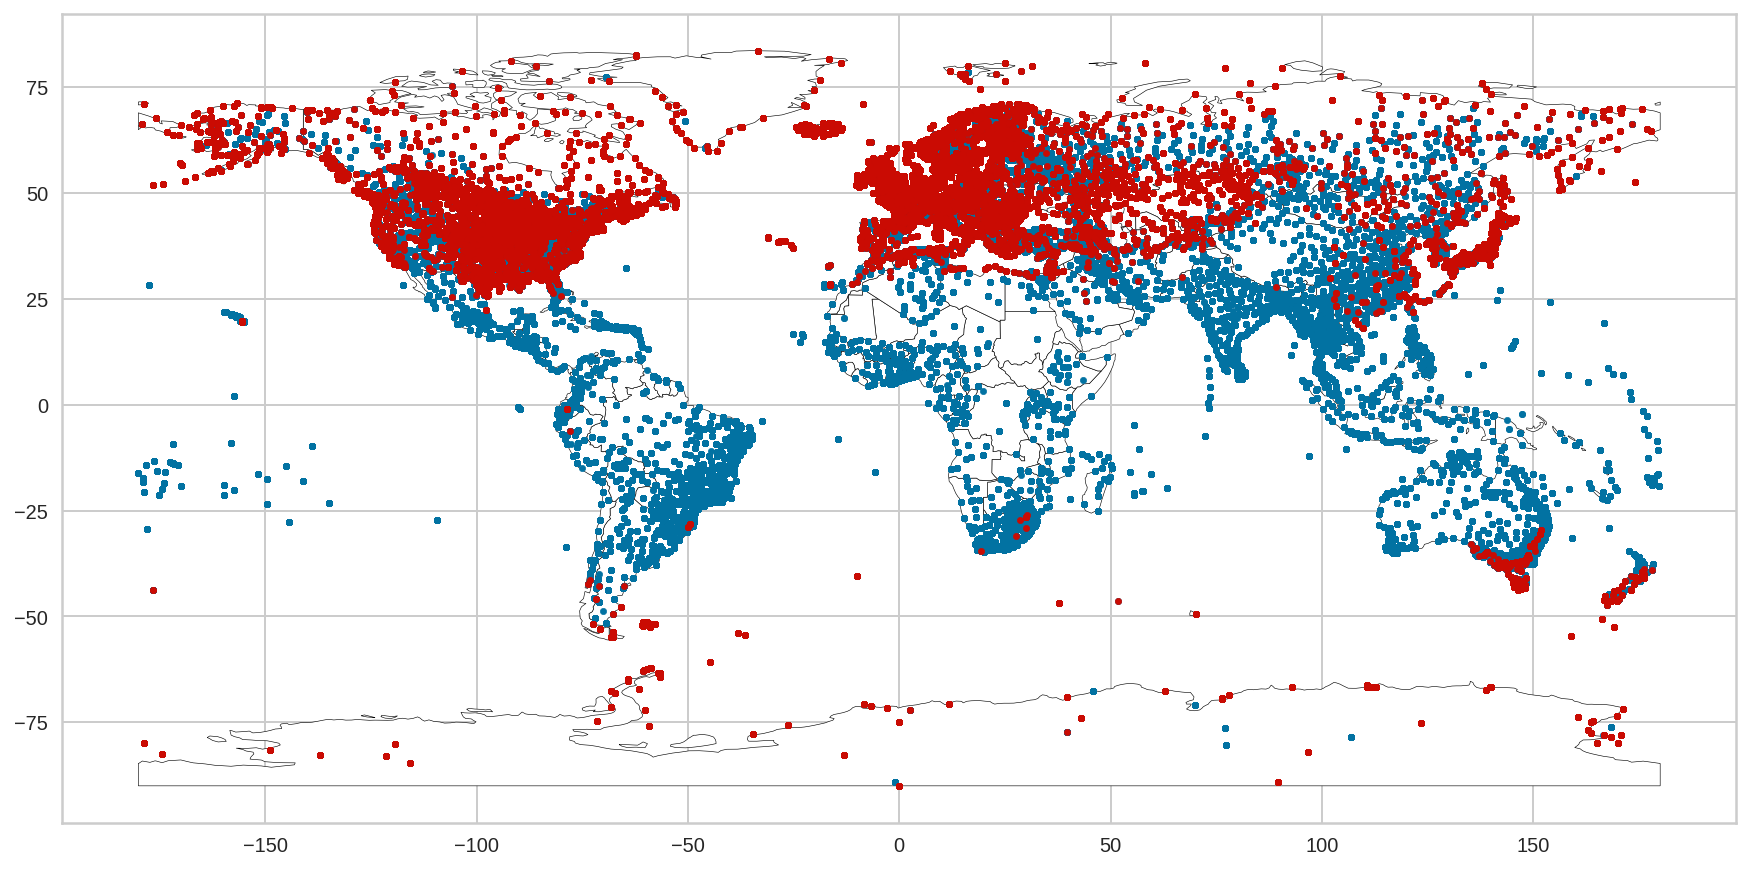

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStations2021interpolate100[(allWhetherGoogleStations2021interpolate100['temp']<=1400) & (allWhetherGoogleStations2021interpolate100['rh']>=66) & (allWhetherGoogleStations2021interpolate100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStations2021interpolate100['lon'], allWhetherGoogleStations2021interpolate100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStations2021interpolate100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("1st quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021interpolate100=allWhetherGoogleStations2021interpolate100.loc[(allWhetherGoogleStations2021interpolate100['month'] >= 4) & (allWhetherGoogleStations2021interpolate100['month'] <= 6)]
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
8        817110      99999  2021  ...  2021-05-14  2021-05-14                 135
12       997174      99999  2021  ...  2021-06-01  2021-06-01                 153
13       994028      99999  2021  ...  2021-06-01  2021-06-01                 153
17       997782      99999  2021  ...  2021-06-01  2021-06-01                 153
...         ...        ...   ...  ...         ...         ...                 ...
3437687  958390      99999  2021  ...  2021-06-12  2021-06-12                 164
3437691  951460      99999  2021  ...  2021-05-18  2021-05-18                 139
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174

[1006717 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




2nd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 44505.
Number of areas in map both red and blue points : 1006717.


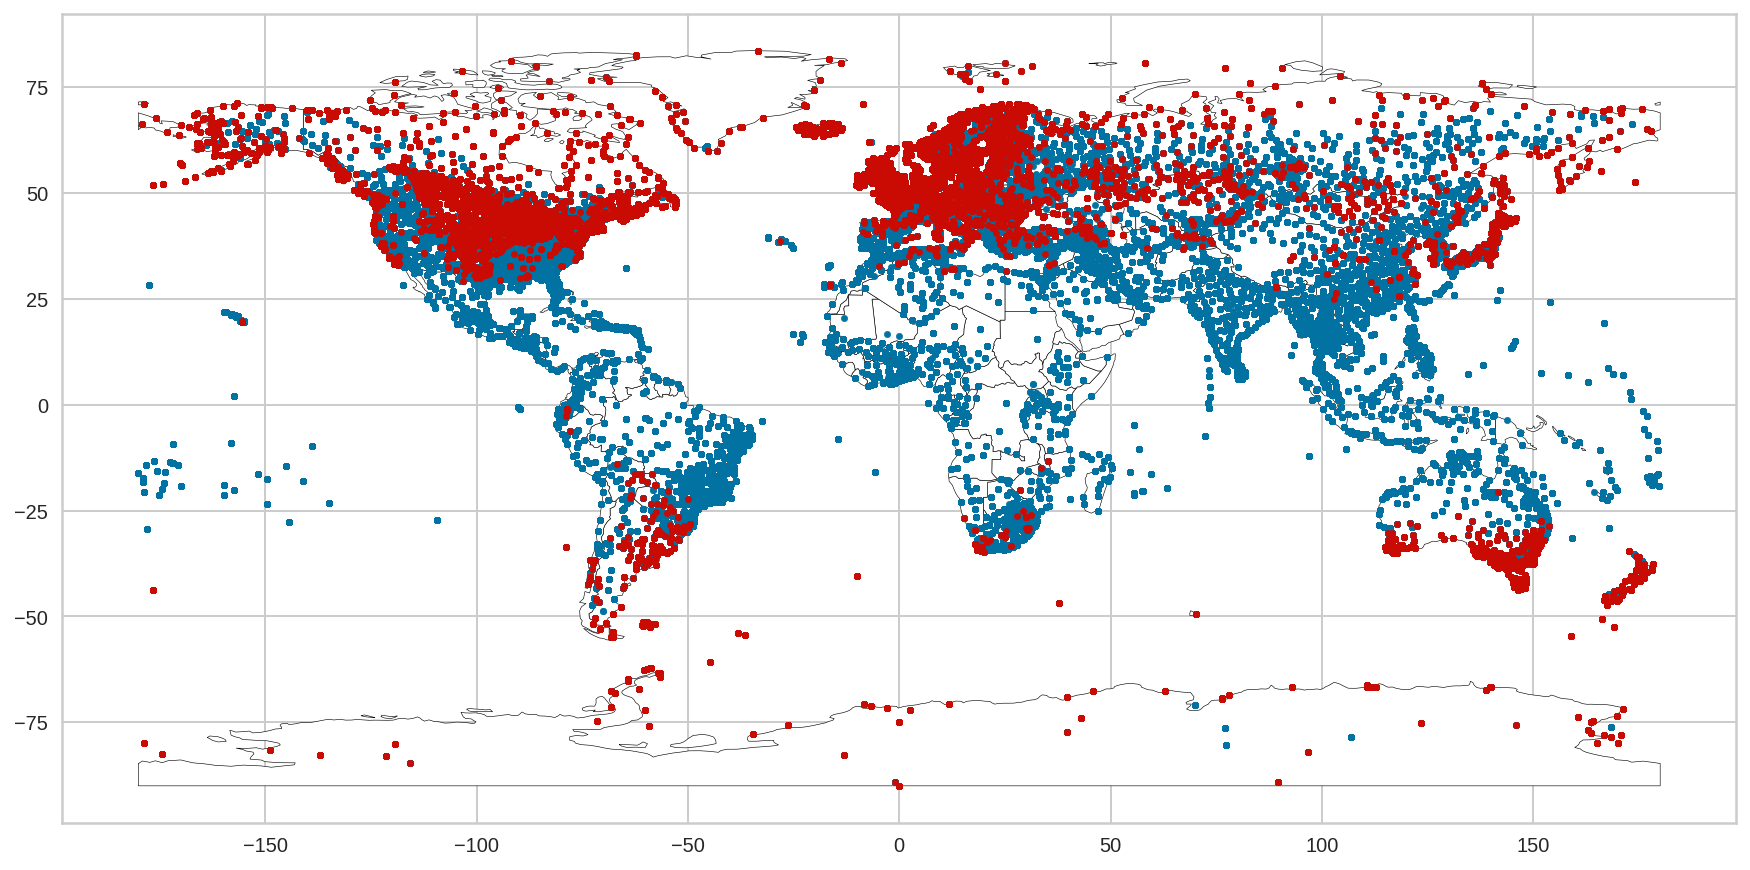

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStations2021interpolate100[(allWhetherGoogleStations2021interpolate100['temp']<=1400) & (allWhetherGoogleStations2021interpolate100['rh']>=66) & (allWhetherGoogleStations2021interpolate100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStations2021interpolate100['lon'], allWhetherGoogleStations2021interpolate100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStations2021interpolate100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("2nd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021interpolate100=allWhetherGoogleStations2021interpolate100.loc[(allWhetherGoogleStations2021interpolate100['month'] >= 7) & (allWhetherGoogleStations2021interpolate100['month'] <= 9)]
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
5         41310      99999  2021  ...  2021-08-13  2021-08-13                 226
6        724295      63888  2021  ...  2021-08-17  2021-08-17                 230
10       943790      99999  2021  ...  2021-08-12  2021-08-12                 225
...         ...        ...   ...  ...         ...         ...                 ...
3437684  865800      99999  2021  ...  2021-07-19  2021-07-19                 201
3437685  865800      99999  2021  ...  2021-07-24  2021-07-24                 206
3437688  958390      99999  2021  ...  2021-07-29  2021-07-29                 211
3437689  958390      99999  2021  ...  2021-09-04  2021-09-04                 248
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[1011067 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




3rd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 30007.
Number of areas in map both red and blue points : 1011067.


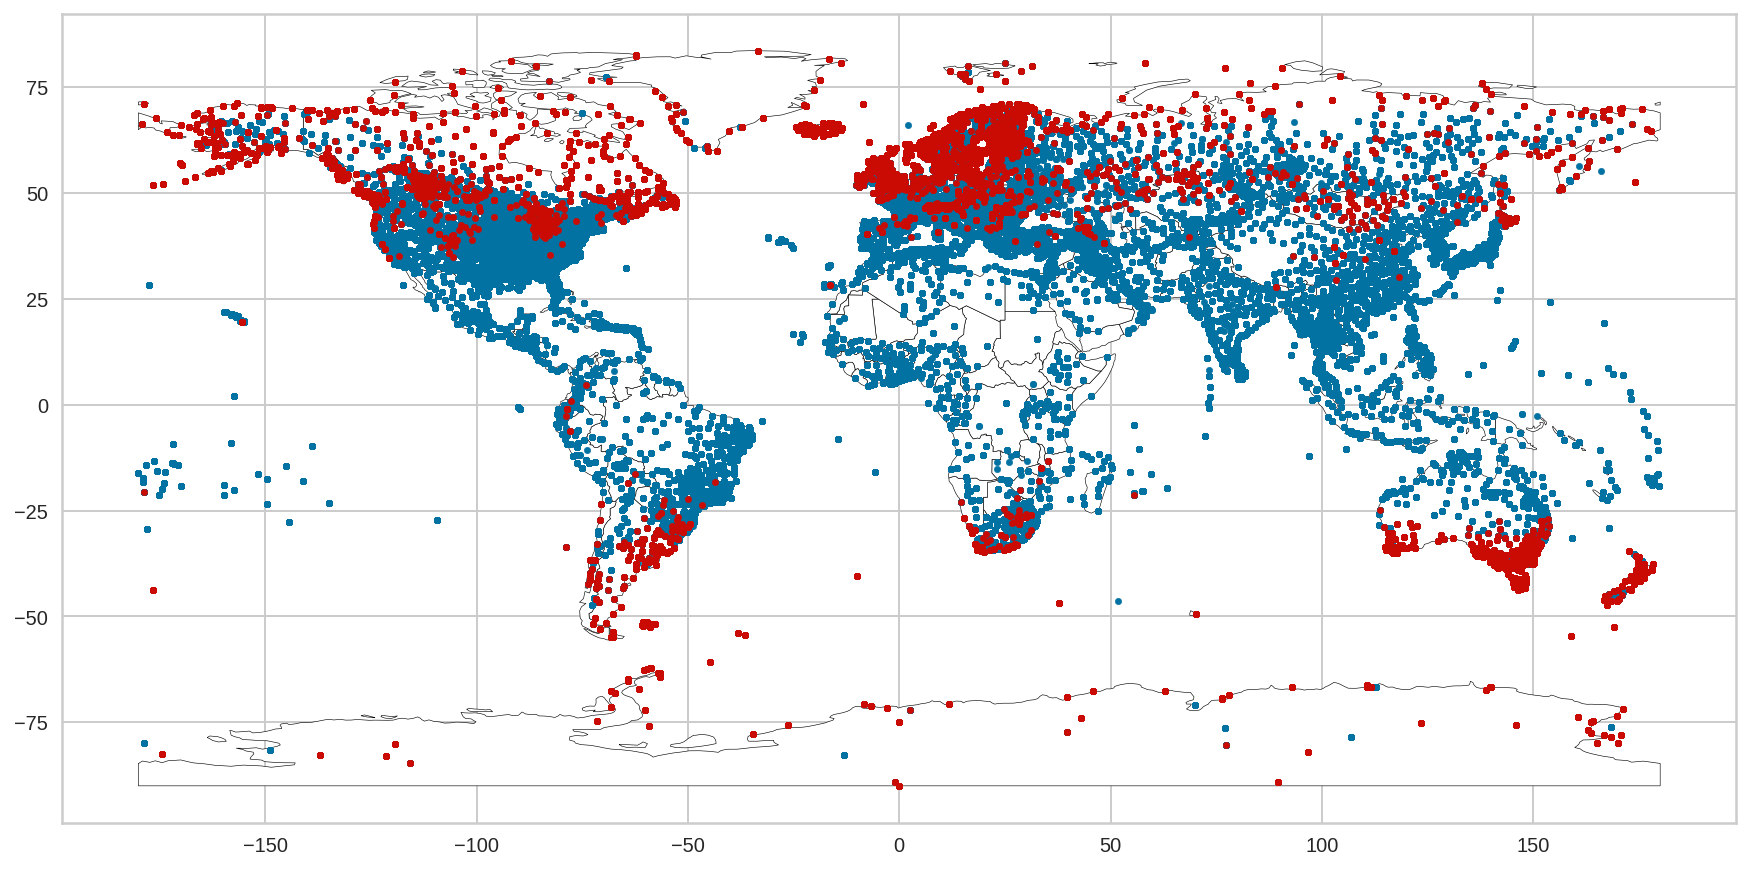

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStations2021interpolate100[(allWhetherGoogleStations2021interpolate100['temp']<=1400) & (allWhetherGoogleStations2021interpolate100['rh']>=66) & (allWhetherGoogleStations2021interpolate100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStations2021interpolate100['lon'], allWhetherGoogleStations2021interpolate100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStations2021interpolate100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("3rd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
0         10360      99999  2021  ...  2021-06-01  2021-06-01                 153
1         10360      99999  2021  ...  2021-08-27  2021-08-27                 240
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
3         12400      99999  2021  ...  2021-08-08  2021-08-08                 221
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174
3437696  717390      99999  2021  ...  2021-09-16  2021-09-16                 260

[3437697 rows x 24 columns]

In [ ]:
allWhetherGoogleStations2021interpolate100=allWhetherGoogleStations2021interpolate100.loc[(allWhetherGoogleStations2021interpolate100['month'] >= 10) & (allWhetherGoogleStations2021interpolate100['month'] <= 12)]
allWhetherGoogleStations2021interpolate100

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
2         10360      99999  2021  ...  2021-10-13  2021-10-13                 287
4         40720      99999  2021  ...  2021-11-08  2021-11-08                 313
7        724397      54831  2021  ...  2021-10-06  2021-10-06                 280
11       994008      99999  2021  ...  2021-11-07  2021-11-07                 312
35        40720      99999  2021  ...  2021-10-18  2021-10-18                 292
...         ...        ...   ...  ...         ...         ...                 ...
3437651  949830      99999  2021  ...  2021-10-17  2021-10-17                 291
3437657  998005      99999  2021  ...  2021-11-05  2021-11-05                 310
3437666  958160      99999  2021  ...  2021-10-27  2021-10-27                 301
3437679  956320      99999  2021  ...  2021-11-01  2021-11-01                 306
3437690  958390      99999  2021  ...  2021-11-07  2021-11-07                 312

[446374 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




4th quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 29212.
Number of areas in map both red and blue points : 446374.


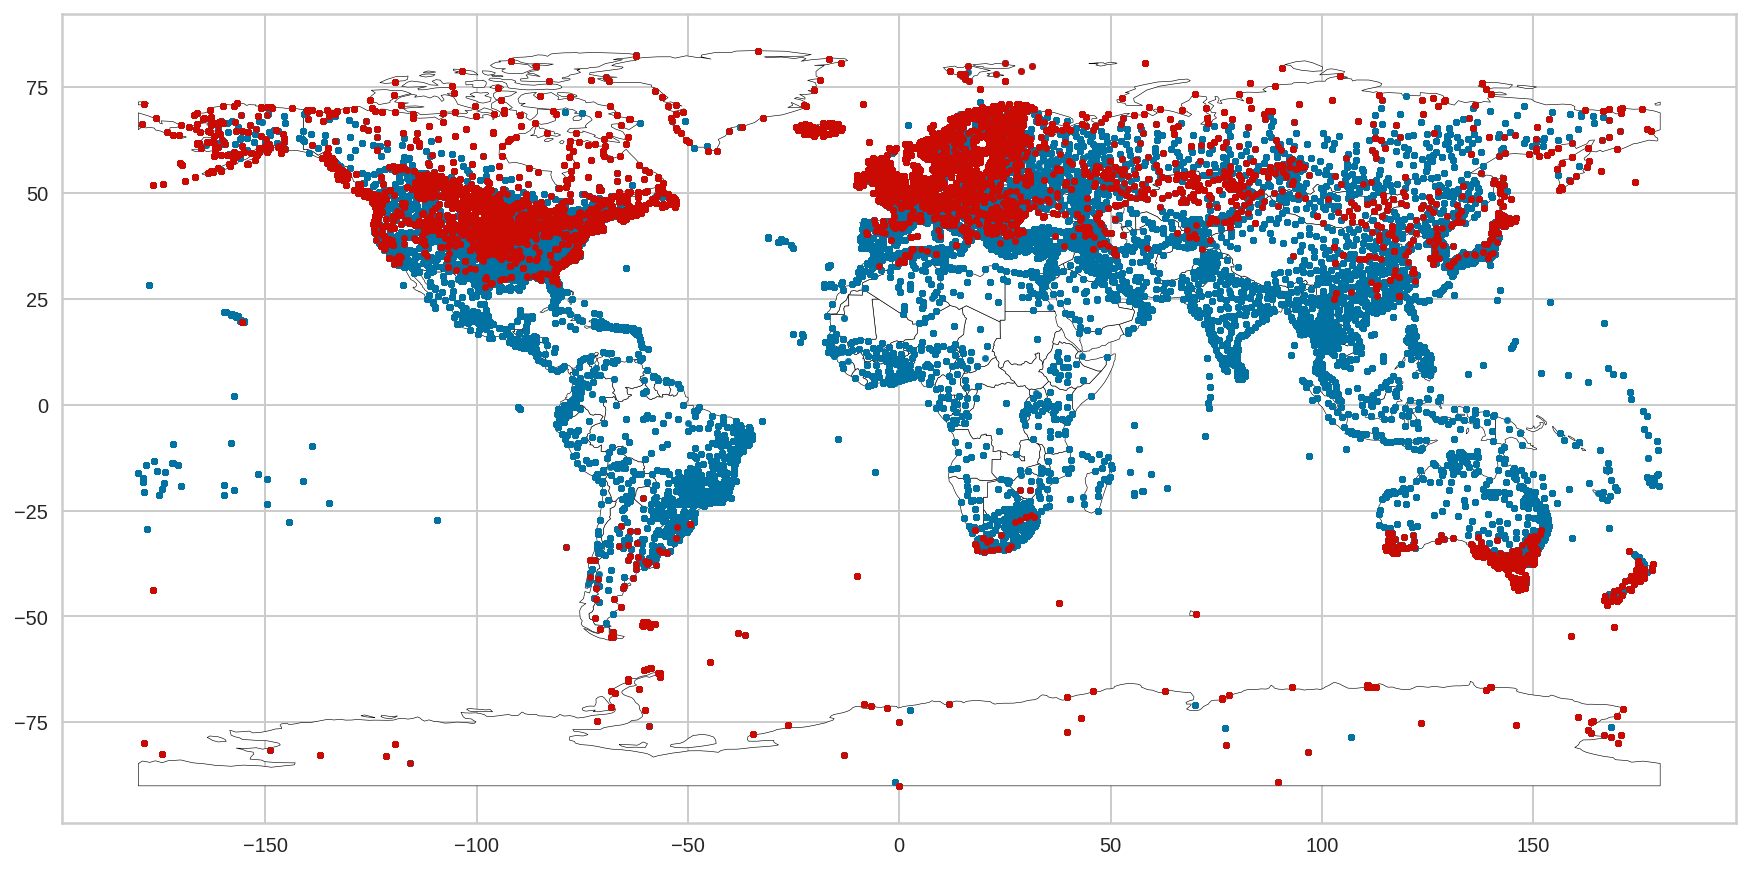

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= allWhetherGoogleStations2021interpolate100[(allWhetherGoogleStations2021interpolate100['temp']<=1400) & (allWhetherGoogleStations2021interpolate100['rh']>=66) & (allWhetherGoogleStations2021interpolate100['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(allWhetherGoogleStations2021interpolate100['lon'], allWhetherGoogleStations2021interpolate100['lat'])]
geo_df= gpd.GeoDataFrame(allWhetherGoogleStations2021interpolate100, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = countries.plot(color='white', edgecolor='black', figsize = (15,15))

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("4th quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                geometry
14808    476800      99999  ...                  18  POINT (139.394 35.514)
17797    478980      99999  ...                 357  POINT (133.017 32.717)
17875    478990      99999  ...                 357   POINT (134.183 33.25)
17955    477680      99999  ...                 357  POINT (133.917 34.683)
18234    476200      99999  ...                 357   POINT (138.117 36.05)
...         ...        ...  ...                 ...                     ...
4102327  476570      99999  ...                  98  POINT (138.933 35.117)
4102559  476240      99999  ...                 110    POINT (139.067 36.4)
4102560  476240      99999  ...                 234    POINT (139.067 36.4)
4102561  476240      99999  ...                 246    POINT (139.067 36.4)
4107396  475880      99999  ...                 121    POINT (140.35 38.25)

[89534 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
All time in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 2049.
Number of areas in map both red and blue points : 89534.


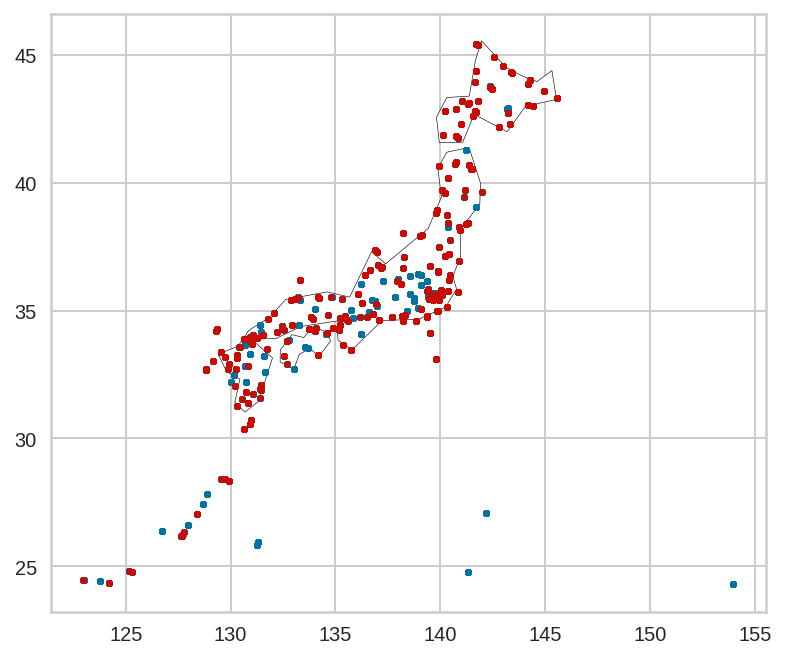

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("All time in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                geometry
14808    476800      99999  ...                  18  POINT (139.394 35.514)
18955    476170      99999  ...                  74    POINT (137.25 36.15)
23752    476800      99999  ...                  21  POINT (139.394 35.514)
54148    478724      99999  ...                  26  POINT (129.928 28.321)
60601    478724      99999  ...                  88  POINT (129.928 28.321)
...         ...        ...  ...                 ...                     ...
4102294  478220      99999  ...                  81   POINT (131.65 32.583)
4102305  475700      99999  ...                  56  POINT (139.917 37.483)
4102308  476420      43313  ...                  40    POINT (139.35 35.75)
4102312  477650      99999  ...                  68    POINT (132.467 34.4)
4102315  478970      99999  ...                  76    POINT (132.7 32.917)

[22692 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
1st quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 1061.
Number of areas in map both red and blue points : 22692.


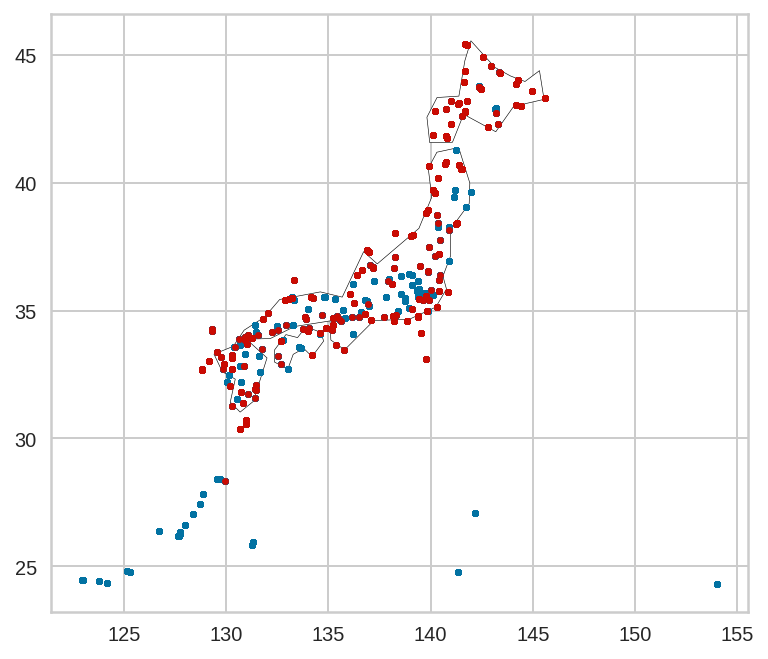

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("1st quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                geometry
22855    479330      42215  ...                 101   POINT (127.75 26.267)
26867    479270      99999  ...                 143  POINT (125.295 24.783)
27952    476800      99999  ...                 134  POINT (139.394 35.514)
39582    478724      99999  ...                 182  POINT (129.928 28.321)
40498    478724      99999  ...                 172  POINT (129.928 28.321)
...         ...        ...  ...                 ...                     ...
4102309  476420      43313  ...                 106    POINT (139.35 35.75)
4102325  478380      99999  ...                 106    POINT (130.033 32.2)
4102327  476570      99999  ...                  98  POINT (138.933 35.117)
4102559  476240      99999  ...                 110    POINT (139.067 36.4)
4107396  475880      99999  ...                 121    POINT (140.35 38.25)

[22184 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
2nd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 472.
Number of areas in map both red and blue points : 22184.


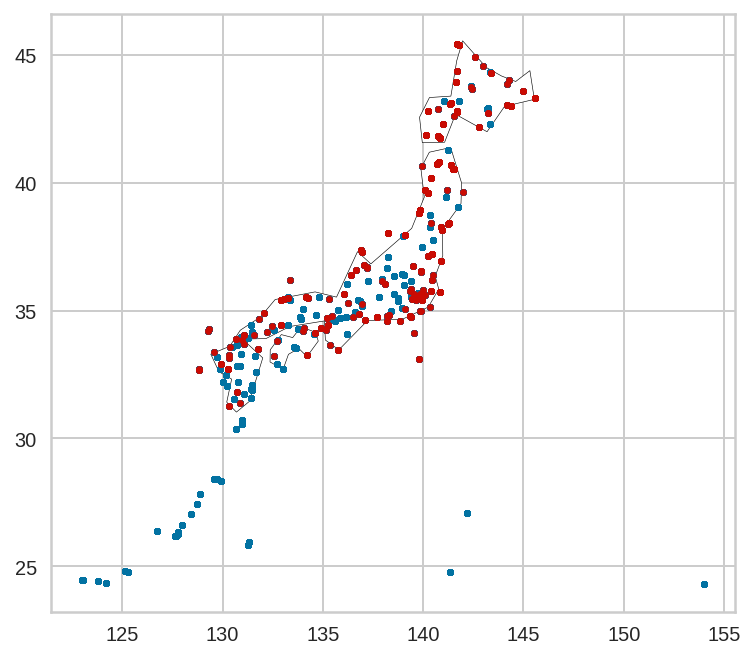

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("2nd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                geometry
26427    479310      42204  ...                 264   POINT (127.767 26.35)
34529    476800      99999  ...                 267  POINT (139.394 35.514)
35956    476900      99999  ...                 249    POINT (139.5 36.733)
36836    476900      99999  ...                 245    POINT (139.5 36.733)
38679    476900      99999  ...                 213    POINT (139.5 36.733)
...         ...        ...  ...                 ...                     ...
4102313  477650      99999  ...                 259    POINT (132.467 34.4)
4102318  477400      99999  ...                 215    POINT (133.333 36.2)
4102319  477400      99999  ...                 262    POINT (133.333 36.2)
4102560  476240      99999  ...                 234    POINT (139.067 36.4)
4102561  476240      99999  ...                 246    POINT (139.067 36.4)

[22945 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
3rd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 28.
Number of areas in map both red and blue points : 22945.


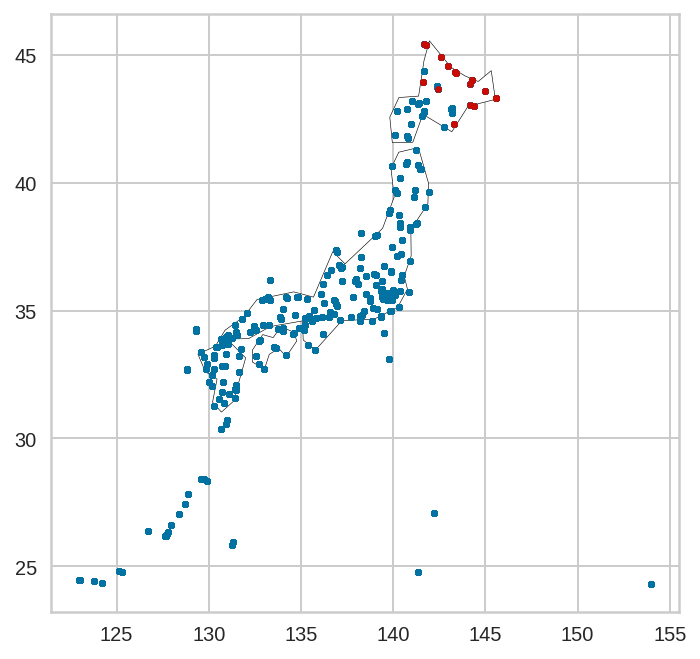

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("3rd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                geometry
17797    478980      99999  ...                 357  POINT (133.017 32.717)
17875    478990      99999  ...                 357   POINT (134.183 33.25)
17955    477680      99999  ...                 357  POINT (133.917 34.683)
18234    476200      99999  ...                 357   POINT (138.117 36.05)
18307    475970      99999  ...                 357  POINT (140.217 37.133)
...         ...        ...  ...                 ...                     ...
4102304  478430      99999  ...                 318    POINT (128.833 32.7)
4102311  479910      99999  ...                 337   POINT (153.979 24.29)
4102316  478970      99999  ...                 285    POINT (132.7 32.917)
4102317  474120      99999  ...                 281  POINT (141.333 43.067)
4102326  478380      99999  ...                 279    POINT (130.033 32.2)

[21713 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
4th quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 488.
Number of areas in map both red and blue points : 21713.


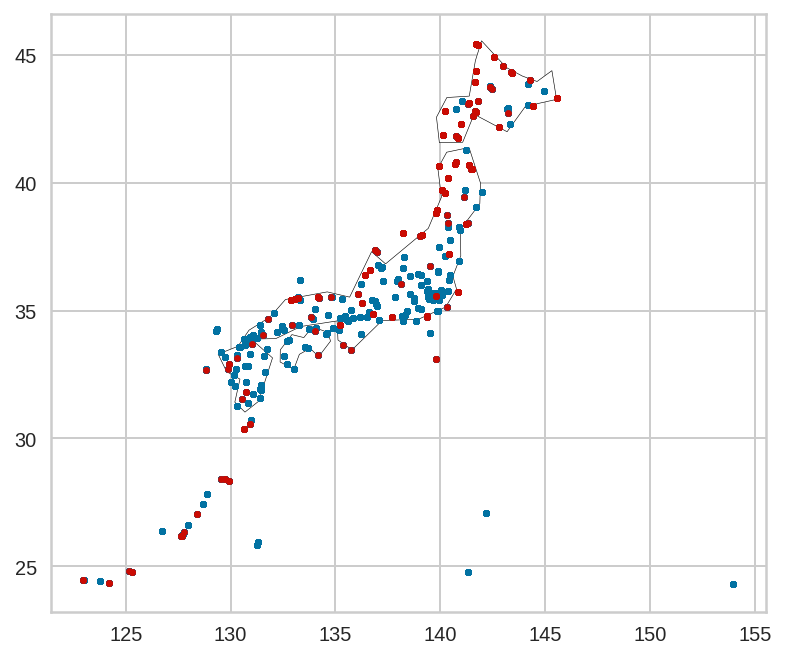

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("4th quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
1806     478990      99999  2021  ...  2021-05-18  2021-05-18                 139
2042     476020      99999  2021  ...  2021-02-21  2021-02-21                  52
2043     477680      99999  2021  ...  2021-02-21  2021-02-21                  52
2107     475920      99999  2021  ...  2021-02-21  2021-02-21                  52
2279     476320      99999  2021  ...  2021-02-21  2021-02-21                  52
...         ...        ...   ...  ...         ...         ...                 ...
3433056  478910      99999  2021  ...  2021-02-17  2021-02-17                  48
3433057  478910      99999  2021  ...  2021-10-11  2021-10-11                 285
3433065  478090      99999  2021  ...  2021-02-22  2021-02-22                  53
3437600  479120      99999  2021  ...  2021-01-18  2021-01-18                  18
3437601  479120      99999  2021  ...  2021-06-23  2021-06-23                 175

[76589 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
All time in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 1886.
Number of areas in map both red and blue points : 76589.


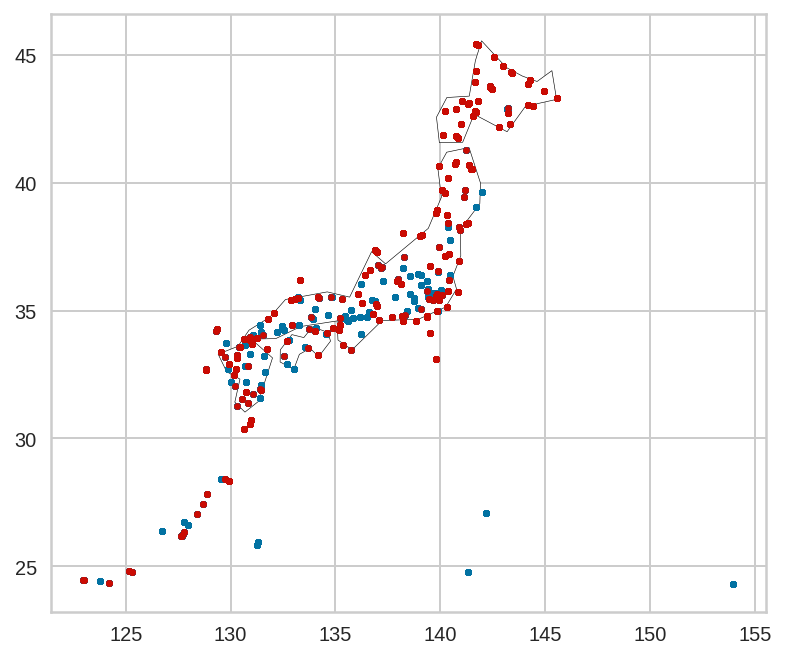

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("All time in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
2042     476020      99999  2021  ...  2021-02-21  2021-02-21                  52
2043     477680      99999  2021  ...  2021-02-21  2021-02-21                  52
2107     475920      99999  2021  ...  2021-02-21  2021-02-21                  52
2279     476320      99999  2021  ...  2021-02-21  2021-02-21                  52
2379     476200      99999  2021  ...  2021-02-21  2021-02-21                  52
...         ...        ...   ...  ...         ...         ...                 ...
3433045  475120      99999  2021  ...  2021-01-20  2021-01-20                  20
3433052  476000      99999  2021  ...  2021-02-07  2021-02-07                  38
3433056  478910      99999  2021  ...  2021-02-17  2021-02-17                  48
3433065  478090      99999  2021  ...  2021-02-22  2021-02-22                  53
3437600  479120      99999  2021  ...  2021-01-18  2021-01-18                  18

[20887 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
1st quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 1345.
Number of areas in map both red and blue points : 20887.


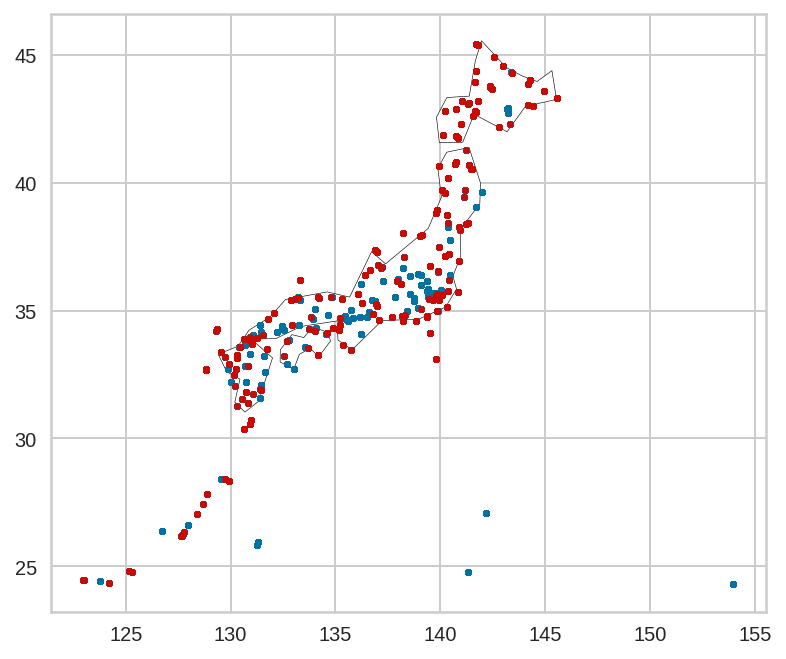

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("1st quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
1806     478990      99999  2021  ...  2021-05-18  2021-05-18                 139
20564    476490      99999  2021  ...  2021-06-22  2021-06-22                 174
20641    478310      99999  2021  ...  2021-06-22  2021-06-22                 174
20790    478050      99999  2021  ...  2021-06-22  2021-06-22                 174
21038    476180      99999  2021  ...  2021-06-22  2021-06-22                 174
...         ...        ...   ...  ...         ...         ...                 ...
3433043  476310      99999  2021  ...  2021-05-09  2021-05-09                 130
3433044  476310      99999  2021  ...  2021-06-26  2021-06-26                 178
3433046  475120      99999  2021  ...  2021-04-16  2021-04-16                 107
3433047  475120      99999  2021  ...  2021-05-14  2021-05-14                 135
3437601  479120      99999  2021  ...  2021-06-23  2021-06-23                 175

[22648 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
2nd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 383.
Number of areas in map both red and blue points : 22648.


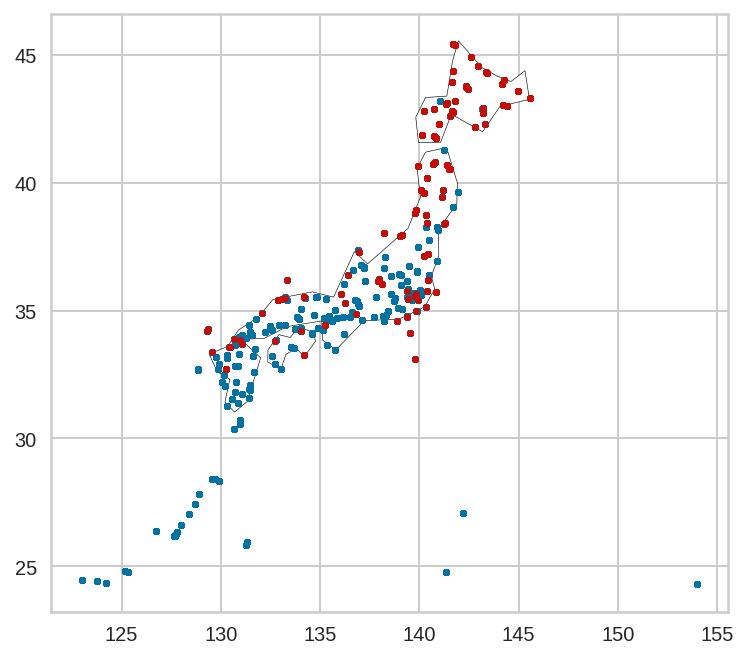

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("2nd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
16937    478180      99999  2021  ...  2021-07-14  2021-07-14                 196
22659    478180      99999  2021  ...  2021-07-19  2021-07-19                 201
24770    479380      99999  2021  ...  2021-09-20  2021-09-20                 264
29544    476800      99999  2021  ...  2021-07-08  2021-07-08                 190
29686    479330      42215  2021  ...  2021-08-12  2021-08-12                 225
...         ...        ...   ...  ...         ...         ...                 ...
3433039  476510      99999  2021  ...  2021-09-27  2021-09-27                 271
3433048  476480      99999  2021  ...  2021-07-26  2021-07-26                 208
3433049  476480      99999  2021  ...  2021-08-10  2021-08-10                 223
3433050  476480      99999  2021  ...  2021-08-28  2021-08-28                 241
3433053  476000      99999  2021  ...  2021-09-09  2021-09-09                 253

[22987 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
3rd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 24.
Number of areas in map both red and blue points : 22987.


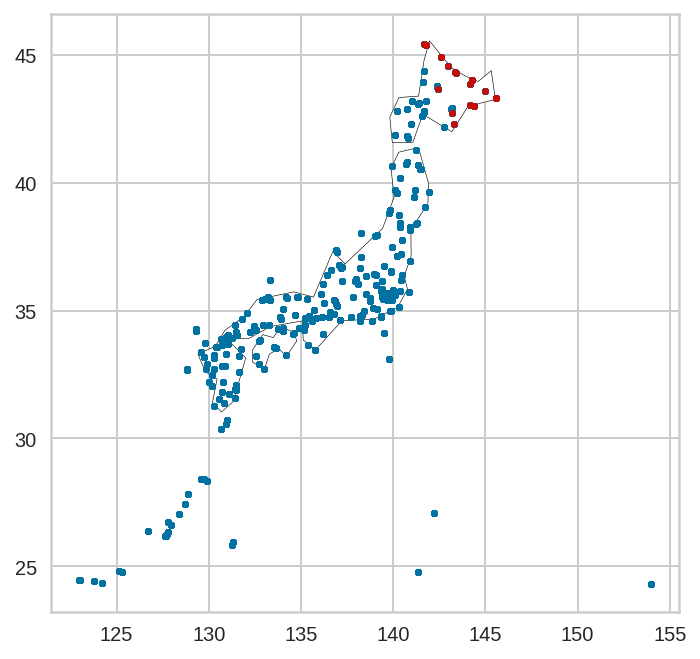

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("3rd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
25065    476800      99999  2021  ...  2021-10-22  2021-10-22                 296
32696    479380      99999  2021  ...  2021-10-21  2021-10-21                 295
55265    476390      99999  2021  ...  2021-10-12  2021-10-12                 286
65135    479110      99999  2021  ...  2021-10-11  2021-10-11                 285
74946    479110      99999  2021  ...  2021-10-15  2021-10-15                 289
...         ...        ...   ...  ...         ...         ...                 ...
3433021  478230      99999  2021  ...  2021-10-30  2021-10-30                 304
3433022  478230      99999  2021  ...  2021-11-04  2021-11-04                 309
3433051  476480      99999  2021  ...  2021-10-03  2021-10-03                 277
3433054  475820      99999  2021  ...  2021-10-13  2021-10-13                 287
3433057  478910      99999  2021  ...  2021-10-11  2021-10-11                 285

[10067 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Japan
4th quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 134.
Number of areas in map both red and blue points : 10067.


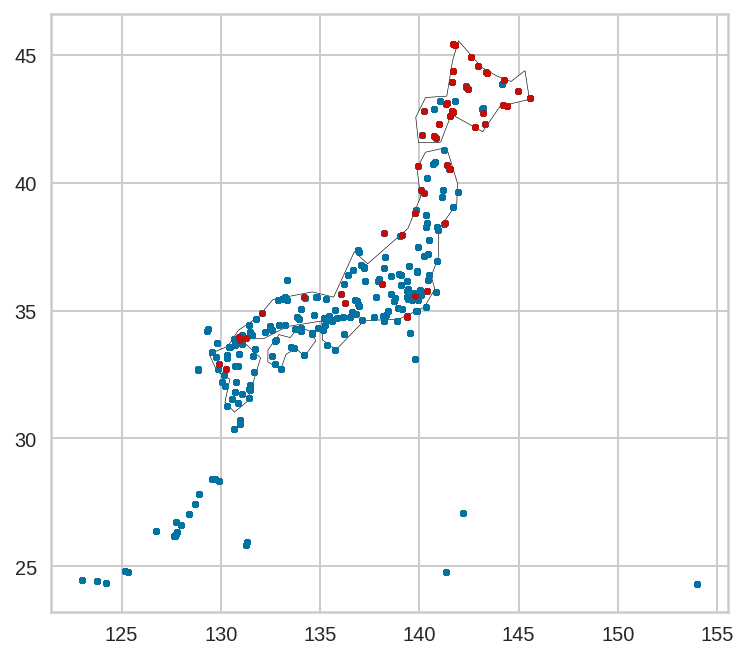

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Japan")
print("4th quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                          geometry
262       38090  ...  POINT (-5.256 50.08600000000001)
1909     888970  ...           POINT (-59.083 -52.433)
2006      37690  ...             POINT (-0.229 51.144)
2365     888970  ...           POINT (-59.083 -52.433)
2474      31580  ...               POINT (-2.383 55.7)
...         ...  ...                               ...
4106616  888780  ...             POINT (-59.6 -51.317)
4106617  888780  ...             POINT (-59.6 -51.317)
4106618  888780  ...             POINT (-59.6 -51.317)
4106619  888780  ...             POINT (-59.6 -51.317)
4106620  888780  ...             POINT (-59.6 -51.317)

[70891 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
All time in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 22066.
Number of areas in map both red and blue points : 70891.


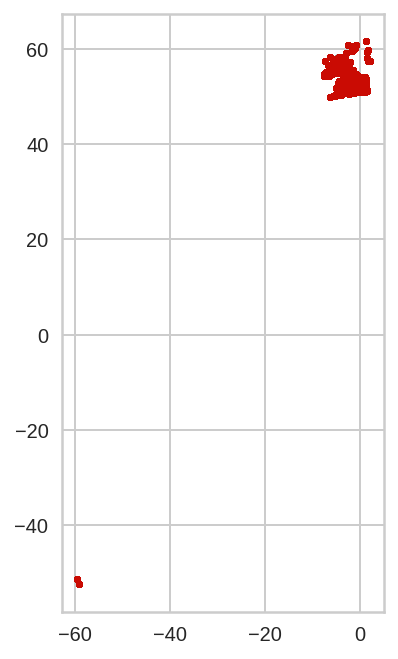

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("All time in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
3835      36800  ...                POINT (-0.358 51.8)
4654      38660  ...                POINT (-1.3 50.583)
5234      33130  ...                 POINT (-3.5 53.25)
8509      30340  ...  POINT (-5.632999999999999 57.867)
11774     30340  ...  POINT (-5.632999999999999 57.867)
...         ...  ...                                ...
4100332   36090  ...              POINT (-3.983 51.567)
4100359   35200  ...               POINT (-2.883 52.25)
4100360   35200  ...               POINT (-2.883 52.25)
4106055  749005  ...               POINT (1.162 52.457)
4106614  888780  ...              POINT (-59.6 -51.317)

[17840 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
1st quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 9725.
Number of areas in map both red and blue points : 17840.


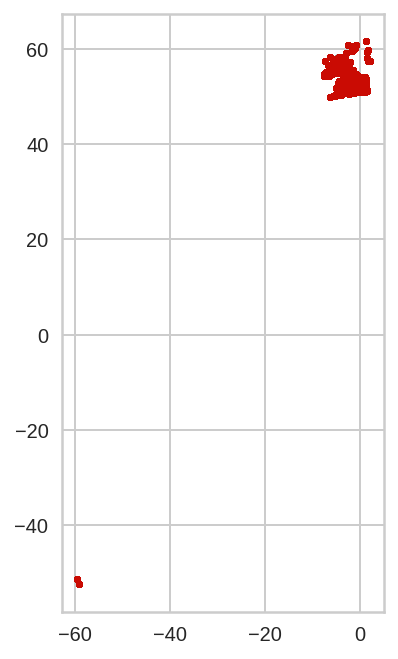

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("1st quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
2474      31580  ...                POINT (-2.383 55.7)
3108      30230  ...  POINT (-7.367000000000001 57.333)
5482      35030  ...                POINT (-3.95 52.35)
7644     888970  ...            POINT (-59.083 -52.433)
8384     888970  ...            POINT (-59.083 -52.433)
...         ...  ...                                ...
4100286   39150  ...               POINT (-6.45 54.867)
4106438  888970  ...            POINT (-59.083 -52.433)
4106615  888780  ...              POINT (-59.6 -51.317)
4106616  888780  ...              POINT (-59.6 -51.317)
4106617  888780  ...              POINT (-59.6 -51.317)

[17192 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
2nd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 3177.
Number of areas in map both red and blue points : 17192.


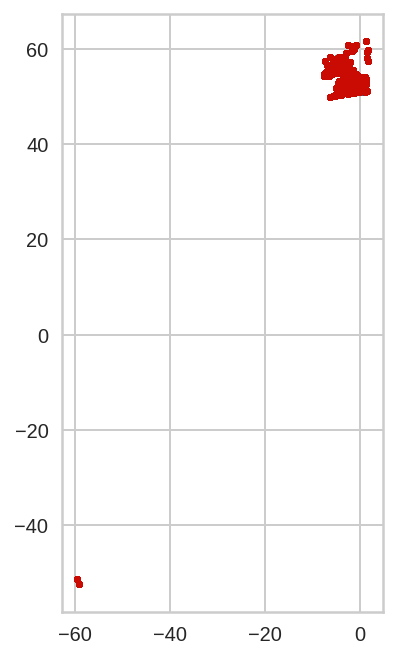

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("2nd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                          geometry
262       38090  ...  POINT (-5.256 50.08600000000001)
1909     888970  ...           POINT (-59.083 -52.433)
2006      37690  ...             POINT (-0.229 51.144)
2365     888970  ...           POINT (-59.083 -52.433)
4305      39070  ...              POINT (-6.933 55.15)
...         ...  ...                               ...
4106056  749005  ...              POINT (1.162 52.457)
4106057  749005  ...              POINT (1.162 52.457)
4106439  888970  ...           POINT (-59.083 -52.433)
4106618  888780  ...             POINT (-59.6 -51.317)
4106619  888780  ...             POINT (-59.6 -51.317)

[17858 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
3rd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 2393.
Number of areas in map both red and blue points : 17858.


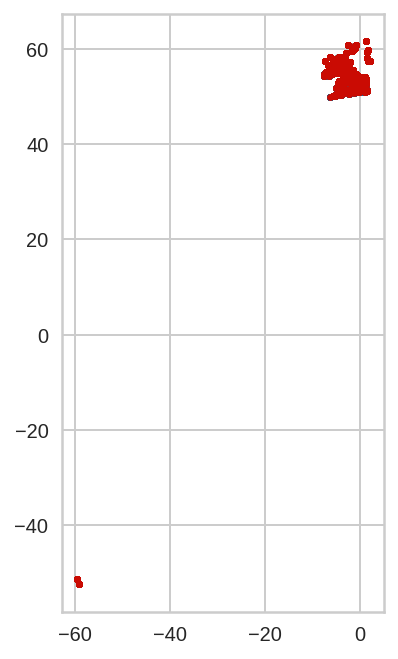

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("3rd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
11849     31620  ...                POINT (-3.2 55.317)
19952     30620  ...              POINT (-3.967 57.817)
20952     30340  ...  POINT (-5.632999999999999 57.867)
21899     31000  ...              POINT (-6.869 56.499)
22291     36440  ...               POINT (-1.79 51.682)
...         ...  ...                                ...
4100336   36090  ...              POINT (-3.983 51.567)
4100337   36090  ...              POINT (-3.983 51.567)
4100363   35200  ...               POINT (-2.883 52.25)
4106058  749005  ...               POINT (1.162 52.457)
4106620  888780  ...              POINT (-59.6 -51.317)

[18001 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
4th quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 6771.
Number of areas in map both red and blue points : 18001.


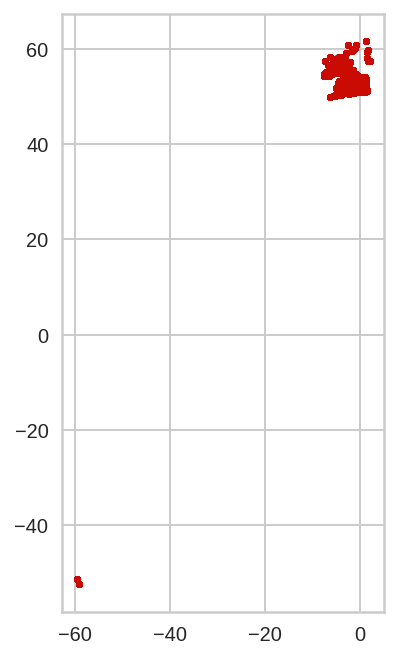

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("4th quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
1972      31530      99999  2021  ...  2021-02-20  2021-02-20                  51
2004      38000      99999  2021  ...  2021-07-21  2021-07-21                 203
2155      30050      99999  2021  ...  2021-02-20  2021-02-20                  51
2161      38000      99999  2021  ...  2021-07-14  2021-07-14                 196
2433      32250      99999  2021  ...  2021-02-20  2021-02-20                  51
...         ...        ...   ...  ...         ...         ...                 ...
3436621  888970      99999  2021  ...  2021-04-20  2021-04-20                 111
3436622  888970      99999  2021  ...  2021-07-09  2021-07-09                 191
3436635  888780      99999  2021  ...  2021-02-05  2021-02-05                  36
3436636  888780      99999  2021  ...  2021-02-24  2021-02-24                  55
3436637  888780      99999  2021  ...  2021-03-28  2021-03-28                  88

[60471 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
All time in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 12420.
Number of areas in map both red and blue points : 60471.


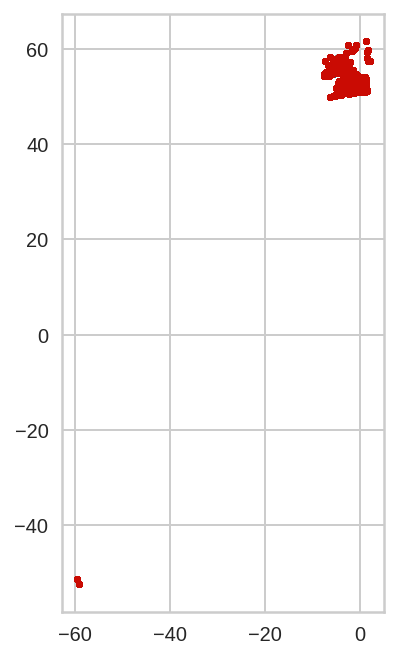

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("All time in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
1972      31530      99999  2021  ...  2021-02-20  2021-02-20                  51
2155      30050      99999  2021  ...  2021-02-20  2021-02-20                  51
2433      32250      99999  2021  ...  2021-02-20  2021-02-20                  51
2434      32100      99999  2021  ...  2021-02-20  2021-02-20                  51
2951      30020      99999  2021  ...  2021-02-20  2021-02-20                  51
...         ...        ...   ...  ...         ...         ...                 ...
3436190  749005      99999  2021  ...  2021-01-01  2021-01-01                   1
3436191  749005      99999  2021  ...  2021-03-21  2021-03-21                  81
3436635  888780      99999  2021  ...  2021-02-05  2021-02-05                  36
3436636  888780      99999  2021  ...  2021-02-24  2021-02-24                  55
3436637  888780      99999  2021  ...  2021-03-28  2021-03-28                  88

[16899 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
1st quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 6180.
Number of areas in map both red and blue points : 16899.


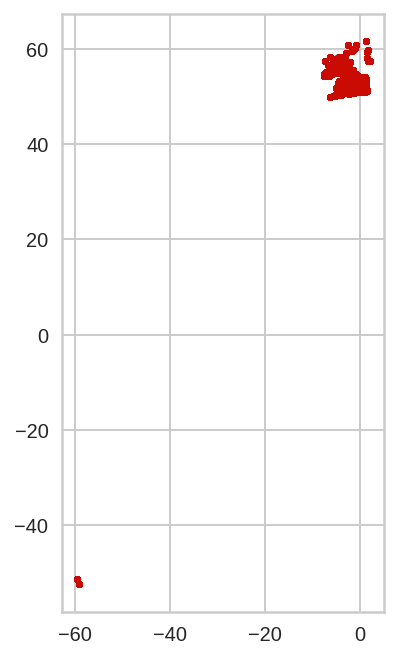

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("1st quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
2849     888970      99999  2021  ...  2021-05-23  2021-05-23                 144
4227      34620      99999  2021  ...  2021-06-20  2021-06-20                 172
4228      38000      99999  2021  ...  2021-06-02  2021-06-02                 154
10379     30620      99999  2021  ...  2021-06-14  2021-06-14                 166
11817     32240      99999  2021  ...  2021-05-16  2021-05-16                 137
...         ...        ...   ...  ...         ...         ...                 ...
3431392   38720      99999  2021  ...  2021-04-15  2021-04-15                 106
3431393   38720      99999  2021  ...  2021-06-03  2021-06-03                 155
3432427   39110      99999  2021  ...  2021-04-19  2021-04-19                 110
3432507   38820      99999  2021  ...  2021-04-02  2021-04-02                  93
3436621  888970      99999  2021  ...  2021-04-20  2021-04-20                 111

[17468 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
2nd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 2919.
Number of areas in map both red and blue points : 17468.


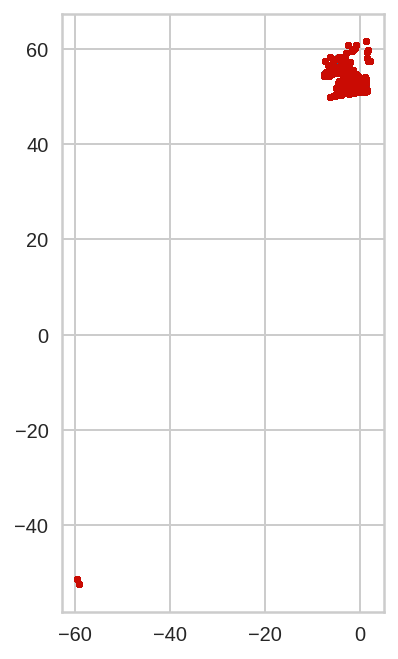

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("2nd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
2004      38000      99999  2021  ...  2021-07-21  2021-07-21                 203
2161      38000      99999  2021  ...  2021-07-14  2021-07-14                 196
2435      33050      99999  2021  ...  2021-08-09  2021-08-09                 222
9188     888780      99999  2021  ...  2021-07-08  2021-07-08                 190
9566      38000      99999  2021  ...  2021-09-09  2021-09-09                 253
...         ...        ...   ...  ...         ...         ...                 ...
3431307   33820      99999  2021  ...  2021-07-30  2021-07-30                 212
3431353   36930      99999  2021  ...  2021-09-11  2021-09-11                 255
3432508   38820      99999  2021  ...  2021-08-19  2021-08-19                 232
3432509   38820      99999  2021  ...  2021-09-20  2021-09-20                 264
3436622  888970      99999  2021  ...  2021-07-09  2021-07-09                 191

[18143 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
3rd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 1015.
Number of areas in map both red and blue points : 18143.


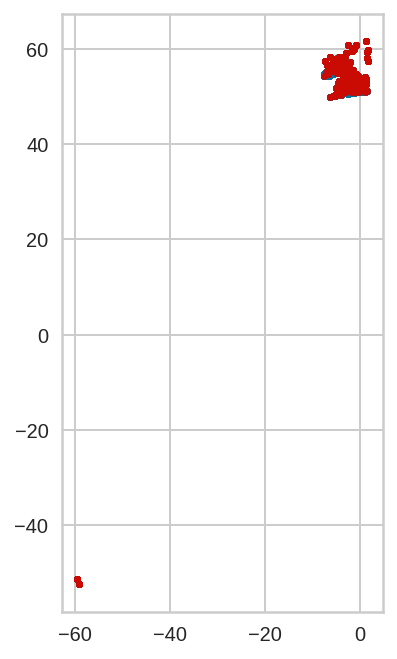

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("3rd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
4831     30620      99999  2021  ...  2021-11-04  2021-11-04                 309
7648     34880      99999  2021  ...  2021-10-18  2021-10-18                 292
9564     30800      99999  2021  ...  2021-10-04  2021-10-04                 278
13422    32240      99999  2021  ...  2021-10-08  2021-10-08                 282
13756    38000      99999  2021  ...  2021-10-27  2021-10-27                 301
...        ...        ...   ...  ...         ...         ...                 ...
3431209  39160      99999  2021  ...  2021-10-11  2021-10-11                 285
3431218  37690      99999  2021  ...  2021-11-03  2021-11-03                 308
3431234  37970      35047  2021  ...  2021-11-07  2021-11-07                 312
3431318  39010      99999  2021  ...  2021-10-09  2021-10-09                 283
3432510  38820      99999  2021  ...  2021-11-08  2021-11-08                 313

[7961 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United Kingdom
4th quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 2306.
Number of areas in map both red and blue points : 7961.


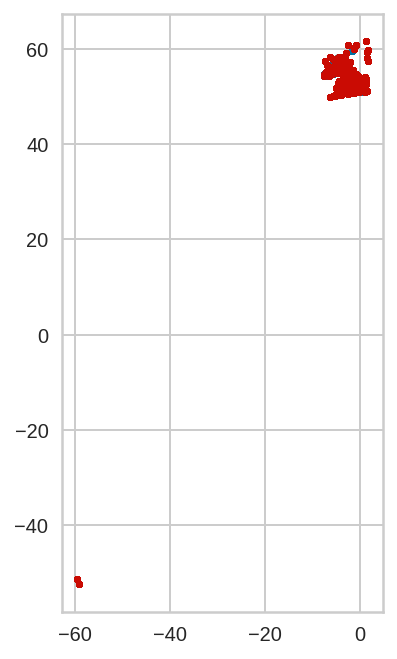

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United Kingdom")
print("4th quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                          geometry
4        997701  ...  POINT (-82.56999999999999 27.63)
6        997994  ...              POINT (-76.7 38.767)
7        998252  ...                POINT (-68.2 44.4)
9        997782  ...            POINT (-76.417 36.967)
15       994008  ...               POINT (-82.8 28.12)
...         ...  ...                               ...
4107406  998175  ...           POINT (-120.733 35.167)
4107407  998175  ...           POINT (-120.733 35.167)
4107408  998175  ...           POINT (-120.733 35.167)
4107413  997295  ...  POINT (-83.40000000000001 41.68)
4107417  997993  ...             POINT (-70.833 43.05)

[952607 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
All time in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 44617.
Number of areas in map both red and blue points : 952607.


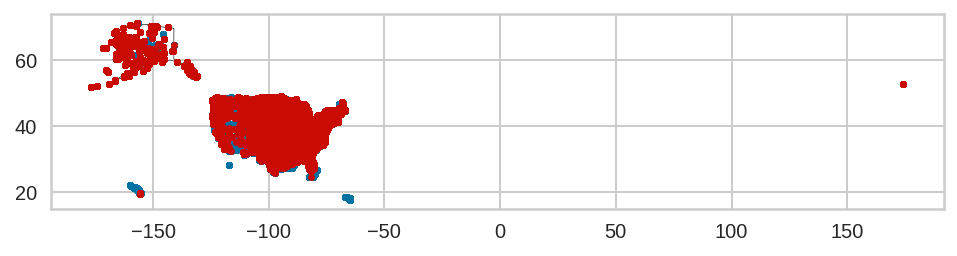

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("All time in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
6        997994  ...               POINT (-76.7 38.767)
15       994008  ...                POINT (-82.8 28.12)
16       994029  ...            POINT (-123.965 46.708)
19       998405  ...  POINT (-86.346 44.24800000000001)
21       998409  ...              POINT (-76.48 38.983)
...         ...  ...                                ...
4107378  994190  ...               POINT (-90.73 47.08)
4107384  999999  ...            POINT (-112.363 38.958)
4107405  998175  ...            POINT (-120.733 35.167)
4107406  998175  ...            POINT (-120.733 35.167)
4107417  997993  ...              POINT (-70.833 43.05)

[238639 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
1st quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 18826.
Number of areas in map both red and blue points : 238639.


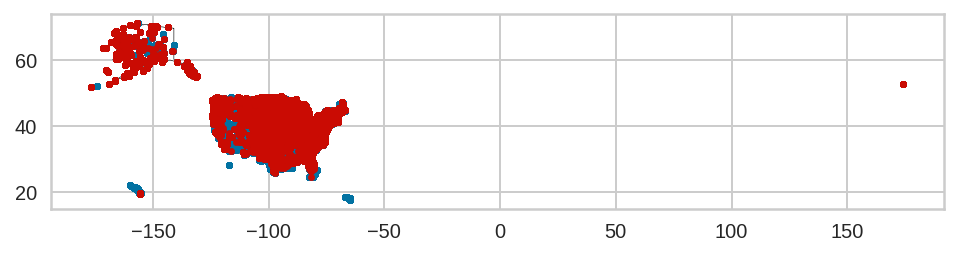

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("1st quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                                      geometry
20       998012  ...               POINT (-86.48299999999998 42.1)
70       997708  ...                          POINT (-76.33 37.25)
83       998440  ...  POINT (-88.21299999999999 30.25800000000001)
99       998012  ...               POINT (-86.48299999999998 42.1)
110      997277  ...                          POINT (-71.33 41.72)
...         ...  ...                                           ...
4107392  702600  ...                        POINT (-149.072 64.55)
4107393  702600  ...                        POINT (-149.072 64.55)
4107394  702600  ...                        POINT (-149.072 64.55)
4107407  998175  ...                       POINT (-120.733 35.167)
4107408  998175  ...                       POINT (-120.733 35.167)

[237374 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
2nd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 7914.
Number of areas in map both red and blue points : 237374.


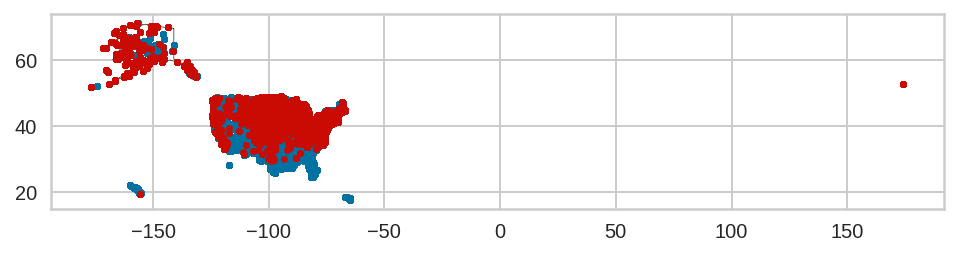

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("2nd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
4        997701  ...   POINT (-82.56999999999999 27.63)
7        998252  ...                 POINT (-68.2 44.4)
9        997782  ...             POINT (-76.417 36.967)
17       997281  ...               POINT (-75.12 38.78)
22       997356  ...   POINT (-81.09999999999999 24.72)
...         ...  ...                                ...
4107342  994450  ...               POINT (-81.11 24.63)
4107367  723235  ...  POINT (-87.59999999999999 34.744)
4107376  997293  ...   POINT (-82.90000000000001 41.55)
4107385  999999  ...            POINT (-112.363 38.958)
4107413  997295  ...   POINT (-83.40000000000001 41.68)

[238497 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
3rd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 3331.
Number of areas in map both red and blue points : 238497.


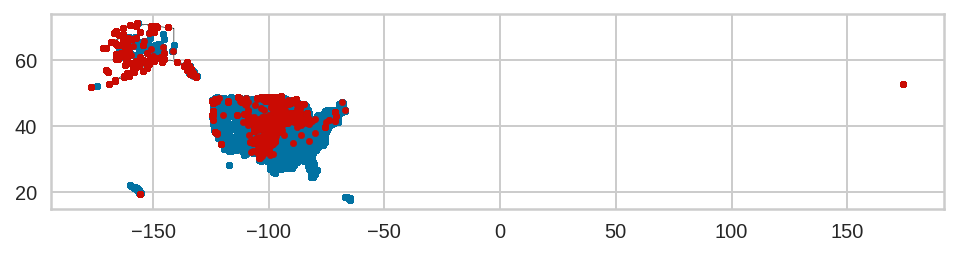

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("3rd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                          geometry
18       997372  ...   POINT (-75.56999999999999 39.9)
68       997787  ...  POINT (-87.15000000000001 41.65)
73       997982  ...            POINT (-85.867 45.967)
123      998226  ...             POINT (-97.05 28.017)
143      997372  ...   POINT (-75.56999999999999 39.9)
...         ...  ...                               ...
4107353  998213  ...             POINT (-82.583 27.65)
4107377  997293  ...  POINT (-82.90000000000001 41.55)
4107380  994190  ...              POINT (-90.73 47.08)
4107381  994190  ...              POINT (-90.73 47.08)
4107395  702600  ...            POINT (-149.072 64.55)

[238097 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
4th quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 14546.
Number of areas in map both red and blue points : 238097.


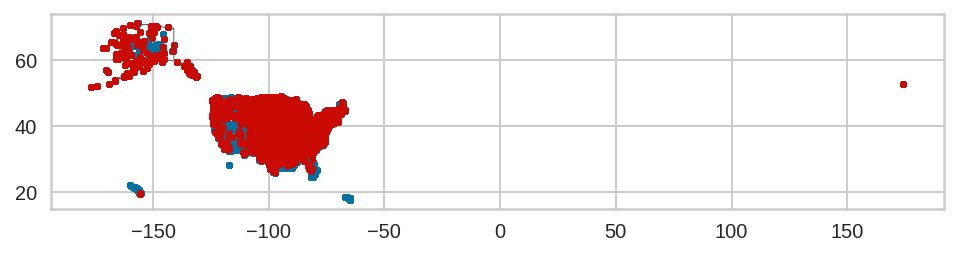

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("4th quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
6        724295      63888  2021  ...  2021-08-17  2021-08-17                 230
7        724397      54831  2021  ...  2021-10-06  2021-10-06                 280
11       994008      99999  2021  ...  2021-11-07  2021-11-07                 312
12       997174      99999  2021  ...  2021-06-01  2021-06-01                 153
13       994028      99999  2021  ...  2021-06-01  2021-06-01                 153
...         ...        ...   ...  ...         ...         ...                 ...
3437680  999999      13752  2021  ...  2021-01-30  2021-01-30                  30
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174

[809669 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
All time in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 31166.
Number of areas in map both red and blue points : 809669.


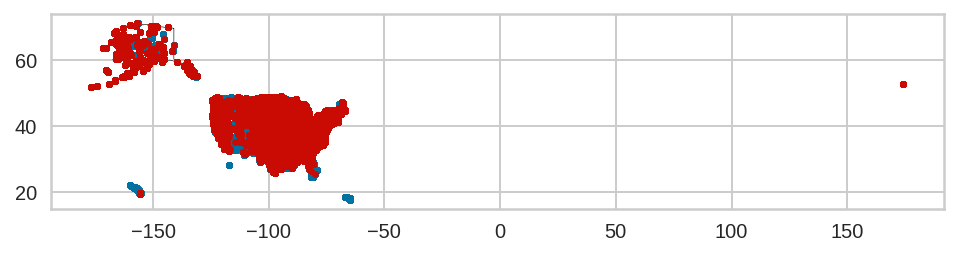

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("All time in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
14       994029      99999  2021  ...  2021-01-08  2021-01-08                   8
15       997279      99999  2021  ...  2021-03-19  2021-03-19                  79
16       997386      99999  2021  ...  2021-03-19  2021-03-19                  79
18       998243      99999  2021  ...  2021-02-13  2021-02-13                  44
23       998245      99999  2021  ...  2021-01-17  2021-01-17                  17
...         ...        ...   ...  ...         ...         ...                 ...
3437634  997994      99999  2021  ...  2021-03-07  2021-03-07                  67
3437638  994350      99999  2021  ...  2021-01-02  2021-01-02                   2
3437639  994350      99999  2021  ...  2021-02-16  2021-02-16                  47
3437680  999999      13752  2021  ...  2021-01-30  2021-01-30                  30
3437694  998473      99999  2021  ...  2021-01-02  2021-01-02                   2

[228781 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
1st quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 16943.
Number of areas in map both red and blue points : 228781.


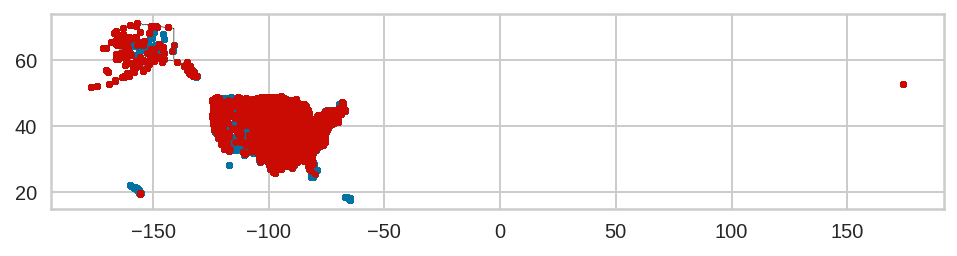

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("1st quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
12       997174      99999  2021  ...  2021-06-01  2021-06-01                 153
13       994028      99999  2021  ...  2021-06-01  2021-06-01                 153
17       997782      99999  2021  ...  2021-06-01  2021-06-01                 153
19       998208      99999  2021  ...  2021-06-02  2021-06-02                 154
20       998490      99999  2021  ...  2021-05-26  2021-05-26                 147
...         ...        ...   ...  ...         ...         ...                 ...
3437654  998005      99999  2021  ...  2021-06-23  2021-06-23                 175
3437655  998005      99999  2021  ...  2021-06-26  2021-06-26                 178
3437692  999999        481  2021  ...  2021-04-28  2021-04-28                 119
3437693  999999        481  2021  ...  2021-05-09  2021-05-09                 130
3437695  998473      99999  2021  ...  2021-06-22  2021-06-22                 174

[237308 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
2nd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 6612.
Number of areas in map both red and blue points : 237308.


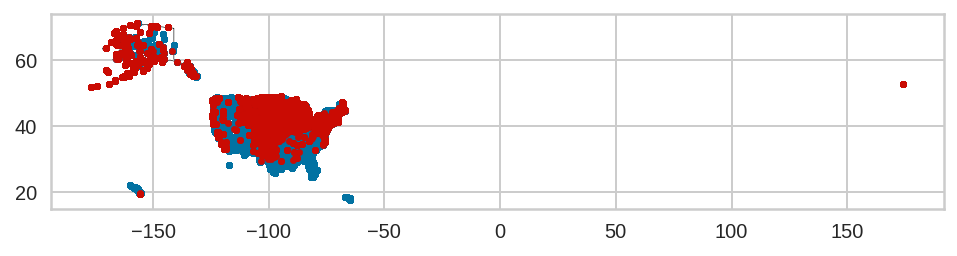

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("2nd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
6        724295      63888  2021  ...  2021-08-17  2021-08-17                 230
22       997736      99999  2021  ...  2021-07-22  2021-07-22                 204
31       998012      99999  2021  ...  2021-07-23  2021-07-23                 205
33       994660      99999  2021  ...  2021-07-23  2021-07-23                 205
44       994090      99999  2021  ...  2021-07-22  2021-07-22                 204
...         ...        ...   ...  ...         ...         ...                 ...
3437603  998013      99999  2021  ...  2021-07-28  2021-07-28                 210
3437610  997697      99999  2021  ...  2021-07-27  2021-07-27                 209
3437618  998014      99999  2021  ...  2021-08-17  2021-08-17                 230
3437649  997295      99999  2021  ...  2021-09-21  2021-09-21                 265
3437656  998005      99999  2021  ...  2021-09-29  2021-09-29                 273

[237928 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
3rd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 2849.
Number of areas in map both red and blue points : 237928.


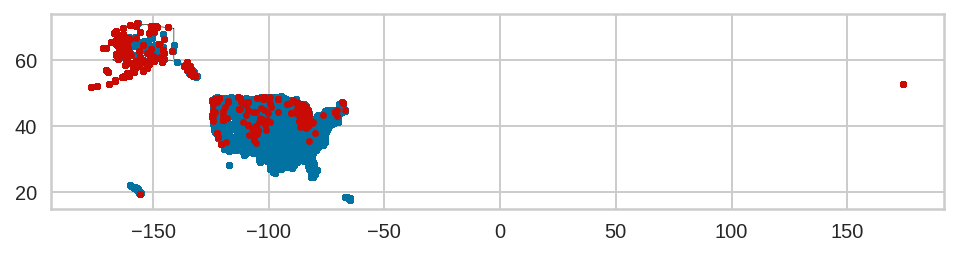

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("3rd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
7        724397      54831  2021  ...  2021-10-06  2021-10-06                 280
11       994008      99999  2021  ...  2021-11-07  2021-11-07                 312
111      726455      94897  2021  ...  2021-10-01  2021-10-01                 275
260      998208      99999  2021  ...  2021-11-09  2021-11-09                 314
467      703888        111  2021  ...  2021-10-07  2021-10-07                 281
...         ...        ...   ...  ...         ...         ...                 ...
3437581  998017      99999  2021  ...  2021-10-24  2021-10-24                 298
3437590  997990      99999  2021  ...  2021-10-13  2021-10-13                 287
3437616  998011      99999  2021  ...  2021-10-27  2021-10-27                 301
3437623  998281      99999  2021  ...  2021-10-07  2021-10-07                 281
3437657  998005      99999  2021  ...  2021-11-05  2021-11-05                 310

[105652 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




United States of America
4th quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 4762.
Number of areas in map both red and blue points : 105652.


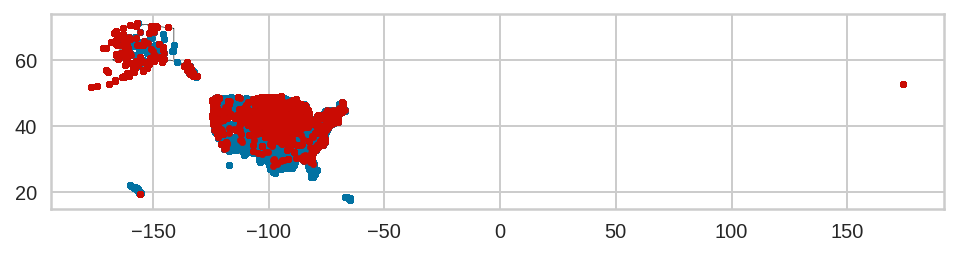

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("United States of America")
print("4th quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                            geometry
2        869900  ...              POINT (-50.135 -30.01)
11       817540  ...                POINT (-40.35 -3.75)
13       866350  ...             POINT (-41.867 -11.333)
28       868460  ...             POINT (-46.383 -21.917)
29       868460  ...             POINT (-46.383 -21.917)
...         ...  ...                                 ...
4107401  868910  ...  POINT (-41.76600000000001 -22.343)
4107402  868910  ...  POINT (-41.76600000000001 -22.343)
4107418  868990  ...             POINT (-51.933 -23.405)
4107419  868990  ...             POINT (-51.933 -23.405)
4107420  868990  ...             POINT (-51.933 -23.405)

[147288 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
All time in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 206.
Number of areas in map both red and blue points : 147288.


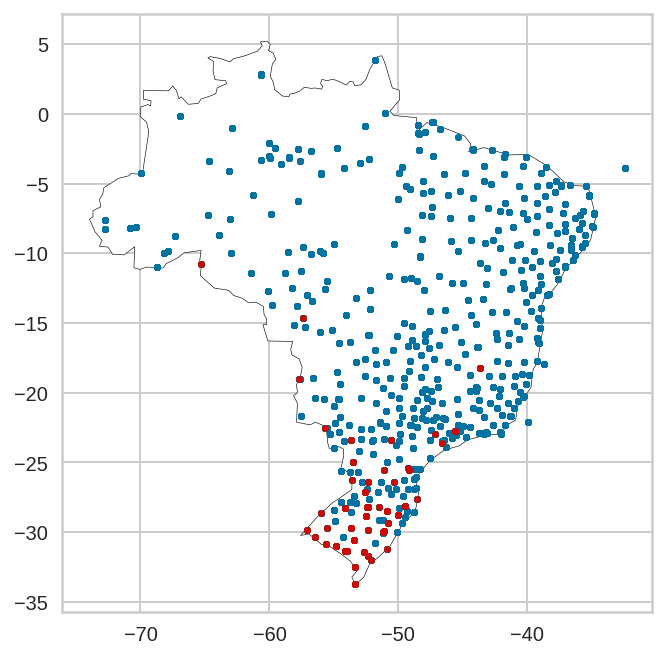

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("All time in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                 geometry
2        869900      99999  ...                  64   POINT (-50.135 -30.01)
28       868460      99999  ...                  90  POINT (-46.383 -21.917)
31       869900      99999  ...                  56   POINT (-50.135 -30.01)
102      817540      99999  ...                  37     POINT (-40.35 -3.75)
133      869710      99999  ...                  77    POINT (-49.5 -28.933)
...         ...        ...  ...                 ...                      ...
4106678  866930      99999  ...                  85      POINT (-44.4 -14.4)
4106827  868700      99999  ...                  52   POINT (-46.05 -22.867)
4106828  868700      99999  ...                  56   POINT (-46.05 -22.867)
4107053  869360      99999  ...                  66  POINT (-53.633 -26.283)
4107110  866420      99999  ...                  30   POINT (-60.15 -12.733)

[41180 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
1st quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 5.
Number of areas in map both red and blue points : 41180.


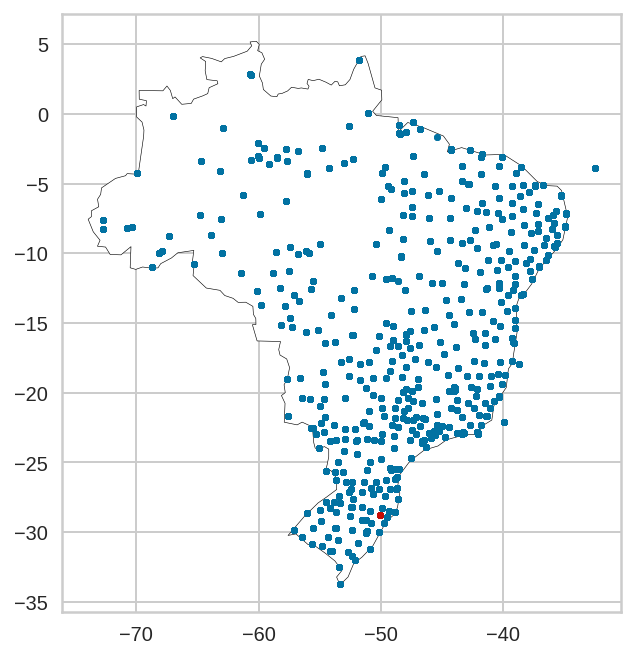

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("1st quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                            geometry
13       866350  ...             POINT (-41.867 -11.333)
60       817540  ...                POINT (-40.35 -3.75)
61       868460  ...             POINT (-46.383 -21.917)
103      817540  ...                POINT (-40.35 -3.75)
140      866280  ...             POINT (-50.733 -11.617)
...         ...  ...                                 ...
4106892  869820  ...             POINT (-56.437 -30.369)
4106893  869820  ...             POINT (-56.437 -30.369)
4107302  867120  ...             POINT (-50.133 -15.933)
4107401  868910  ...  POINT (-41.76600000000001 -22.343)
4107418  868990  ...             POINT (-51.933 -23.405)

[37800 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
2nd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 62.
Number of areas in map both red and blue points : 37800.


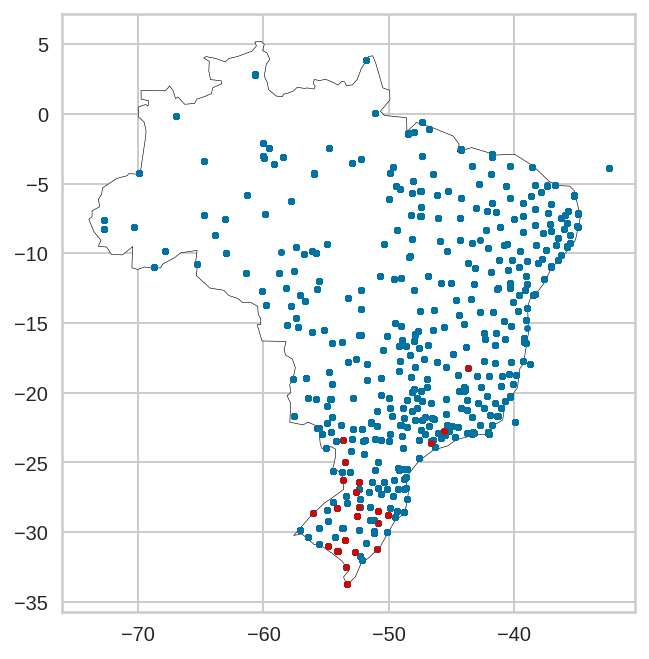

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("2nd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                            geometry
11       817540  ...                POINT (-40.35 -3.75)
46       866150  ...                POINT (-37.75 -10.4)
91       869340  ...             POINT (-48.817 -25.517)
132      817540  ...                POINT (-40.35 -3.75)
188      819550  ...                  POINT (-36.5 -8.9)
...         ...  ...                                 ...
4107077  868740  ...             POINT (-44.445 -22.451)
4107111  866420  ...              POINT (-60.15 -12.733)
4107300  867040  ...  POINT (-57.22600000000001 -15.325)
4107348  866740  ...             POINT (-40.117 -13.533)
4107402  868910  ...  POINT (-41.76600000000001 -22.343)

[35585 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
3rd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 104.
Number of areas in map both red and blue points : 35585.


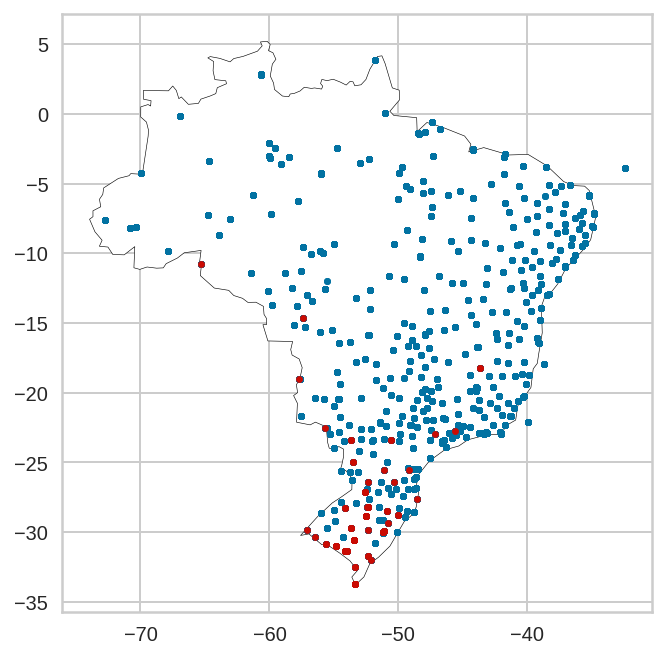

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("3rd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                 geometry
29       868460      99999  ...                 364  POINT (-46.383 -21.917)
32       868700      99999  ...                 355   POINT (-46.05 -22.867)
220      868460      99999  ...                 326  POINT (-46.383 -21.917)
270      866720      99999  ...                 308  POINT (-43.417 -13.267)
292      868700      99999  ...                 351   POINT (-46.05 -22.867)
...         ...        ...  ...                 ...                      ...
4107362  867280      99999  ...                 302   POINT (-54.567 -16.45)
4107364  867620      99999  ...                 358    POINT (-41.517 -17.9)
4107399  867770      99999  ...                 332   POINT (-47.933 -18.15)
4107419  868990      99999  ...                 280  POINT (-51.933 -23.405)
4107420  868990      99999  ...                 342  POINT (-51.933 -23.405)

[32723 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
4th quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 35.
Number of areas in map both red and blue points : 32723.


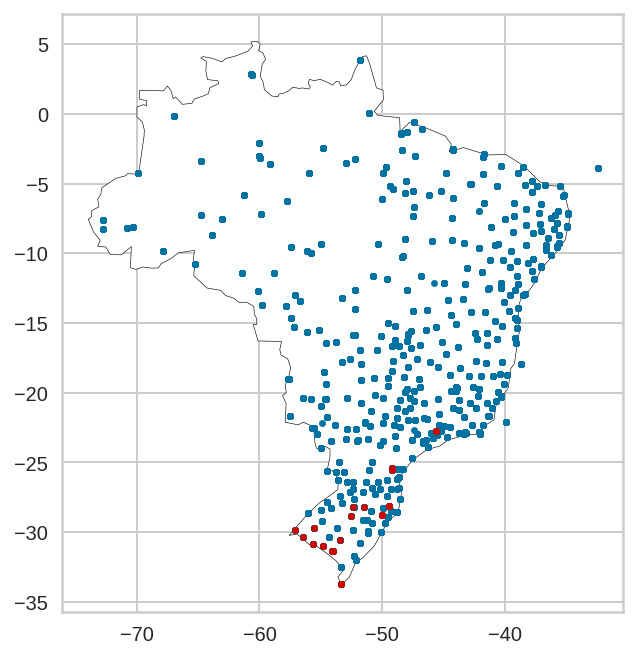

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("4th quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
8        817110      99999  2021  ...  2021-05-14  2021-05-14                 135
36       819950      99999  2021  ...  2021-07-18  2021-07-18                 200
39       869340      99999  2021  ...  2021-01-19  2021-01-19                  19
68       817840      99999  2021  ...  2021-02-26  2021-02-26                  57
112      868040      99999  2021  ...  2021-09-27  2021-09-27                 271
...         ...        ...   ...  ...         ...         ...                 ...
3437626  867770      99999  2021  ...  2021-05-23  2021-05-23                 144
3437667  867390      99999  2021  ...  2021-03-07  2021-03-07                  67
3437668  867390      99999  2021  ...  2021-05-12  2021-05-12                 133
3437669  867390      99999  2021  ...  2021-06-08  2021-06-08                 160
3437670  869770      99999  2021  ...  2021-04-16  2021-04-16                 107

[100988 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
All time in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 197.
Number of areas in map both red and blue points : 100988.


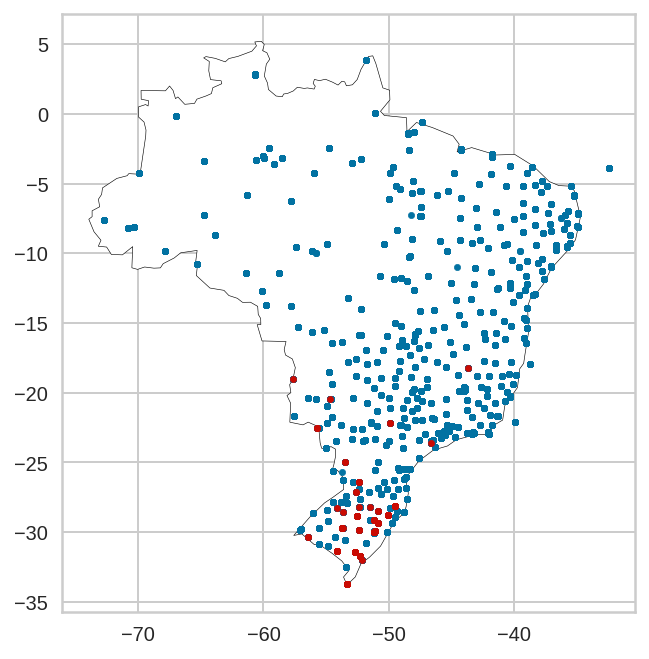

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("All time in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
39       869340      99999  2021  ...  2021-01-19  2021-01-19                  19
68       817840      99999  2021  ...  2021-02-26  2021-02-26                  57
115      868700      99999  2021  ...  2021-02-21  2021-02-21                  52
212      869900      99999  2021  ...  2021-01-31  2021-01-31                  31
363      868460      99999  2021  ...  2021-03-23  2021-03-23                  83
...         ...        ...   ...  ...         ...         ...                 ...
3436749  868450      99999  2021  ...  2021-01-17  2021-01-17                  17
3436750  868450      99999  2021  ...  2021-03-30  2021-03-30                  90
3436866  869290      99999  2021  ...  2021-02-26  2021-02-26                  57
3437313  869730      99999  2021  ...  2021-02-05  2021-02-05                  36
3437667  867390      99999  2021  ...  2021-03-07  2021-03-07                  67

[29804 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
1st quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 8.
Number of areas in map both red and blue points : 29804.


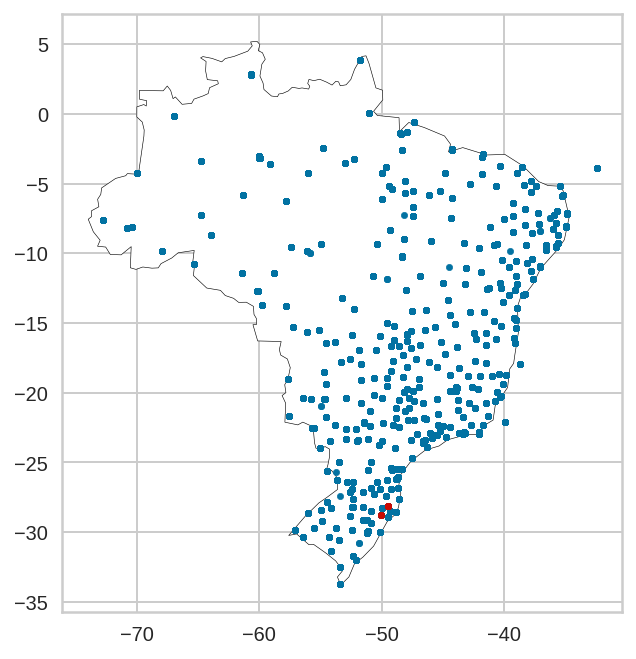

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("1st quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
8        817110      99999  2021  ...  2021-05-14  2021-05-14                 135
144      817110      99999  2021  ...  2021-04-29  2021-04-29                 120
248      869710      99999  2021  ...  2021-06-01  2021-06-01                 153
328      868700      99999  2021  ...  2021-06-01  2021-06-01                 153
329      869900      99999  2021  ...  2021-04-18  2021-04-18                 109
...         ...        ...   ...  ...         ...         ...                 ...
3437625  867770      99999  2021  ...  2021-04-28  2021-04-28                 119
3437626  867770      99999  2021  ...  2021-05-23  2021-05-23                 144
3437668  867390      99999  2021  ...  2021-05-12  2021-05-12                 133
3437669  867390      99999  2021  ...  2021-06-08  2021-06-08                 160
3437670  869770      99999  2021  ...  2021-04-16  2021-04-16                 107

[29541 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
2nd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 91.
Number of areas in map both red and blue points : 29541.


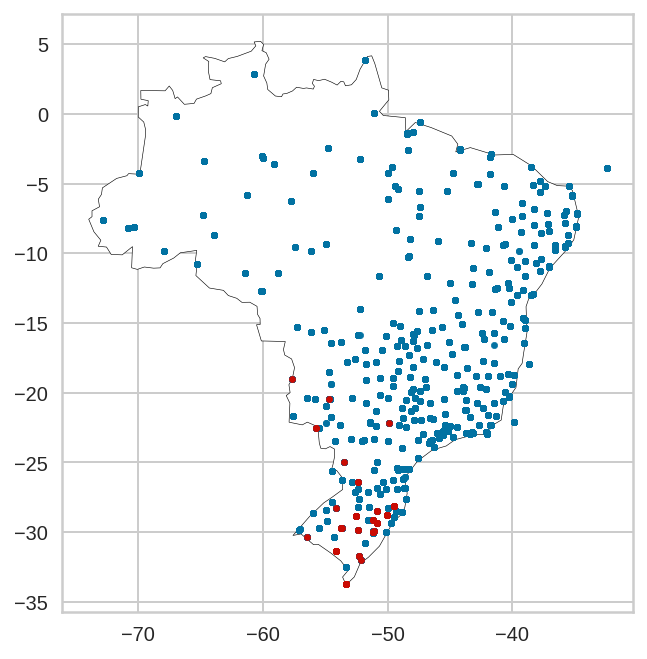

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("2nd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
36       819950      99999  2021  ...  2021-07-18  2021-07-18                 200
112      868040      99999  2021  ...  2021-09-27  2021-09-27                 271
114      866750      99999  2021  ...  2021-08-27  2021-08-27                 240
118      869900      99999  2021  ...  2021-08-15  2021-08-15                 228
146      866130      99999  2021  ...  2021-07-25  2021-07-25                 207
...         ...        ...   ...  ...         ...         ...                 ...
3436489  869800      99999  2021  ...  2021-08-04  2021-08-04                 217
3436490  869800      99999  2021  ...  2021-08-17  2021-08-17                 230
3436511  867530      99999  2021  ...  2021-07-09  2021-07-09                 191
3436828  867780      99999  2021  ...  2021-08-04  2021-08-04                 217
3437315  869730      99999  2021  ...  2021-07-13  2021-07-13                 195

[28822 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
3rd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 89.
Number of areas in map both red and blue points : 28822.


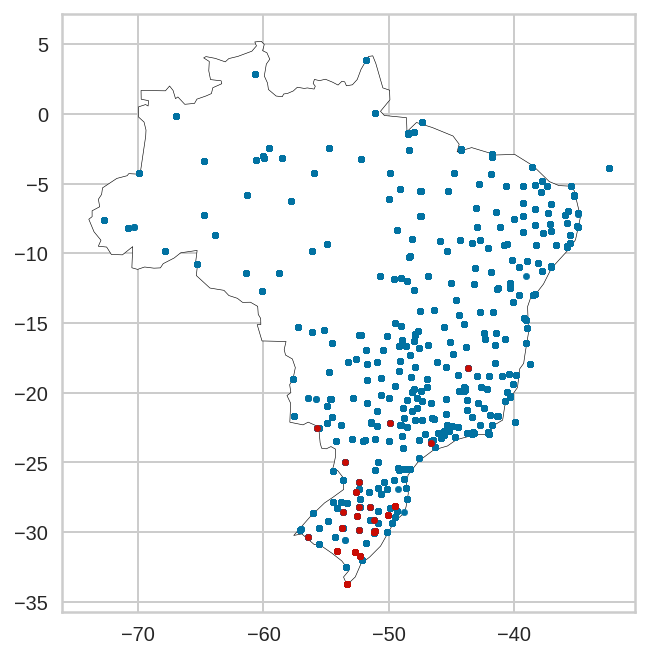

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("3rd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
113      868040      99999  2021  ...  2021-10-15  2021-10-15                 289
180      819510      99999  2021  ...  2021-10-08  2021-10-08                 282
183      869900      99999  2021  ...  2021-10-15  2021-10-15                 289
215      869340      99999  2021  ...  2021-10-05  2021-10-05                 279
292      868040      99999  2021  ...  2021-10-05  2021-10-05                 279
...         ...        ...   ...  ...         ...         ...                 ...
2962885  868190      99999  2021  ...  2021-10-25  2021-10-25                 299
2962889  869250      99999  2021  ...  2021-11-08  2021-11-08                 313
2962906  817980      99999  2021  ...  2021-10-28  2021-10-28                 302
2962908  867770      99999  2021  ...  2021-10-27  2021-10-27                 301
2962910  867390      99999  2021  ...  2021-10-20  2021-10-20                 294

[12821 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Brazil
4th quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 9.
Number of areas in map both red and blue points : 12821.


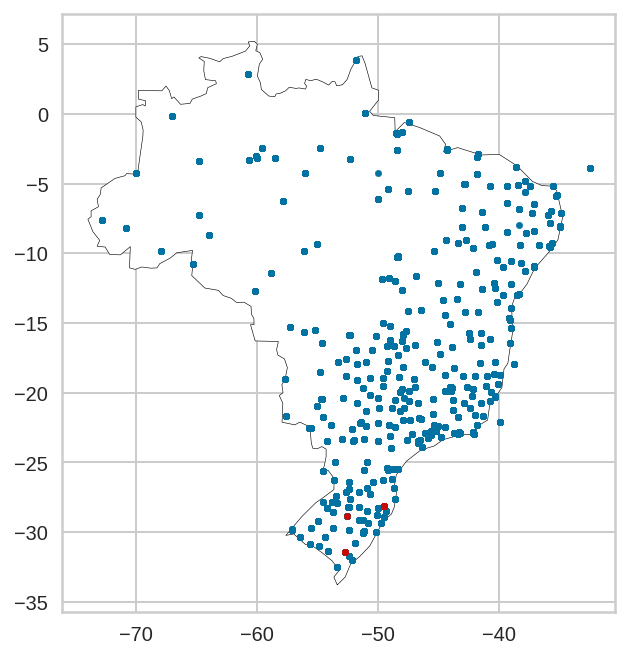

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Brazil")
print("4th quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first               geometry
6094     107520      99999  ...                 228  POINT (10.388 49.474)
15574    106190      99999  ...                  77      POINT (7.3 49.65)
20083    106870      99999  ...                  22   POINT (11.94 49.699)
20529    106190      99999  ...                 161      POINT (7.3 49.65)
22277    107550      99999  ...                  71  POINT (10.639 49.308)
...         ...        ...  ...                 ...                    ...
4101456  107550      99999  ...                 273  POINT (10.639 49.308)
4101457  107550      99999  ...                 364  POINT (10.639 49.308)
4101591  107750      99999  ...                 208  POINT (11.836 49.218)
4101592  107750      99999  ...                 290  POINT (11.836 49.218)
4101593  107750      99999  ...                 342  POINT (11.836 49.218)

[24508 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
All time in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 2342.
Number of areas in map both red and blue points : 24508.


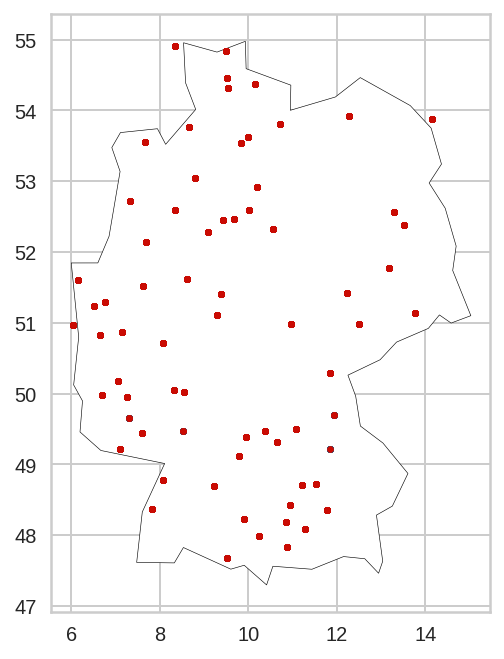

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("All time in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                         geometry
15574    106190      99999  ...                  77                POINT (7.3 49.65)
20083    106870      99999  ...                  22             POINT (11.94 49.699)
22277    107550      99999  ...                  71            POINT (10.639 49.308)
23231    107520      99999  ...                  90            POINT (10.388 49.474)
24580    107750      99999  ...                  78            POINT (11.836 49.218)
...         ...        ...  ...                 ...                              ...
4093117  107550      99999  ...                  48            POINT (10.639 49.308)
4093254  107750      99999  ...                  28            POINT (11.836 49.218)
4100863  106140      99999  ...                  80               POINT (7.6 49.437)
4100907  106330      99999  ...                  59  POINT (8.324999999999999 50.05)
4101400  107520      99999  ...                  77            POINT (10.388 49.474)

[6158 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
1st quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 1623.
Number of areas in map both red and blue points : 6158.


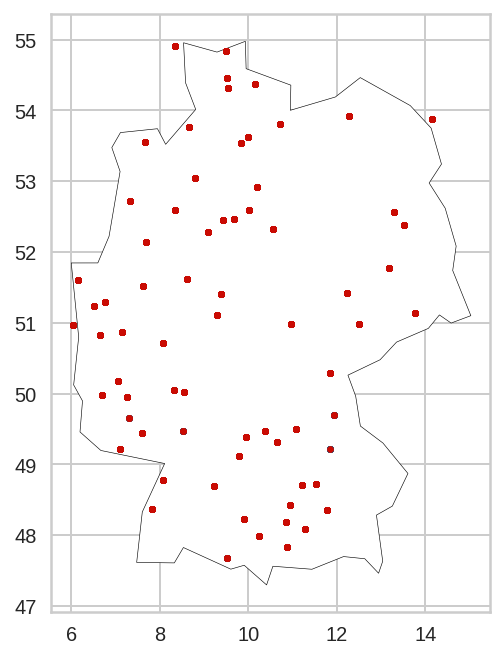

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("1st quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  ...  day_from_jan_first                         geometry
20529    106190      99999  ...                 161                POINT (7.3 49.65)
22479    107550      99999  ...                 148            POINT (10.639 49.308)
22707    106330      99999  ...                 144  POINT (8.324999999999999 50.05)
23090    107550      99999  ...                 173            POINT (10.639 49.308)
23649    106330      99999  ...                 173  POINT (8.324999999999999 50.05)
...         ...        ...  ...                 ...                              ...
4093118  107550      99999  ...                 131            POINT (10.639 49.308)
4100835  106070      99999  ...                 109             POINT (6.693 49.973)
4100858  106870      99999  ...                 101             POINT (11.94 49.699)
4100864  106140      99999  ...                 105               POINT (7.6 49.437)
4100908  106330      99999  ...                 151  POINT (8.324999999999999 50.05)

[6000 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
2nd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 133.
Number of areas in map both red and blue points : 6000.


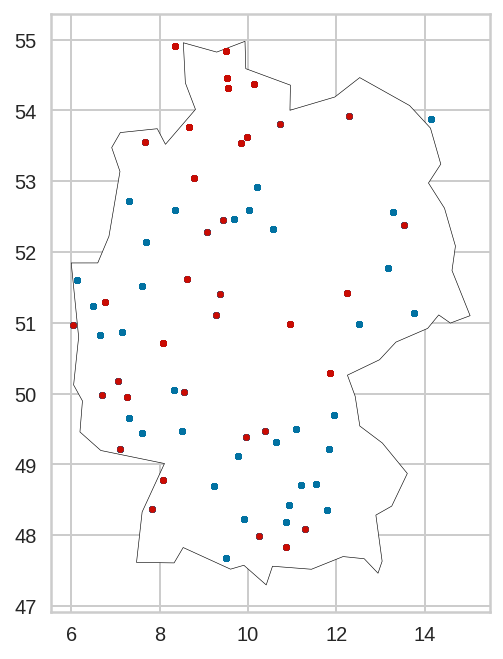

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("2nd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                          geometry
6094     107520  ...             POINT (10.388 49.474)
22953    107520  ...             POINT (10.388 49.474)
33854    106330  ...   POINT (8.324999999999999 50.05)
80759    108050  ...  POINT (7.827999999999999 48.369)
94123    108050  ...  POINT (7.827999999999999 48.369)
...         ...  ...                               ...
4100909  106330  ...   POINT (8.324999999999999 50.05)
4100910  106330  ...   POINT (8.324999999999999 50.05)
4101455  107550  ...             POINT (10.639 49.308)
4101456  107550  ...             POINT (10.639 49.308)
4101591  107750  ...             POINT (11.836 49.218)

[6185 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
3rd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 39.
Number of areas in map both red and blue points : 6185.


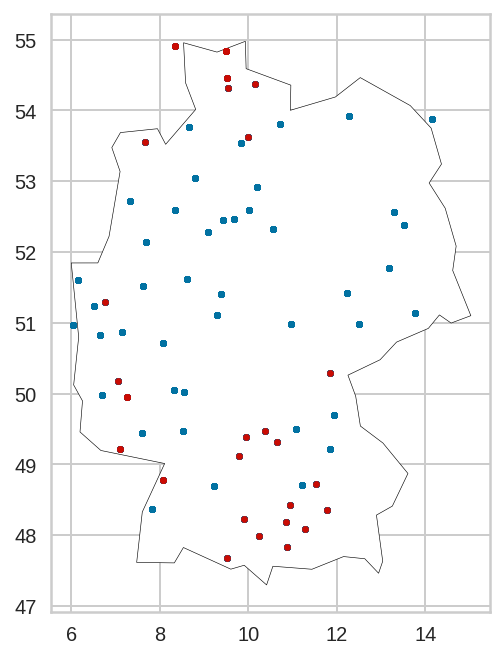

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("3rd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                          geometry
23510    107750  ...             POINT (11.836 49.218)
23926    106070  ...              POINT (6.693 49.973)
25051    107750  ...             POINT (11.836 49.218)
32527    107750  ...             POINT (11.836 49.218)
88964    108050  ...  POINT (7.827999999999999 48.369)
...         ...  ...                               ...
4100860  106870  ...              POINT (11.94 49.699)
4100911  106330  ...   POINT (8.324999999999999 50.05)
4101457  107550  ...             POINT (10.639 49.308)
4101592  107750  ...             POINT (11.836 49.218)
4101593  107750  ...             POINT (11.836 49.218)

[6165 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
4th quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 547.
Number of areas in map both red and blue points : 6165.


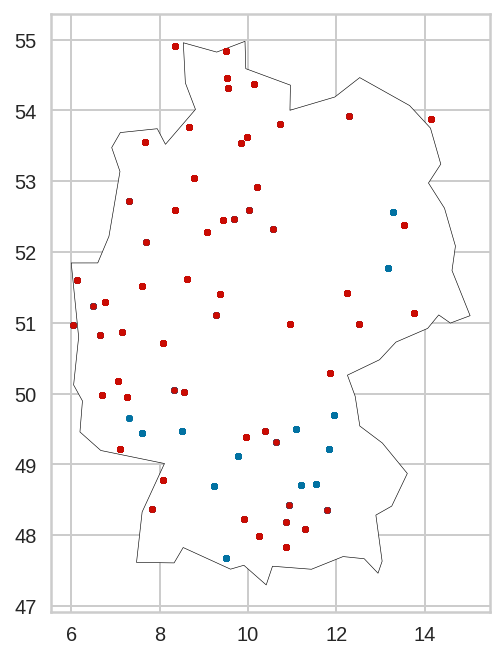

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("4th quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
2438     106330      99999  2021  ...  2021-02-11  2021-02-11                  42
13337    106190      99999  2021  ...  2021-04-06  2021-04-06                  97
17697    106330      99999  2021  ...  2021-02-19  2021-02-19                  50
17971    106870      99999  2021  ...  2021-02-19  2021-02-19                  50
18523    106140      99999  2021  ...  2021-02-19  2021-02-19                  50
...         ...        ...   ...  ...         ...         ...                 ...
3431777  107750      99999  2021  ...  2021-02-14  2021-02-14                  45
3431778  107750      99999  2021  ...  2021-04-07  2021-04-07                  98
3431779  107750      99999  2021  ...  2021-05-23  2021-05-23                 144
3431800  107550      99999  2021  ...  2021-05-25  2021-05-25                 146
3431801  107550      99999  2021  ...  2021-06-15  2021-06-15                 167

[21246 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
All time in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 1430.
Number of areas in map both red and blue points : 21246.


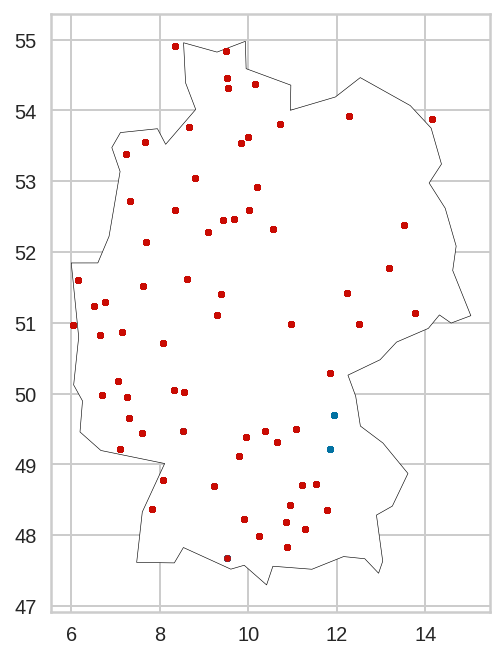

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("All time in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
1st quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 800.
Number of areas in map both red and blue points : 5836.


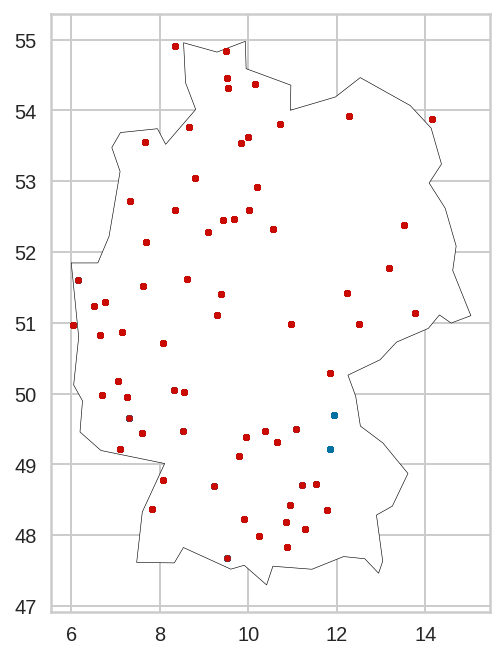

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("1st quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
13337    106190      99999  2021  ...  2021-04-06  2021-04-06                  97
27831    106870      99999  2021  ...  2021-05-11  2021-05-11                 132
30283    107750      99999  2021  ...  2021-04-14  2021-04-14                 105
32437    107520      99999  2021  ...  2021-04-09  2021-04-09                 100
34574    106140      99999  2021  ...  2021-06-03  2021-06-03                 155
...         ...        ...   ...  ...         ...         ...                 ...
3431675  106330      99999  2021  ...  2021-05-24  2021-05-24                 145
3431778  107750      99999  2021  ...  2021-04-07  2021-04-07                  98
3431779  107750      99999  2021  ...  2021-05-23  2021-05-23                 144
3431800  107550      99999  2021  ...  2021-05-25  2021-05-25                 146
3431801  107550      99999  2021  ...  2021-06-15  2021-06-15                 167

[6259 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
2nd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 383.
Number of areas in map both red and blue points : 6259.


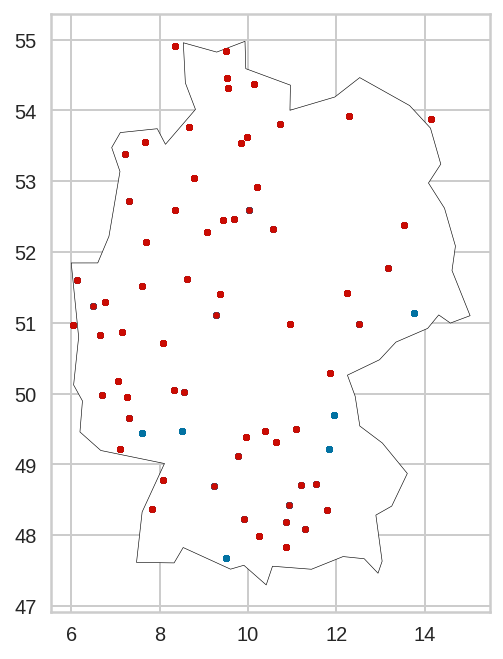

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("2nd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
27032    106190      99999  2021  ...  2021-08-12  2021-08-12                 225
28578    107750      99999  2021  ...  2021-08-19  2021-08-19                 232
34032    106070      99999  2021  ...  2021-07-08  2021-07-08                 190
36507    107520      99999  2021  ...  2021-09-13  2021-09-13                 257
39581    106140      99999  2021  ...  2021-07-21  2021-07-21                 203
...         ...        ...   ...  ...         ...         ...                 ...
3431658  106140      99999  2021  ...  2021-07-24  2021-07-24                 206
3431659  106140      99999  2021  ...  2021-09-19  2021-09-19                 263
3431661  106070      99999  2021  ...  2021-07-06  2021-07-06                 188
3431676  106330      99999  2021  ...  2021-07-19  2021-07-19                 201
3431677  106330      99999  2021  ...  2021-09-05  2021-09-05                 249

[6391 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
3rd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 29.
Number of areas in map both red and blue points : 6391.


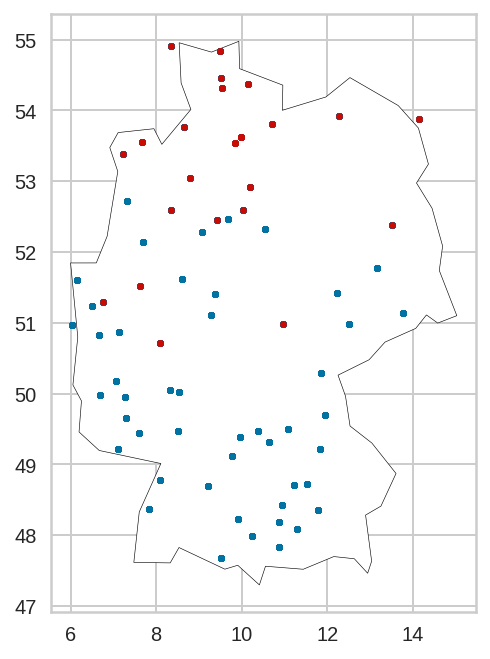

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("3rd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
28901    107750      99999  2021  ...  2021-10-14  2021-10-14                 288
29095    106070      99999  2021  ...  2021-10-01  2021-10-01                 275
89701    105000      99999  2021  ...  2021-11-01  2021-11-01                 306
105859   105000      99999  2021  ...  2021-10-17  2021-10-17                 291
107160   103210      99999  2021  ...  2021-10-01  2021-10-01                 275
...         ...        ...   ...  ...         ...         ...                 ...
3409113  107750      99999  2021  ...  2021-10-31  2021-10-31                 305
3416434  107520      99999  2021  ...  2021-10-30  2021-10-30                 304
3416448  106070      99999  2021  ...  2021-11-06  2021-11-06                 311
3424062  106870      99999  2021  ...  2021-10-16  2021-10-16                 290
3424072  106190      99999  2021  ...  2021-10-15  2021-10-15                 289

[2760 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




Germany
4th quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 218.
Number of areas in map both red and blue points : 2760.


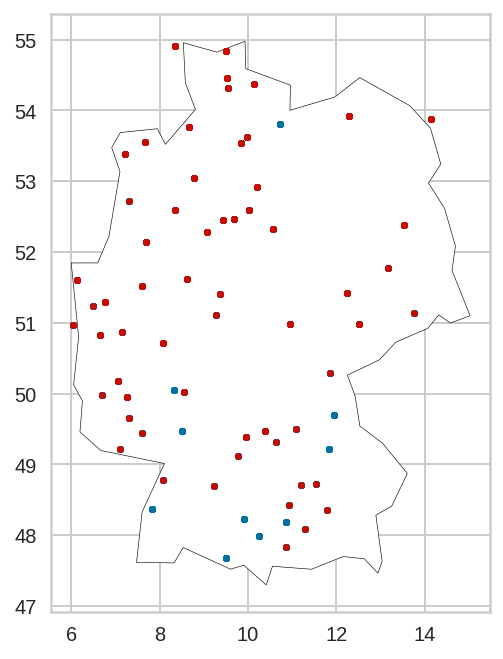

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
#base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("Germany")
print("4th quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
37782    683330  ...              POINT (23.45 -27.433)
39591    682870  ...              POINT (30.85 -24.933)
42354    683330  ...              POINT (23.45 -27.433)
43232    683330  ...              POINT (23.45 -27.433)
44112    683330  ...              POINT (23.45 -27.433)
...         ...  ...                                ...
3352008  685920  ...  POINT (31.13300000000001 -29.617)
3352495  688420  ...             POINT (25.617 -33.985)
3352507  685920  ...  POINT (31.13300000000001 -29.617)
3353016  685920  ...  POINT (31.13300000000001 -29.617)
3353543  688420  ...             POINT (25.617 -33.985)

[58762 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
All time in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 724.
Number of areas in map both red and blue points : 58762.


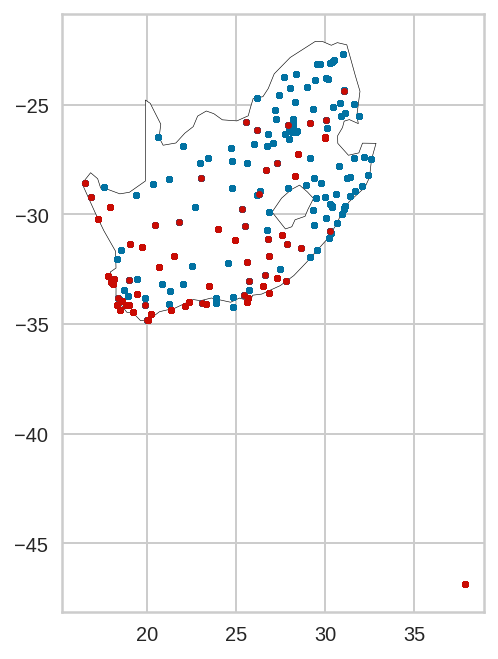

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("All time in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
37782    683330  ...              POINT (23.45 -27.433)
39591    682870  ...              POINT (30.85 -24.933)
42354    683330  ...              POINT (23.45 -27.433)
43232    683330  ...              POINT (23.45 -27.433)
44112    683330  ...              POINT (23.45 -27.433)
...         ...  ...                                ...
3346632  688420  ...             POINT (25.617 -33.985)
3347077  685920  ...  POINT (31.13300000000001 -29.617)
3352008  685920  ...  POINT (31.13300000000001 -29.617)
3352507  685920  ...  POINT (31.13300000000001 -29.617)
3353543  688420  ...             POINT (25.617 -33.985)

[14214 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
1st quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 79.
Number of areas in map both red and blue points : 14214.


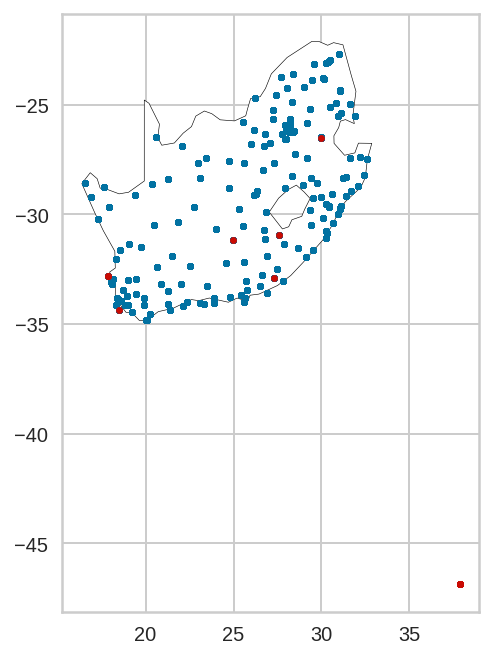

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("1st quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
71452    682672  ...  POINT (27.778 -26.34800000000001)
77892    683530  ...              POINT (27.95 -26.567)
80663    683630  ...                POINT (28.45 -26.2)
80667    685800  ...             POINT (30.283 -29.533)
80675    689250  ...             POINT (19.023 -34.139)
...         ...  ...                                ...
3340272  685920  ...  POINT (31.13300000000001 -29.617)
3344643  685920  ...  POINT (31.13300000000001 -29.617)
3345669  685920  ...  POINT (31.13300000000001 -29.617)
3345670  685920  ...  POINT (31.13300000000001 -29.617)
3351523  688420  ...             POINT (25.617 -33.985)

[14882 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
2nd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 170.
Number of areas in map both red and blue points : 14882.


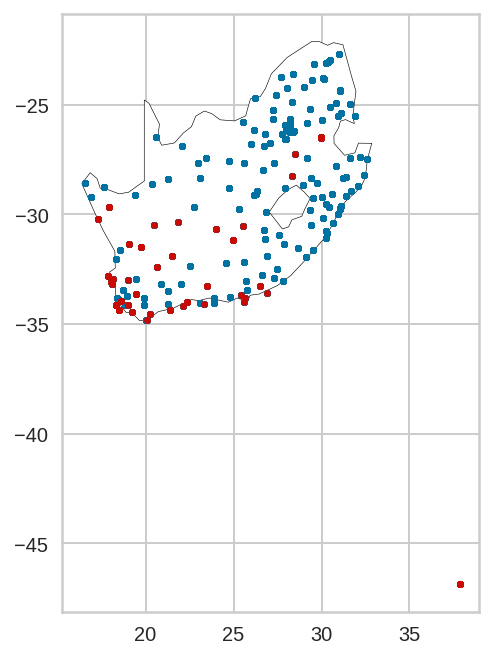

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("2nd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
54174    682643  ...             POINT (28.224 -25.654)
80650    683465  ...              POINT (29.98 -26.496)
80660    682690  ...               POINT (28.2 -25.767)
80681    682672  ...  POINT (27.778 -26.34800000000001)
80698    683420  ...             POINT (26.017 -26.817)
...         ...  ...                                ...
3342698  685920  ...  POINT (31.13300000000001 -29.617)
3346633  688420  ...             POINT (25.617 -33.985)
3346634  688420  ...             POINT (25.617 -33.985)
3349034  688420  ...             POINT (25.617 -33.985)
3352495  688420  ...             POINT (25.617 -33.985)

[14900 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
3rd quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 312.
Number of areas in map both red and blue points : 14900.


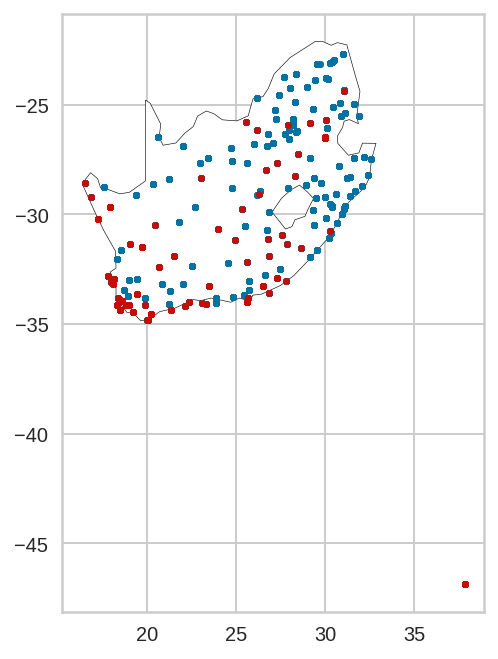

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("3rd quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStationsIntMul100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStationsIntMul100.csv')#check point
df=allWhetherGoogleStationsIntMul100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  ...                           geometry
47826    683610  ...                  POINT (28 -26.15)
65164    681840  ...               POINT (30.467 -25.1)
78780    683490  ...             POINT (26.788 -26.325)
80647    681880  ...             POINT (30.067 -23.767)
80649    682645  ...              POINT (29.697 -23.16)
...         ...  ...                                ...
3340273  685920  ...  POINT (31.13300000000001 -29.617)
3344148  688420  ...             POINT (25.617 -33.985)
3346141  688420  ...             POINT (25.617 -33.985)
3349050  685920  ...  POINT (31.13300000000001 -29.617)
3353016  685920  ...  POINT (31.13300000000001 -29.617)

[14766 rows x 25 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
4th quarter in year 2020, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 163.
Number of areas in map both red and blue points : 14766.


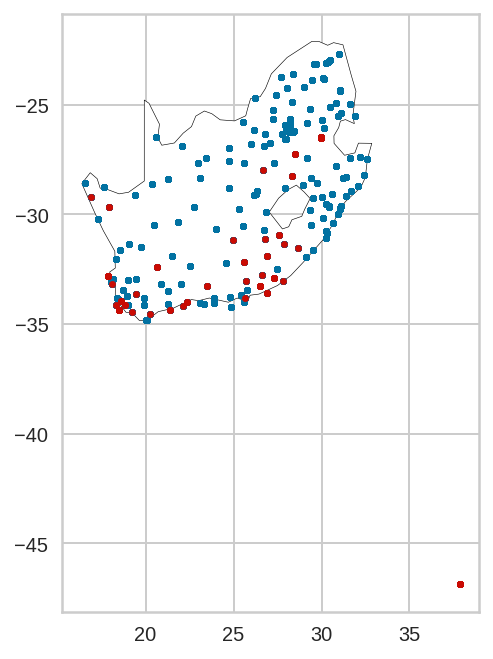

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("4th quarter in year 2020, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
47500    683530      99999  2021  ...  2021-01-02  2021-01-02                   2
52936    682680      99999  2021  ...  2021-08-16  2021-08-16                 229
68108    685240      99999  2021  ...  2021-01-30  2021-01-30                  30
68117    683007      99999  2021  ...  2021-06-04  2021-06-04                 156
68871    686510      99999  2021  ...  2021-11-08  2021-11-08                 313
...         ...        ...   ...  ...         ...         ...                 ...
2820297  685920      99999  2021  ...  2021-08-21  2021-08-21                 234
2820738  688420      99999  2021  ...  2021-03-03  2021-03-03                  63
2820739  685920      99999  2021  ...  2021-09-05  2021-09-05                 249
2820740  685920      99999  2021  ...  2021-10-21  2021-10-21                 295
2821625  685920      99999  2021  ...  2021-07-04  2021-07-04                 186

[47638 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
All time in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 579.
Number of areas in map both red and blue points : 47638.


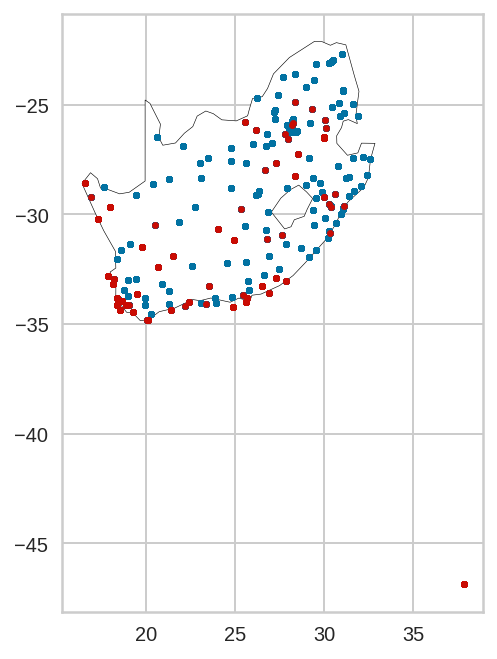

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("All time in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
47500    683530      99999  2021  ...  2021-01-02  2021-01-02                   2
68108    685240      99999  2021  ...  2021-01-30  2021-01-30                  30
82690    685230      99999  2021  ...  2021-02-10  2021-02-10                  41
82694    685820      99999  2021  ...  2021-02-13  2021-02-13                  44
82695    683530      99999  2021  ...  2021-01-05  2021-01-05                   5
...         ...        ...   ...  ...         ...         ...                 ...
2804411  688420      99999  2021  ...  2021-02-18  2021-02-18                  49
2809820  688420      99999  2021  ...  2021-01-30  2021-01-30                  30
2809821  688420      99999  2021  ...  2021-01-31  2021-01-31                  31
2813318  688420      99999  2021  ...  2021-01-01  2021-01-01                   1
2820738  688420      99999  2021  ...  2021-03-03  2021-03-03                  63

[13069 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
1st quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 67.
Number of areas in map both red and blue points : 13069.


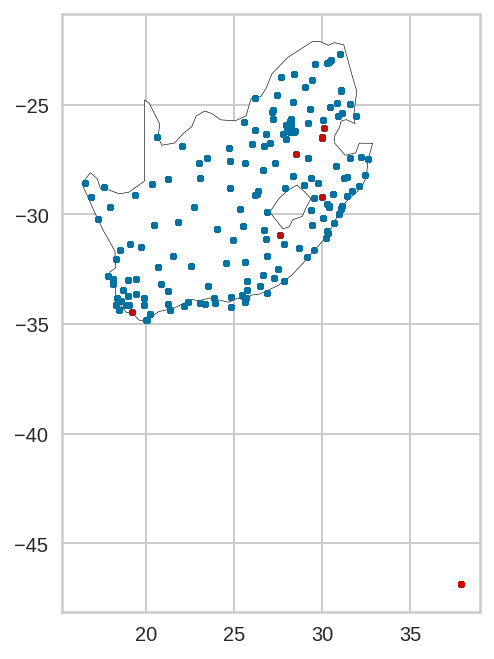

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("1st quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
68117    683007      99999  2021  ...  2021-06-04  2021-06-04                 156
81096    682720      99999  2021  ...  2021-05-23  2021-05-23                 144
82689    683350      99999  2021  ...  2021-05-09  2021-05-09                 130
82700    681920      99999  2021  ...  2021-04-04  2021-04-04                  95
82701    681920      99999  2021  ...  2021-05-02  2021-05-02                 123
...         ...        ...   ...  ...         ...         ...                 ...
2803079  688420      99999  2021  ...  2021-06-26  2021-06-26                 178
2803520  688420      99999  2021  ...  2021-04-20  2021-04-20                 111
2805741  685920      99999  2021  ...  2021-06-17  2021-06-17                 169
2813319  688420      99999  2021  ...  2021-05-07  2021-05-07                 128
2820295  688420      99999  2021  ...  2021-06-05  2021-06-05                 157

[14107 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
2nd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 132.
Number of areas in map both red and blue points : 14107.


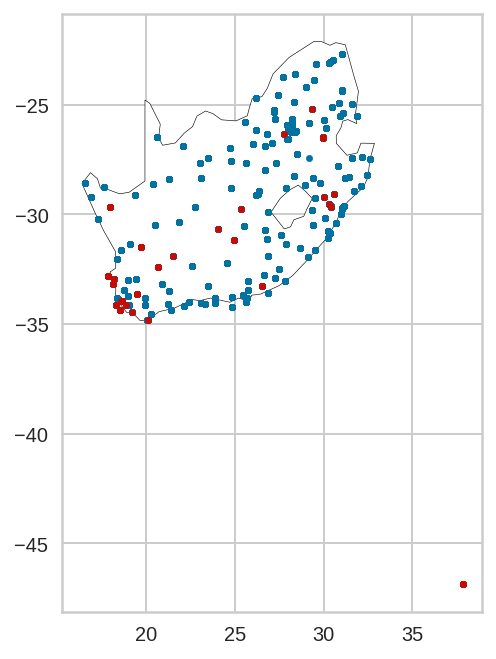

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("2nd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
52936    682680      99999  2021  ...  2021-08-16  2021-08-16                 229
82697    683530      99999  2021  ...  2021-09-24  2021-09-24                 268
82702    681920      99999  2021  ...  2021-07-27  2021-07-27                 209
82703    681920      99999  2021  ...  2021-08-13  2021-08-13                 226
82916    682570      99999  2021  ...  2021-08-29  2021-08-29                 242
...         ...        ...   ...  ...         ...         ...                 ...
2819442  685920      99999  2021  ...  2021-08-22  2021-08-22                 235
2820296  688420      99999  2021  ...  2021-08-10  2021-08-10                 223
2820297  685920      99999  2021  ...  2021-08-21  2021-08-21                 234
2820739  685920      99999  2021  ...  2021-09-05  2021-09-05                 249
2821625  685920      99999  2021  ...  2021-07-04  2021-07-04                 186

[14538 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
3rd quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 312.
Number of areas in map both red and blue points : 14538.


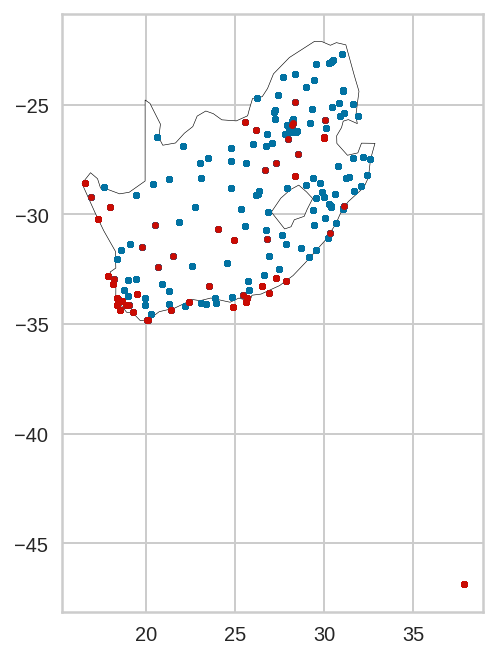

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("3rd quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

In [ ]:
allWhetherGoogleStations2021interpolate100=pd.read_csv('/content/drive/MyDrive/covid-19/allWhetherGoogleStations2021interpolate100.csv')#check point
df=allWhetherGoogleStations2021interpolate100
#tempdf=df.loc[(df['country'] == 'JA')]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'JA') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'UK')]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'UK') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'US')]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'US') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'BR')]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'BR') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'GM')]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'GM') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'IN')]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'IN') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'NI')]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 7) & (df['month'] <= 9)]
#tempdf=df.loc[(df['country'] == 'NI') & (df['month'] >= 10) & (df['month'] <= 12)]
#tempdf=df.loc[(df['country'] == 'SF')]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 1) & (df['month'] <= 3)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 4) & (df['month'] <= 6)]
#tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 7) & (df['month'] <= 9)]
tempdf=df.loc[(df['country'] == 'SF') & (df['month'] >= 10) & (df['month'] <= 12)]
tempdf

stn  wban_left  year  ...        Date       Date2  day_from_jan_first
68871    686510      99999  2021  ...  2021-11-08  2021-11-08                 313
82692    685810      99999  2021  ...  2021-10-22  2021-10-22                 296
82925    683530      99999  2021  ...  2021-11-05  2021-11-05                 310
82942    685580      99999  2021  ...  2021-10-25  2021-10-25                 299
83125    681760      99999  2021  ...  2021-10-26  2021-10-26                 300
...         ...        ...   ...  ...         ...         ...                 ...
2803954  688160      99999  2021  ...  2021-10-30  2021-10-30                 304
2808483  688420      99999  2021  ...  2021-11-04  2021-11-04                 309
2809371  688160      99999  2021  ...  2021-11-07  2021-11-07                 312
2814719  685920      99999  2021  ...  2021-10-23  2021-10-23                 297
2820740  685920      99999  2021  ...  2021-10-21  2021-10-21                 295

[5924 rows x 24 columns]

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)




South Africa
4th quarter in year 2021, criterias are temperature, humidity and wind.
Number of danger areas in terms of weather factors : 68.
Number of areas in map both red and blue points : 5924.


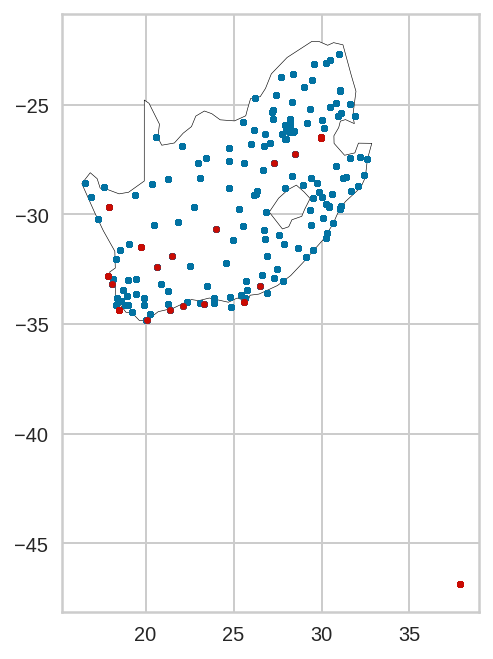

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

Selectdf= tempdf[(tempdf['temp']<=1400) & (tempdf['rh']>=66) & (tempdf['wdsp']>=1100)]

crs={'init': 'epsg:4326'}
geom_Selectdf= [Point(xy) for xy in zip(Selectdf['lon'], Selectdf['lat'])]
geo_Selectdf= gpd.GeoDataFrame(Selectdf, crs=crs, geometry= geom_Selectdf)
geo_Selectdf = geo_Selectdf.to_crs(countries.crs)

geom= [Point(xy) for xy in zip(tempdf['lon'], tempdf['lat'])]
geo_df= gpd.GeoDataFrame(tempdf, crs=crs, geometry= geom)
geo_df = geo_df.to_crs(countries.crs)

#base = world[(world.name == "Japan")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')
#base = world[(world.name == "United States of America")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Brazil")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Germany")].plot(color='white', edgecolor='black')
#base = world[(world.name == "India")].plot(color='white', edgecolor='black')
#base = world[(world.name == "Nigeria")].plot(color='white', edgecolor='black')
base = world[(world.name == "South Africa")].plot(color='white', edgecolor='black')

#base = countries.plot(color='white', edgecolor='black', figsize = (15,15)) #original

geo_df.plot(ax= base, markersize=10, color= 'b', marker= "o")
geo_Selectdf.plot(ax= base, markersize=10, color= 'r', marker= "o")
print()
print()
print("South Africa")
print("4th quarter in year 2021, criterias are temperature, humidity and wind.")
print("Number of danger areas in terms of weather factors : "+str(len(geo_Selectdf))+".")
print("Number of areas in map both red and blue points : "+str(len(geo_df))+".")

<function matplotlib.pyplot.show>

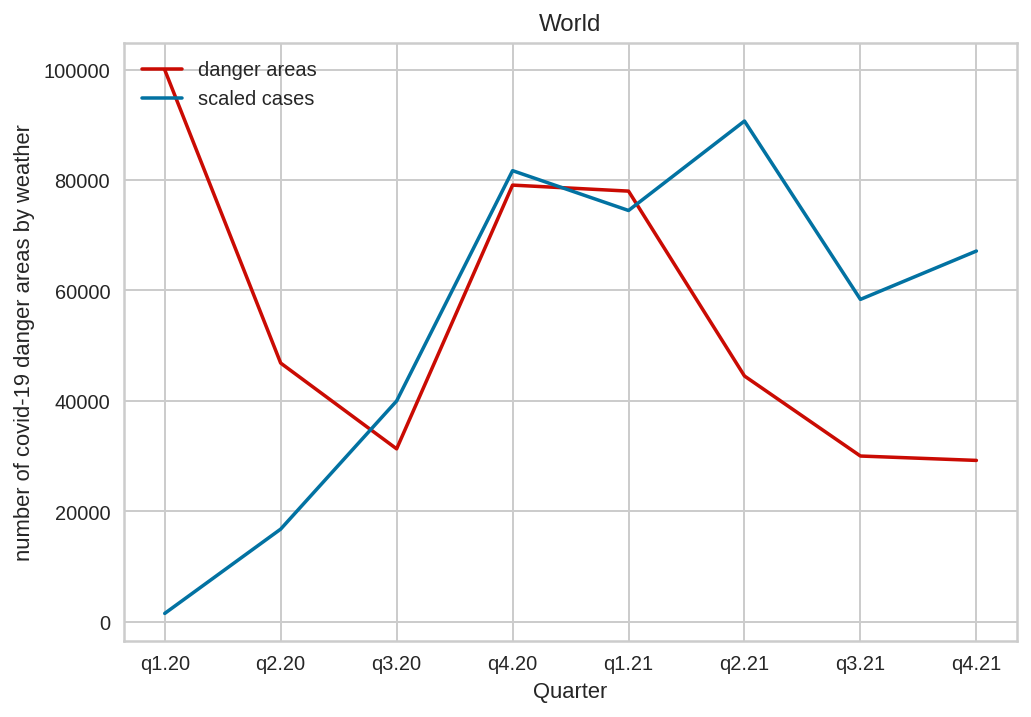

In [ ]:
quarter = ["q1.20","q2.20","q3.20","q4.20","q1.21","q2.21","q3.21","q4.21"]
areas = [99982,46849,31309,79093,78005,44505,30007,29212]
cases = [893702,10059496,23991343,49026748,44697875,54420692,35032554,40287512]
i = 0
while i<len(cases):
  cases[i]=cases[i]/600
  i = i + 1
plt.plot(quarter, areas, "-r", label="danger areas")
plt.plot(quarter, cases, "-b", label="scaled cases")
plt.legend(loc="upper left")
plt.title("World")
plt.xlabel("Quarter")
plt.ylabel("number of covid-19 danger areas by weather")
plt.show
#use the number of BAD area and the real covid-19 accumulated cases in each quarter from 2020 - 2021
#to do the time series analysis.
#the real covid-19 accumulated cases was scaled to easily identify whether or not the number of cases and BAD area are consistent.

<function matplotlib.pyplot.show>

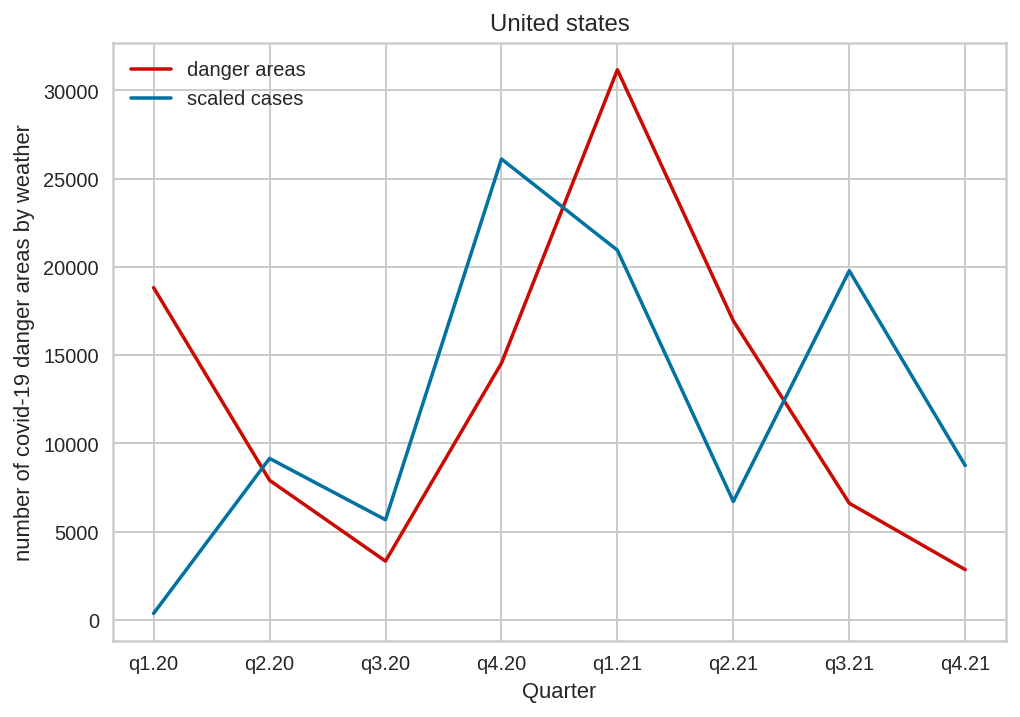

In [ ]:
quarter = ["q1.20","q2.20","q3.20","q4.20","q1.21","q2.21","q3.21","q4.21"]
areas = [18826,7914,3331,14546,31166,16943,6612,2849]
cases = [184982,4575332,2837195,13056730,10472779,3356394,9891578,4373567]
i = 0
while i<len(cases):
  cases[i]=cases[i]/500
  i = i + 1
plt.plot(quarter, areas, "-r", label="danger areas")
plt.plot(quarter, cases, "-b", label="scaled cases")
plt.legend(loc="upper left")
plt.title("United states")
plt.xlabel("Quarter")
plt.ylabel("number of covid-19 danger areas by weather")
plt.show
#use the number of BAD area and the real covid-19 accumulated cases in each quarter from 2020 - 2021
#to do the time series analysis.
#the real covid-19 accumulated cases was scaled to easily identify whether or not the number of cases and BAD area are consistent.

<function matplotlib.pyplot.show>

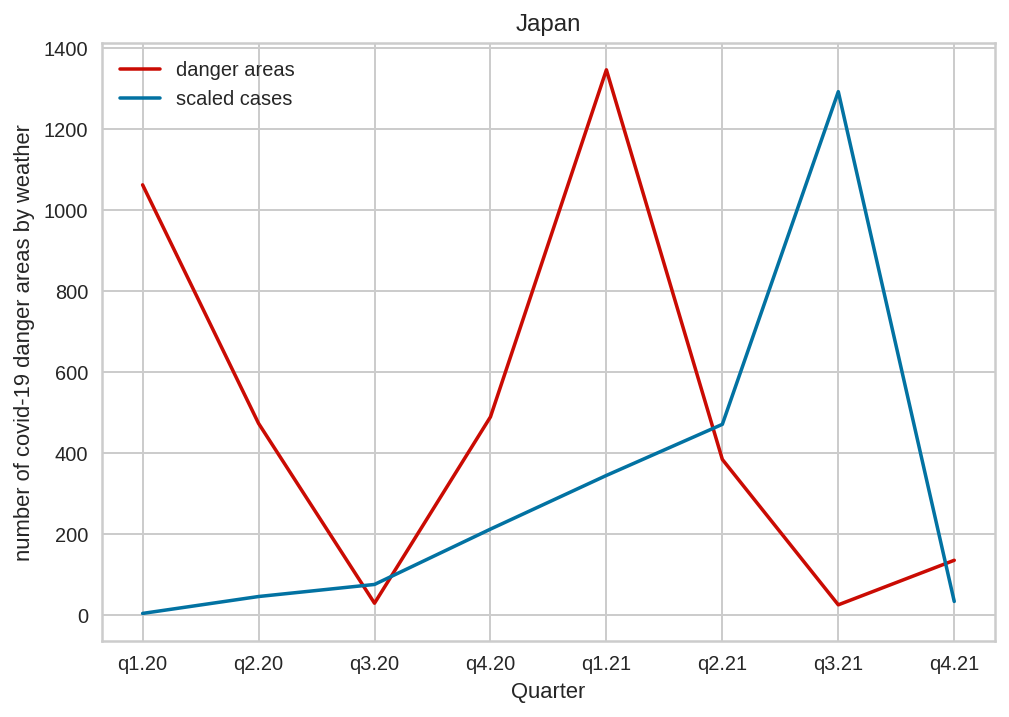

In [ ]:
quarter = ["q1.20","q2.20","q3.20","q4.20","q1.21","q2.21","q3.21","q4.21"]
areas = [1061,472,28,488,1345,383,24,134]
cases = [1953,31163,52031,147648,240450,328777,903754,22654]
i = 0
while i<len(cases):
  cases[i]=cases[i]/700
  i = i + 1
plt.plot(quarter, areas, "-r", label="danger areas")
plt.plot(quarter, cases, "-b", label="scaled cases")
plt.legend(loc="upper left")
plt.title("Japan")
plt.xlabel("Quarter")
plt.ylabel("number of covid-19 danger areas by weather")
plt.show
#use the number of BAD area and the real covid-19 accumulated cases in each quarter from 2020 - 2021
#to do the time series analysis.
#the real covid-19 accumulated cases was scaled to easily identify whether or not the number of cases and BAD area are consistent.

<function matplotlib.pyplot.show>

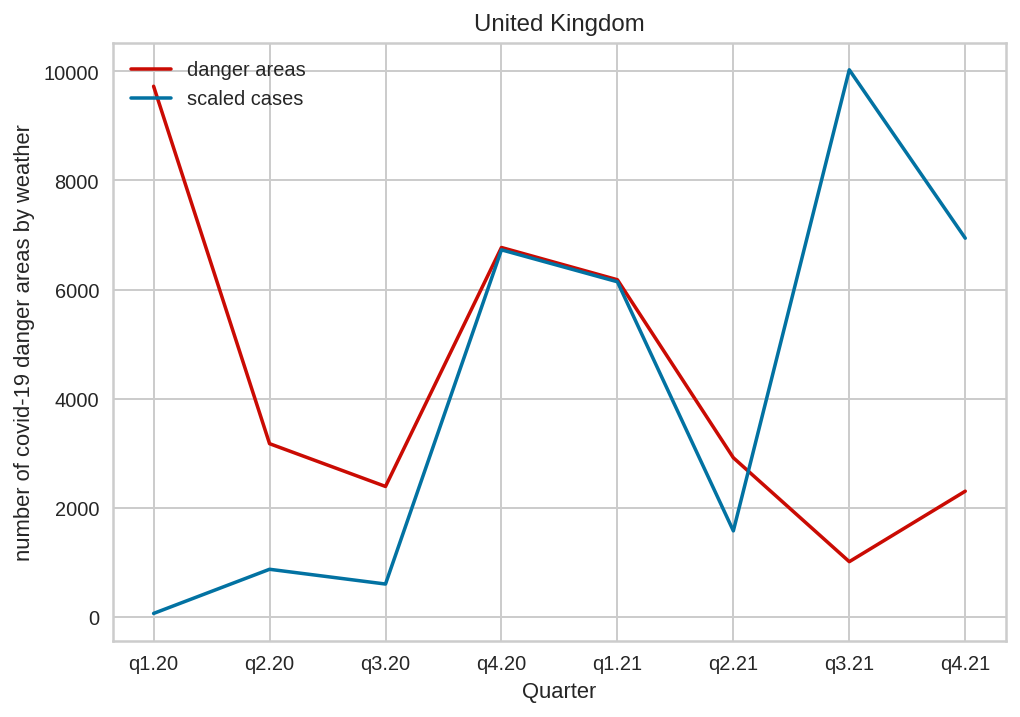

In [ ]:
quarter = ["q1.20","q2.20","q3.20","q4.20","q1.21","q2.21","q3.21","q4.21"]
areas = [9725,3177,2393,6771,6180,2919,1015,2306]
cases = [20029,262661,181519,2018510,1842950,473790,3007935,2082530]
i = 0
while i<len(cases):
  cases[i]=cases[i]/300
  i = i + 1
plt.plot(quarter, areas, "-r", label="danger areas")
plt.plot(quarter, cases, "-b", label="scaled cases")
plt.legend(loc="upper left")
plt.title("United Kingdom")
plt.xlabel("Quarter")
plt.ylabel("number of covid-19 danger areas by weather")
plt.show
#use the number of BAD area and the real covid-19 accumulated cases in each quarter from 2020 - 2021
#to do the time series analysis.
#the real covid-19 accumulated cases was scaled to easily identify whether or not the number of cases and BAD area are consistent.

<function matplotlib.pyplot.show>

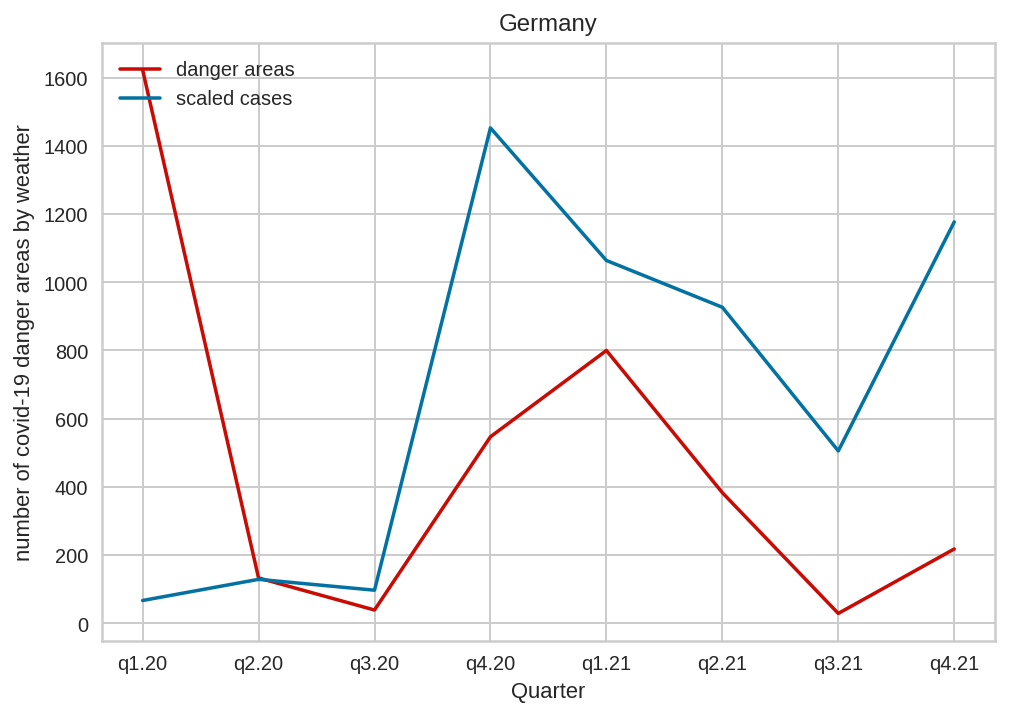

In [ ]:
quarter = ["q1.20","q2.20","q3.20","q4.20","q1.21","q2.21","q3.21","q4.21"]
areas = [1623,133,39,547,800,383,29,218]
cases = [66885,128947,97079,1452607,1063992,926713,505483,1176975]
i = 0
while i<len(cases):
  cases[i]=cases[i]/1000
  i = i + 1
plt.plot(quarter, areas, "-r", label="danger areas")
plt.plot(quarter, cases, "-b", label="scaled cases")
plt.legend(loc="upper left")
plt.title("Germany")
plt.xlabel("Quarter")
plt.ylabel("number of covid-19 danger areas by weather")
plt.show
#use the number of BAD area and the real covid-19 accumulated cases in each quarter from 2020 - 2021
#to do the time series analysis.
#the real covid-19 accumulated cases was scaled to easily identify whether or not the number of cases and BAD area are consistent.

<function matplotlib.pyplot.show>

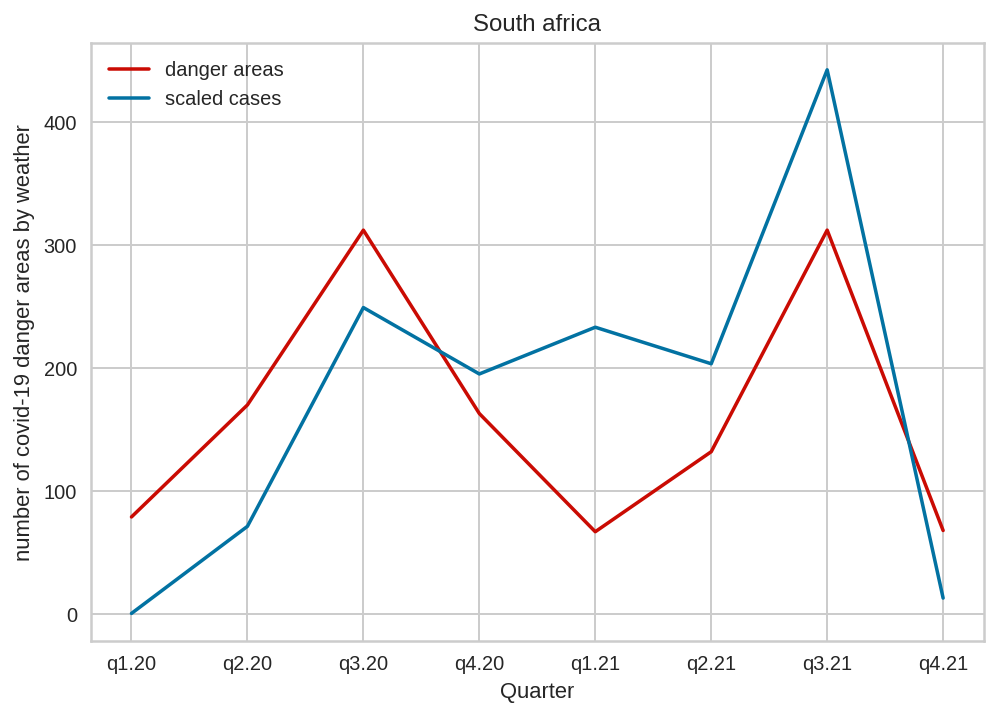

In [ ]:
quarter = ["q1.20","q2.20","q3.20","q4.20","q1.21","q2.21","q3.21","q4.21"]
areas = [79,170,312,163,67,132,312,68]
cases = [1326,149883,523130,409822,489574,427237,928700,27502]
i = 0
while i<len(cases):
  cases[i]=cases[i]/2100
  i = i + 1
plt.plot(quarter, areas, "-r", label="danger areas")
plt.plot(quarter, cases, "-b", label="scaled cases")
plt.legend(loc="upper left")
plt.title("South africa")
plt.xlabel("Quarter")
plt.ylabel("number of covid-19 danger areas by weather")
plt.show
#use the number of BAD area and the real covid-19 accumulated cases in each quarter from 2020 - 2021
#to do the time series analysis.
#the real covid-19 accumulated cases was scaled to easily identify whether or not the number of cases and BAD area are consistent.